In [1]:
!pip install albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.6/290.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.8/307.8 kB 21.1 MB/s eta 0:00:00


In [14]:
from google.colab import drive
import pandas as pd
import os

# Step 1: Mount Google Drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import pandas as pd
import numpy as np
import os
import re





In [16]:
def create_birads_mapping(excel_path: str) -> dict:
    """
    Create a BIRADS mapping from an Excel file, with specific mapping rules.

    Args:
        excel_path (str): Path to the Excel file containing mammogram data

    Returns:
        dict: A dictionary mapping filenames to simplified BIRADS categories

    Mapping rules:
    - BIRADS 4a, 4b, 4c -> mapped to 4
    - BIRADS 6 -> mapped to 5
    - Other categories remain the same
    """
    # Read the Excel file
    df = pd.read_excel(excel_path)

    # Create mapping dictionary
    birads_mapping = {}

    # Iterate through the dataframe rows
    for _, row in df.iterrows():
        # Handle filename conversion, skipping NaN values
        try:
            # Try to convert to integer, handling potential float or NaN
            if pd.isna(row['File Name']):
                print(f"Skipping row with NaN filename")
                continue

            # Handle float values by converting to integer
            filename = str(int(row['File Name']))
        except (ValueError, TypeError):
            print(f"Could not convert filename: {row['File Name']}")
            continue

        # Get original BIRADS category
        original_birads = row['Bi-Rads']

        # Apply mapping rules
        if pd.isna(original_birads):
            print(f"Skipping row with NaN BIRADS for filename {filename}")
            continue

        if original_birads in ['4a', '4b', '4c']:
            mapped_birads = 4
        elif original_birads == 6:
            mapped_birads = 5
        else:
            try:
                mapped_birads = int(original_birads)
            except ValueError:
                # Handle any non-numeric or unexpected BIRADS categories
                print(f"Warning: Unexpected BIRADS category for {filename}: {original_birads}")
                mapped_birads = None

        # Add to mapping dictionary
        if mapped_birads is not None:
            birads_mapping[filename] = mapped_birads

    return birads_mapping


In [4]:


def pair_mammogram_images(cc_image_dir: str, mlo_image_dir: str, birads_mapping: dict) -> dict:
    """
    Pair CC and MLO mammogram images using specific pattern matching.

    Args:
        cc_image_dir (str): Directory containing CC view images
        mlo_image_dir (str): Directory containing MLO view images
        birads_mapping (dict): BIRADS mapping dictionary

    Returns:
        dict: A dictionary of paired images with their BIRADS category
    """
    # Dictionary to store paired images
    paired_images = {}

    # Get list of CC files
    cc_files = os.listdir(cc_image_dir)

    for cc_file in cc_files:
        # Extract the part from after first underscore up to just before fourth underscore
        part_match = re.search(r'^[^_]+_([^_]+_[^_]+_[^_]+)_', cc_file)
        if not part_match:
            print(f"Could not extract comparison part from {cc_file}")
            continue

        comparison_part = part_match.group(1)  # This captures "6c613a14b80a8591_MG_L"

        # Extract the part before the first underscore for BIRADS lookup
        numerical_id_match = re.match(r'^(\d+)_', cc_file)
        if not numerical_id_match:
            print(f"Could not extract numerical ID from {cc_file}")
            continue

        numerical_id = numerical_id_match.group(1)

        # Find corresponding MLO file with the same comparison part
        mlo_file = None
        for file in os.listdir(mlo_image_dir):
            # Check if the file contains the same comparison part
            mlo_part_match = re.search(r'^[^_]+_([^_]+_[^_]+_[^_]+)_', file)
            if mlo_part_match and mlo_part_match.group(1) == comparison_part:
                mlo_file = file
                break

        if mlo_file is None:
            print(f"No MLO view found for comparison part {comparison_part}")
            continue

        # Check if numerical ID exists in BIRADS mapping
        if numerical_id not in birads_mapping:
            print(f"No BIRADS category found for patient {numerical_id}")
            continue

        # Store paired images with their BIRADS category
        paired_images[numerical_id] = {
            'cc_image': os.path.join(cc_image_dir, cc_file),
            'mlo_image': os.path.join(mlo_image_dir, mlo_file),
            'birads': birads_mapping[numerical_id]
        }

    return paired_images


In [6]:
!pip install opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 20.3 MB/s eta 0:00:00


In [5]:
import numpy as np
import cv2

def create_mammogram_arrays(paired_mammograms):
    """
    Convert paired mammogram images to numpy arrays.

    Parameters:
    -----------
    paired_mammograms : dict
        A dictionary of paired mammogram images

    Returns:
    --------
    tuple: (cc_images, mlo_images, labels, patient_ids)
        - cc_images: Numpy array of CC view images
        - mlo_images: Numpy array of MLO view images
        - labels: Numpy array of BI-RADS labels
        - patient_ids: List of patient IDs
    """
    # Prepare lists to store data
    cc_images = []
    mlo_images = []
    labels = []
    patient_ids = []

    # Process each paired mammogram
    for patient_id, image_data in paired_mammograms.items():
        try:
            # Load CC and MLO images in RGB
            cc_img = cv2.imread(image_data['cc_image'], cv2.IMREAD_COLOR)
            cc_img = cv2.cvtColor(cc_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

            mlo_img = cv2.imread(image_data['mlo_image'], cv2.IMREAD_COLOR)
            mlo_img = cv2.cvtColor(mlo_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

            # Add to lists
            cc_images.append(cc_img)
            mlo_images.append(mlo_img)
            labels.append(image_data['birads'])
            patient_ids.append(patient_id)

        except Exception as e:
            print(f"Error processing patient {patient_id}: {e}")

    # Convert lists to numpy arrays
    cc_images = np.array(cc_images)
    mlo_images = np.array(mlo_images)
    labels = np.array(labels)

    # Print dataset summary
    print("Mammogram Dataset Summary:")
    print(f"Total number of paired mammograms: {len(labels)}")
    print("BI-RADS Category Distribution:")
    unique, counts = np.unique(labels, return_counts=True)
    for category, count in zip(unique, counts):
        print(f"BI-RADS {category}: {count}")

    return cc_images, mlo_images, labels, patient_ids

# Example usage
# cc_images, mlo_images, labels, patient_ids = create_mammogram_arrays(paired_mammograms)

In [6]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def view_mammogram_pair(paired_images, patient_id=None, figsize=(12, 6)):
    """
    View a pair of mammogram images (CC and MLO views) in RGB

    Args:
        paired_images (dict): Dictionary of paired mammogram images
        patient_id (str, optional): Specific patient ID to view.
                                    If None, displays the first pair.
        figsize (tuple): Figure size for the plot
    """
    # If no specific patient ID is provided, take the first one
    if patient_id is None:
        patient_id = list(paired_images.keys())[0]

    # Check if patient ID exists in paired images
    if patient_id not in paired_images:
        print(f"Patient ID {patient_id} not found in paired images")
        return

    # Get image paths
    cc_path = paired_images[patient_id]['cc_image']
    mlo_path = paired_images[patient_id]['mlo_image']
    birads = paired_images[patient_id]['birads']

    # Read images in RGB (convert from BGR to RGB)
    cc_image = cv2.imread(cc_path)
    cc_image = cv2.cvtColor(cc_image, cv2.COLOR_BGR2RGB)
    mlo_image = cv2.imread(mlo_path)
    mlo_image = cv2.cvtColor(mlo_image, cv2.COLOR_BGR2RGB)

    # Create figure
    plt.figure(figsize=figsize)

    # Plot CC view
    plt.subplot(1, 2, 1)
    plt.imshow(cc_image)
    plt.title(f'{patient_id} - CC View\nBIRADS: {birads}')
    plt.axis('off')

    # Plot MLO view
    plt.subplot(1, 2, 2)
    plt.imshow(mlo_image)
    plt.title(f'MLO View\nBIRADS: {birads}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()




In [7]:
import matplotlib.pyplot as plt

def visualize_mammograms(cc_images, mlo_images, labels, patient_ids=None, num_to_show=5):
    """
    Visualize paired mammogram images.

    Parameters:
    -----------
    cc_images : numpy.ndarray
        Numpy array of CC view images
    mlo_images : numpy.ndarray
        Numpy array of MLO view images
    labels : numpy.ndarray
        Array of BI-RADS labels
    patient_ids : list, optional
        List of patient IDs
    num_to_show : int, optional
        Number of image pairs to display (default is 5)
    """
    # Limit number of images to show
    num_to_show = min(num_to_show, len(cc_images))

    # Create a figure with subplots
    fig, axes = plt.subplots(num_to_show, 2, figsize=(12, 3*num_to_show))

    # Iterate through images
    for i in range(num_to_show):
        # CC view image
        axes[i, 0].imshow(cc_images[i])
        axes[i, 0].set_title(f'CC View - BI-RADS {labels[i]}')
        axes[i, 0].axis('off')

        # MLO view image
        axes[i, 1].imshow(mlo_images[i])
        axes[i, 1].set_title(f'MLO View - BI-RADS {labels[i]}')
        axes[i, 1].axis('off')

        # Add patient ID if provided
        if patient_ids:
            axes[i, 0].text(10, 20, f'Patient: {patient_ids[i]}', color='red', backgroundcolor='white')
            axes[i, 1].text(10, 20, f'Patient: {patient_ids[i]}', color='red', backgroundcolor='white')

    plt.tight_layout()
    plt.show()



In [10]:
!pip install xlrd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 2.1 MB/s eta 0:00:00


Skipping row with NaN filename
Skipping row with NaN filename
No MLO view found for comparison part 2f1104b3cda7f145_MG_R
No MLO view found for comparison part dda3c6969a34ff8e_MG_L
Paired Mammograms:
Patient 20586908:
  CC Image: /content/drive/MyDrive/cc_new_image_512/20586908_6c613a14b80a8591_MG_R_CC_ANON.png
  MLO Image: /content/drive/MyDrive/mlo_new_image_512/20586960_6c613a14b80a8591_MG_R_ML_ANON.png
  BIRADS Category: 2
Patient 20586934:
  CC Image: /content/drive/MyDrive/cc_new_image_512/20586934_6c613a14b80a8591_MG_L_CC_ANON.png
  MLO Image: /content/drive/MyDrive/mlo_new_image_512/20586986_6c613a14b80a8591_MG_L_ML_ANON.png
  BIRADS Category: 5
Patient 20587054:
  CC Image: /content/drive/MyDrive/cc_new_image_512/20587054_b6a4f750c6df4f90_MG_R_CC_ANON.png
  MLO Image: /content/drive/MyDrive/mlo_new_image_512/20587080_b6a4f750c6df4f90_MG_R_ML_ANON.png
  BIRADS Category: 4
Patient 20587148:
  CC Image: /content/drive/MyDrive/cc_new_image_512/20587148_fd746d25eb40b3dc_MG_R_CC_AN

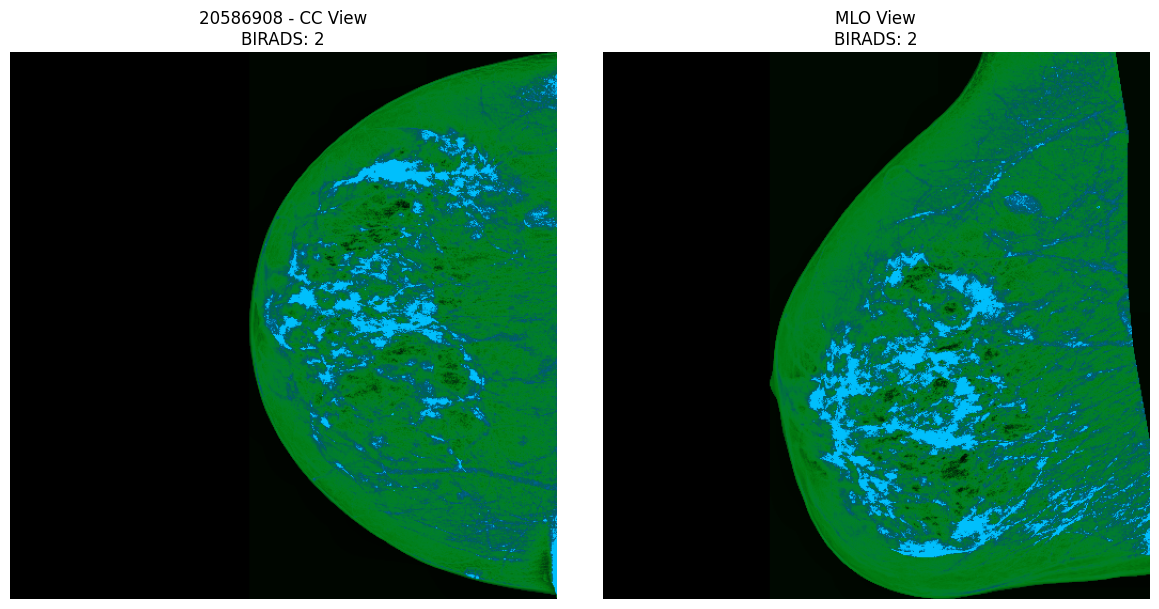

In [18]:
 # Create BIRADS mapping (from previous function)
birads_map = create_birads_mapping('/content/drive/MyDrive/inbreast/INbreast.xls')

    # Pair mammogram images
paired_mammograms = pair_mammogram_images(
        cc_image_dir='/content/drive/MyDrive/cc_new_image_512',
        mlo_image_dir='/content/drive/MyDrive/mlo_new_image_512',
        birads_mapping=birads_map
    )

    # Print details about paired images
print("Paired Mammograms:")
for patient_id, image_data in list(paired_mammograms.items())[:5]:
        print(f"Patient {patient_id}:")
        print(f"  CC Image: {image_data['cc_image']}")
        print(f"  MLO Image: {image_data['mlo_image']}")
        print(f"  BIRADS Category: {image_data['birads']}")



# View first image pair
view_mammogram_pair(paired_mammograms)





In [17]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(paired_mammograms, orient='index')

# Reset index to make patient ID a column
df.reset_index(inplace=True)
df.rename(columns={'index': 'patient_id'}, inplace=True)

# Display the DataFrame
print(df)

    patient_id                                           cc_image  \
0     20586908  /content/drive/MyDrive/cc_new_image_512/205869...   
1     20586934  /content/drive/MyDrive/cc_new_image_512/205869...   
2     20587054  /content/drive/MyDrive/cc_new_image_512/205870...   
3     20587148  /content/drive/MyDrive/cc_new_image_512/205871...   
4     20587174  /content/drive/MyDrive/cc_new_image_512/205871...   
..         ...                                                ...   
196   53587481  /content/drive/MyDrive/cc_new_image_512/535874...   
197   53587508  /content/drive/MyDrive/cc_new_image_512/535875...   
198   53587599  /content/drive/MyDrive/cc_new_image_512/535875...   
199   53587663  /content/drive/MyDrive/cc_new_image_512/535876...   
200   53587744  /content/drive/MyDrive/cc_new_image_512/535877...   

                                             mlo_image  birads  
0    /content/drive/MyDrive/mlo_new_image_512/20586...       2  
1    /content/drive/MyDrive/mlo_new_image

In [19]:
# After creating BIRADS mapping and pairing mammograms
birads_map = create_birads_mapping('/content/drive/MyDrive/inbreast/INbreast.xls')
paired_mammograms = pair_mammogram_images(
    cc_image_dir='/content/drive/MyDrive/cc_new_image_512',
    mlo_image_dir='/content/drive/MyDrive/mlo_new_image_512',
    birads_mapping=birads_map
)

# Convert to numpy arrays
cc_images, mlo_images, labels, patient_ids = create_mammogram_arrays(paired_mammograms)

Skipping row with NaN filename
Skipping row with NaN filename
No MLO view found for comparison part 2f1104b3cda7f145_MG_R
No MLO view found for comparison part dda3c6969a34ff8e_MG_L
Mammogram Dataset Summary:
Total number of paired mammograms: 201
BI-RADS Category Distribution:
BI-RADS 1: 32
BI-RADS 2: 108
BI-RADS 3: 11
BI-RADS 4: 22
BI-RADS 5: 28


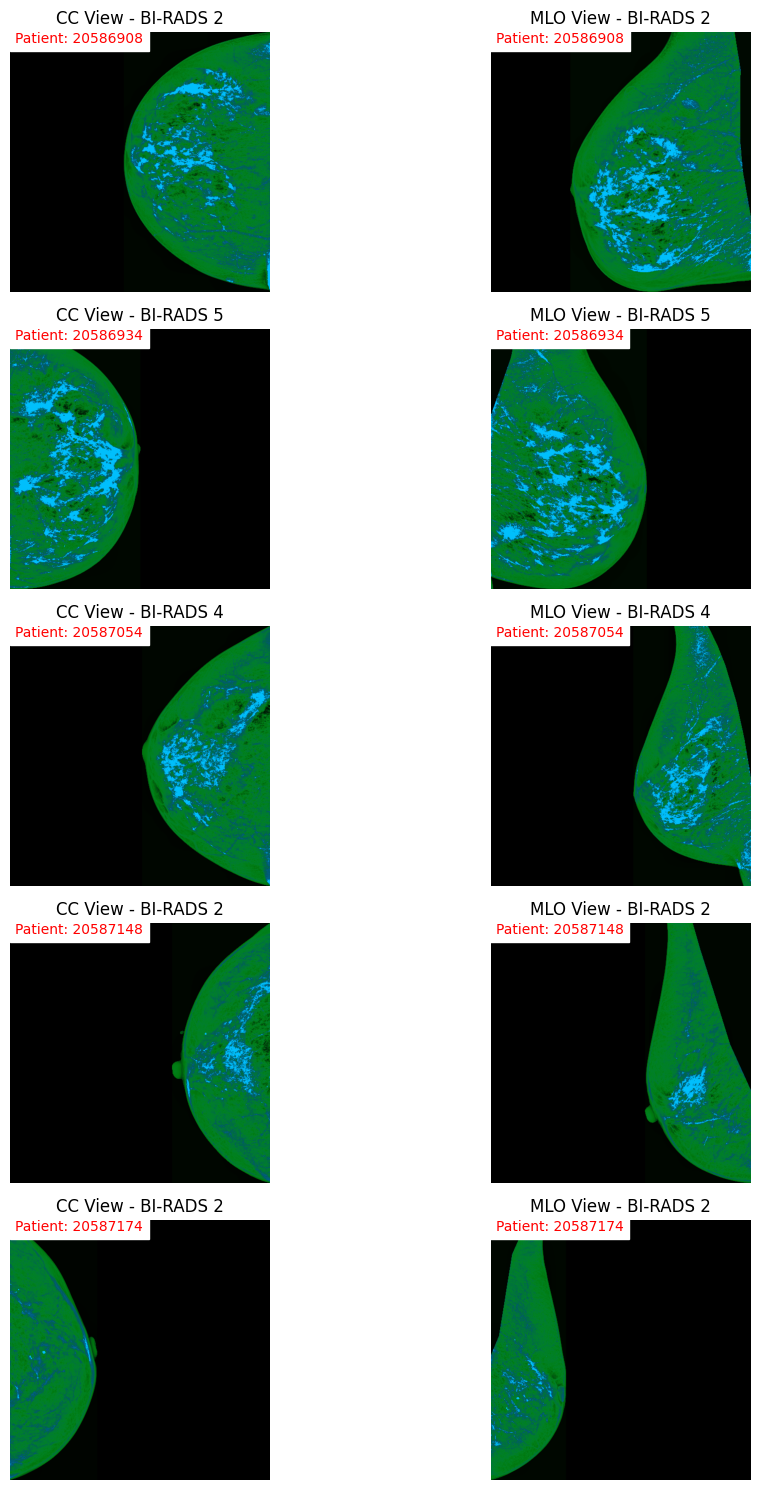

In [20]:
visualize_mammograms(cc_images, mlo_images, labels, patient_ids)

### Standardized images by flipping vertically

Dataset size: 201 patients
CC Images shape: (201, 512, 512, 3)
MLO Images shape: (201, 512, 512, 3)
Labels shape: (201,)


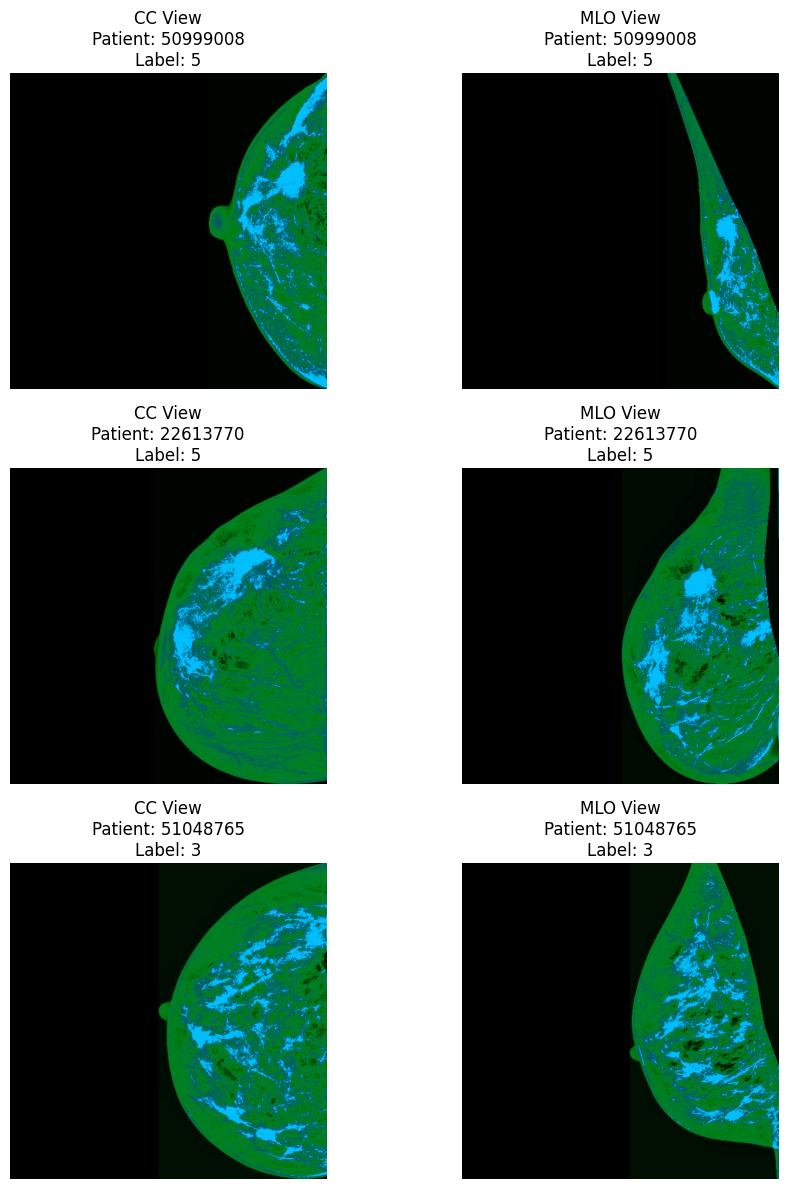

Standardized 103 images (flipped left breasts to right)
Could not find 0 patient IDs in the Excel file


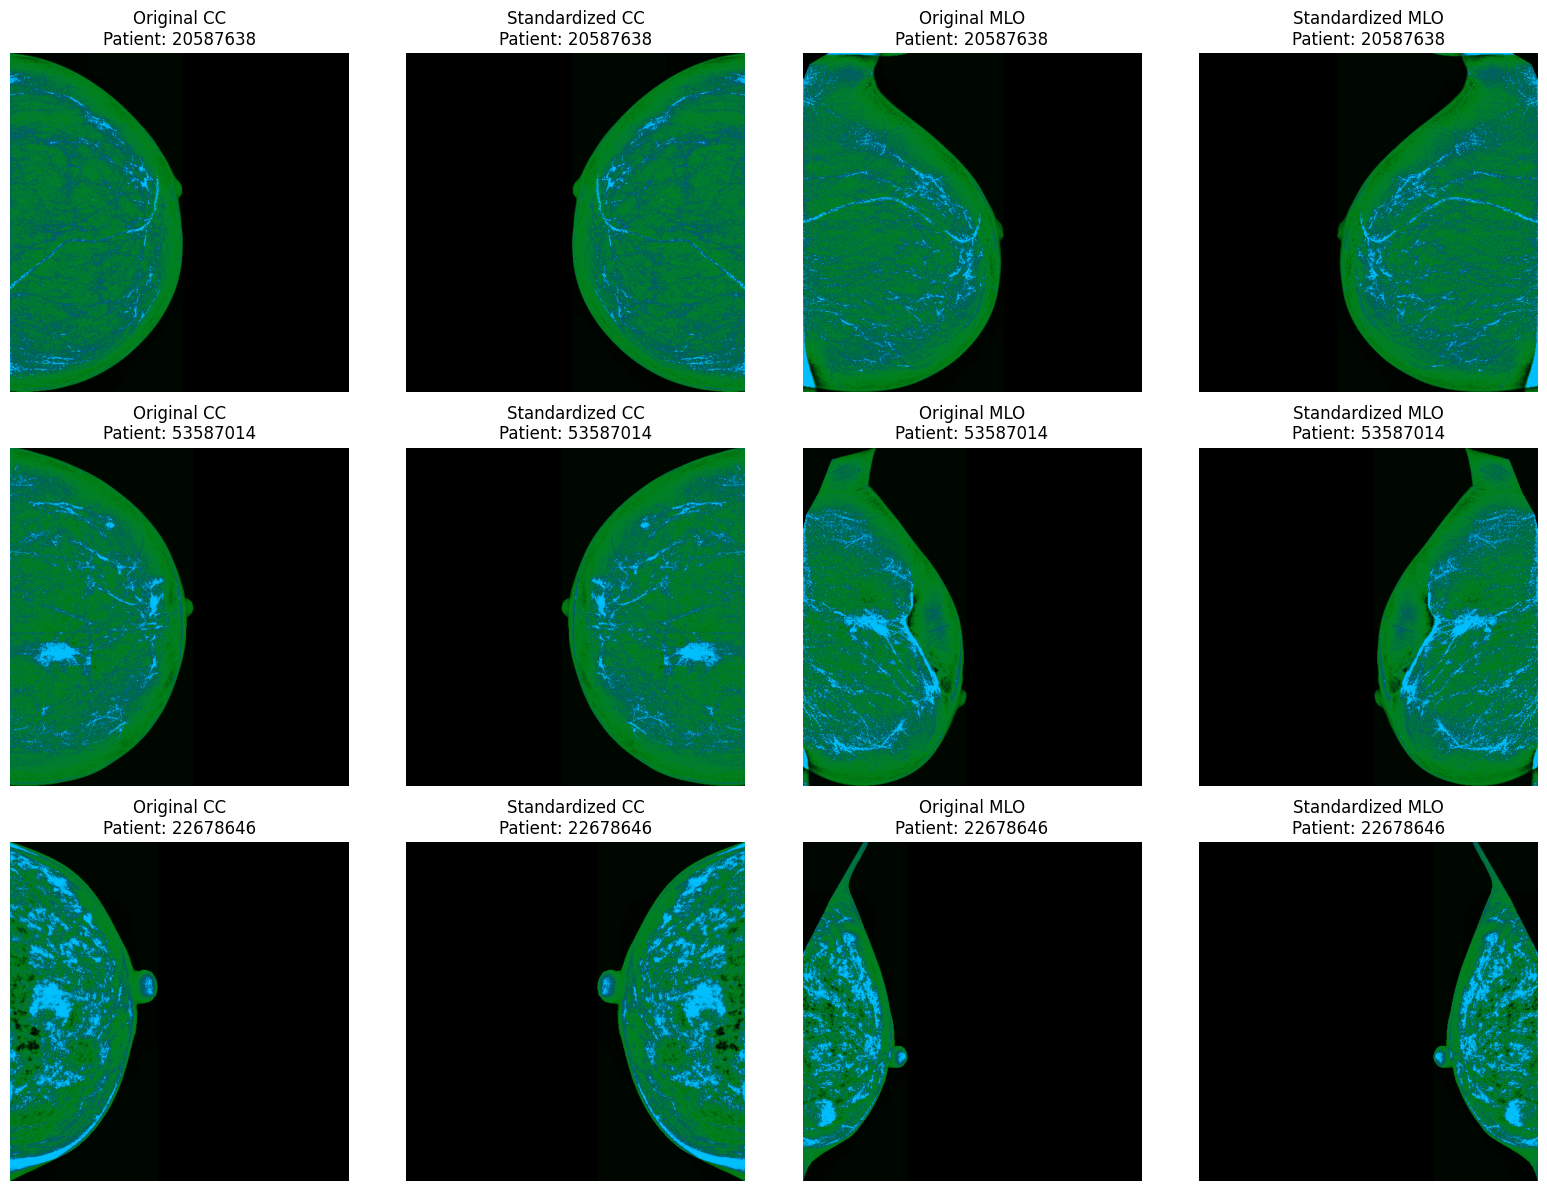

Created DataFrame with 201 samples
DataFrame columns: ['patient_id', 'cc_image', 'mlo_image', 'label', 'was_flipped']
Class distribution:
  - Class 2: 108 samples (53.73%)
  - Class 1: 32 samples (15.92%)
  - Class 5: 28 samples (13.93%)
  - Class 4: 22 samples (10.95%)
  - Class 3: 11 samples (5.47%)


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

def standardize_mammograms_to_right(cc_images, mlo_images, patient_ids, excel_path):
    """
    Standardize mammogram images so that all breasts appear on the right side of the image.

    Parameters:
    - cc_images: numpy array of CC view images
    - mlo_images: numpy array of MLO view images
    - patient_ids: list of patient IDs
    - excel_path: path to Excel file containing patient metadata with laterality info

    Returns:
    - standardized_cc: numpy array of standardized CC view images
    - standardized_mlo: numpy array of standardized MLO view images
    """
    # Load the Excel file containing laterality information
    df = pd.read_excel(excel_path)

    # Create copies of the arrays to store standardized images
    standardized_cc = np.copy(cc_images)
    standardized_mlo = np.copy(mlo_images)

    # Track which images were flipped
    flipped_indices = []
    not_found = []

    for i, patient_id in enumerate(patient_ids):
        # Excel might store the values with '.0' at the end, so we need to handle both cases
        # First try exact match
        patient_data = df[df['File Name'] == patient_id]

        # If not found, try adding '.0' to the patient_id
        if patient_data.empty:
            patient_data = df[df['File Name'] == f"{patient_id}.0"]

        # If still not found, try removing '.0' from the Excel values
        if patient_data.empty:
            # Convert Excel values to string and remove '.0' if present
            excel_values = df['File Name'].astype(str).str.replace('\.0$', '', regex=True)
            matches = excel_values == patient_id
            if matches.any():
                patient_data = df.loc[matches]

        if patient_data.empty:
            print(f"Warning: Patient ID {patient_id} not found in Excel file")
            not_found.append(patient_id)
            continue

        # Get laterality ('L' for left, 'R' for right) from 'Laterality' column
        laterality = patient_data['Laterality'].values[0]

        # If left breast, flip horizontally to make it appear on the right
        if laterality.upper() == 'L':
            standardized_cc[i] = np.fliplr(cc_images[i])
            standardized_mlo[i] = np.fliplr(mlo_images[i])
            flipped_indices.append(i)

    print(f"Standardized {len(flipped_indices)} images (flipped left breasts to right)")
    print(f"Could not find {len(not_found)} patient IDs in the Excel file")

    return standardized_cc, standardized_mlo, flipped_indices

def visualize_standardization(cc_images, mlo_images, standardized_cc, standardized_mlo, patient_ids, flipped_indices, num_samples=3):
    """
    Visualize the original and standardized mammogram images side by side.

    Parameters:
    - cc_images: original CC view images
    - mlo_images: original MLO view images
    - standardized_cc: standardized CC view images
    - standardized_mlo: standardized MLO view images
    - patient_ids: list of patient IDs
    - flipped_indices: indices of images that were flipped
    - num_samples: number of samples to visualize
    """
    # Randomly select some flipped images to display
    if len(flipped_indices) > num_samples:
        sample_indices = np.random.choice(flipped_indices, num_samples, replace=False)
    else:
        sample_indices = flipped_indices[:num_samples]

    # Create a figure with subplots
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))

    # If there's only one sample, adjust axes dimensions
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i, idx in enumerate(sample_indices):
        patient_id = patient_ids[idx]

        # Original CC view
        axes[i, 0].imshow(cc_images[idx], cmap='gray')
        axes[i, 0].set_title(f"Original CC\nPatient: {patient_id}")
        axes[i, 0].axis('off')

        # Standardized CC view
        axes[i, 1].imshow(standardized_cc[idx], cmap='gray')
        axes[i, 1].set_title(f"Standardized CC\nPatient: {patient_id}")
        axes[i, 1].axis('off')

        # Original MLO view
        axes[i, 2].imshow(mlo_images[idx], cmap='gray')
        axes[i, 2].set_title(f"Original MLO\nPatient: {patient_id}")
        axes[i, 2].axis('off')

        # Standardized MLO view
        axes[i, 3].imshow(standardized_mlo[idx], cmap='gray')
        axes[i, 3].set_title(f"Standardized MLO\nPatient: {patient_id}")
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

def visualize_samples(cc_images, mlo_images, patient_ids, labels, num_samples=5):
    """
    Visualize random samples from the dataset with their labels.

    Parameters:
    - cc_images: numpy array of CC view images
    - mlo_images: numpy array of MLO view images
    - patient_ids: list of patient IDs
    - labels: corresponding labels
    - num_samples: number of samples to visualize
    """
    # Randomly select samples to display
    sample_indices = np.random.choice(len(patient_ids), num_samples, replace=False)

    # Create a figure with subplots
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4 * num_samples))

    # If there's only one sample, adjust axes dimensions
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i, idx in enumerate(sample_indices):
        patient_id = patient_ids[idx]
        label = labels[idx]

        # CC view
        axes[i, 0].imshow(cc_images[idx], cmap='gray')
        axes[i, 0].set_title(f"CC View\nPatient: {patient_id}\nLabel: {label}")
        axes[i, 0].axis('off')

        # MLO view
        axes[i, 1].imshow(mlo_images[idx], cmap='gray')
        axes[i, 1].set_title(f"MLO View\nPatient: {patient_id}\nLabel: {label}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

def print_dataset_info(cc_images, mlo_images, labels, patient_ids):
    """
    Print information about the dataset.

    Parameters:
    - cc_images: numpy array of CC view images
    - mlo_images: numpy array of MLO view images
    - labels: corresponding labels
    - patient_ids: list of patient IDs
    """
    print(f"Dataset size: {len(patient_ids)} patients")
    print(f"CC Images shape: {cc_images.shape}")
    print(f"MLO Images shape: {mlo_images.shape}")
    print(f"Labels shape: {labels.shape}")

    # Print label distribution if labels are binary
    if np.all(np.isin(labels, [0, 1])):
        positive_count = np.sum(labels == 1)
        negative_count = np.sum(labels == 0)
        print(f"Label distribution:")
        print(f"  - Positive (1): {positive_count} ({positive_count/len(labels)*100:.2f}%)")
        print(f"  - Negative (0): {negative_count} ({negative_count/len(labels)*100:.2f}%)")

# Modified full pipeline function to return DataFrame
def process_mammogram_dataset(cc_images, mlo_images, labels, patient_ids, excel_path, visualize=True):
    """
    Process mammogram dataset by standardizing orientation.

    Parameters:
    - cc_images: numpy array of CC view images
    - mlo_images: numpy array of MLO view images
    - labels: numpy array of corresponding labels
    - patient_ids: list of patient IDs
    - excel_path: path to Excel file containing patient metadata
    - visualize: whether to visualize sample results

    Returns:
    - DataFrame containing processed data ready for further use
    """
    # Print dataset information
    print_dataset_info(cc_images, mlo_images, labels, patient_ids)

    # Visualize some original samples
    if visualize:
        visualize_samples(cc_images, mlo_images, patient_ids, labels, num_samples=3)

    # Step 1: Standardize images to have breasts on the right side
    standardized_cc, standardized_mlo, flipped_indices = standardize_mammograms_to_right(
        cc_images, mlo_images, patient_ids, excel_path
    )

    # Step 2: Visualize standardization results
    if visualize and len(flipped_indices) > 0:
        visualize_standardization(
            cc_images, mlo_images, standardized_cc, standardized_mlo,
            patient_ids, flipped_indices, num_samples=3
        )

    # Create a DataFrame with the processed data
    data = []
    for i in range(len(patient_ids)):
        data.append({
            'patient_id': patient_ids[i],
            'cc_image': standardized_cc[i],
            'mlo_image': standardized_mlo[i],
            'label': labels[i],
            'was_flipped': i in flipped_indices
        })

    processed_df = pd.DataFrame(data)

    print(f"Created DataFrame with {len(processed_df)} samples")
    print(f"DataFrame columns: {processed_df.columns.tolist()}")

    # Display class distribution
    class_counts = processed_df['label'].value_counts()
    print("Class distribution:")
    for label, count in class_counts.items():
        print(f"  - Class {label}: {count} samples ({count/len(processed_df)*100:.2f}%)")

    return processed_df

# Example of how to call the function (commented out to avoid execution)
processed_df = process_mammogram_dataset(cc_images, mlo_images, labels, patient_ids,
                                         excel_path="/content/drive/MyDrive/inbreast/INbreast.xls")

## Augmentation

Augmentation by avoiding duplicate augmentations

STARTING DATASET PROCESSING WORKFLOW WITH VALIDATION
Original dataset class distribution:
Class 1: 32 samples (15.92%)
Class 2: 108 samples (53.73%)
Class 3: 11 samples (5.47%)
Class 4: 22 samples (10.95%)
Class 5: 28 samples (13.93%)

After train/validation/test split:
Training set size: 139
Validation set size: 31
Test set size: 31

Training set class distribution:
Class 1: 22 samples (15.83%)
Class 2: 74 samples (53.24%)
Class 3: 7 samples (5.04%)
Class 4: 16 samples (11.51%)
Class 5: 20 samples (14.39%)

Validation set class distribution:
Class 1: 5 samples (16.13%)
Class 2: 17 samples (54.84%)
Class 3: 2 samples (6.45%)
Class 4: 3 samples (9.68%)
Class 5: 4 samples (12.90%)

Test set class distribution:
Class 1: 5 samples (16.13%)
Class 2: 17 samples (54.84%)
Class 3: 2 samples (6.45%)
Class 4: 3 samples (9.68%)
Class 5: 4 samples (12.90%)

Visualize dataset splits before augmentation:


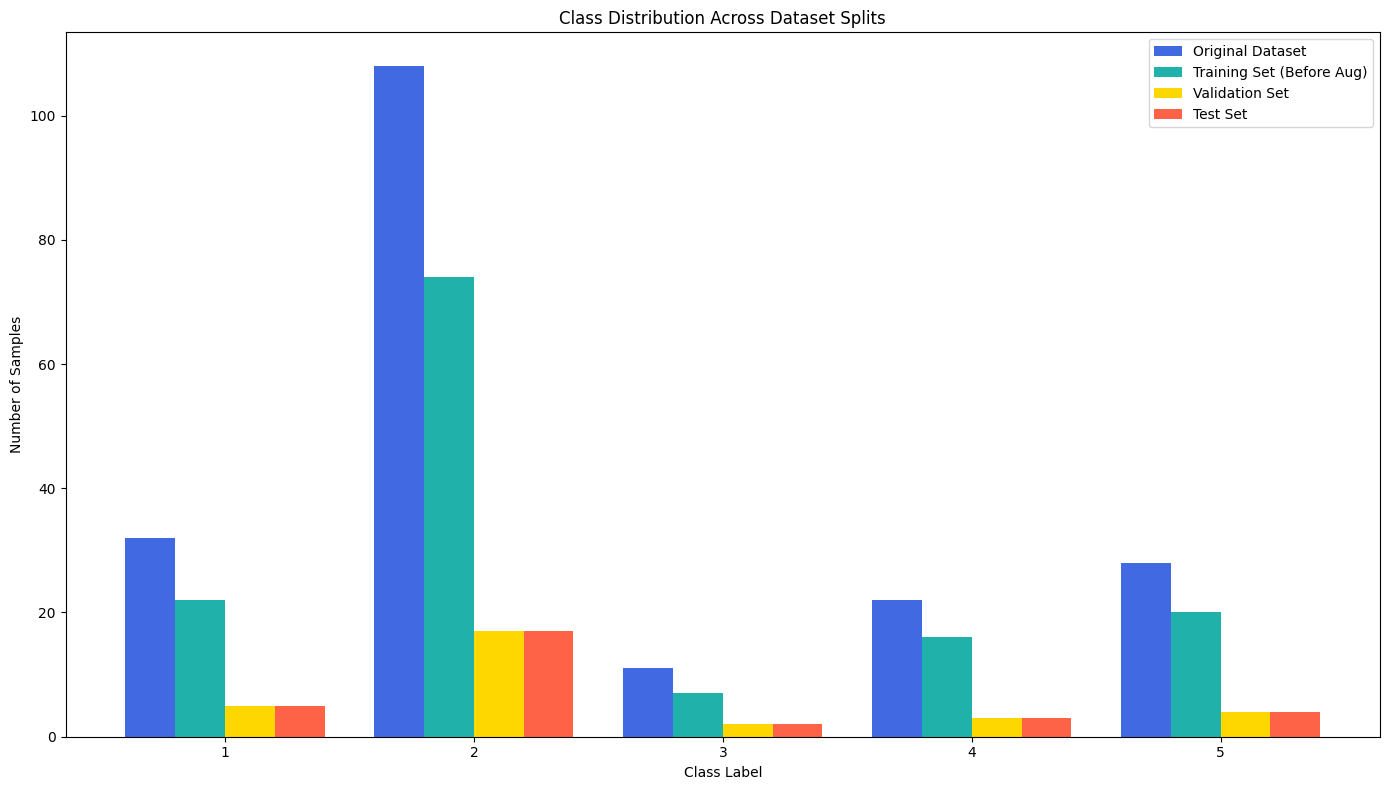


Augmenting only the training set data...

Processing class 2: Current count = 74, Target = 500
  Generating 426 augmented samples for class 2


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-21-dfe096f8923f>:35: UserWarning: Argument(s) 'value, shear_limit_x, shear_limit_y' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(


  All samples have reached maximum augmentations. Resetting augmentation history.

Processing class 1: Current count = 22, Target = 500
  Generating 478 augmented samples for class 1
  All samples have reached maximum augmentations. Resetting augmentation history.
  All samples have reached maximum augmentations. Resetting augmentation history.
  All samples have reached maximum augmentations. Resetting augmentation history.
  All samples have reached maximum augmentations. Resetting augmentation history.

Processing class 5: Current count = 20, Target = 500
  Generating 480 augmented samples for class 5
  All samples have reached maximum augmentations. Resetting augmentation history.
  All samples have reached maximum augmentations. Resetting augmentation history.
  All samples have reached maximum augmentations. Resetting augmentation history.
  All samples have reached maximum augmentations. Resetting augmentation history.

Processing class 4: Current count = 16, Target = 500
  Gene

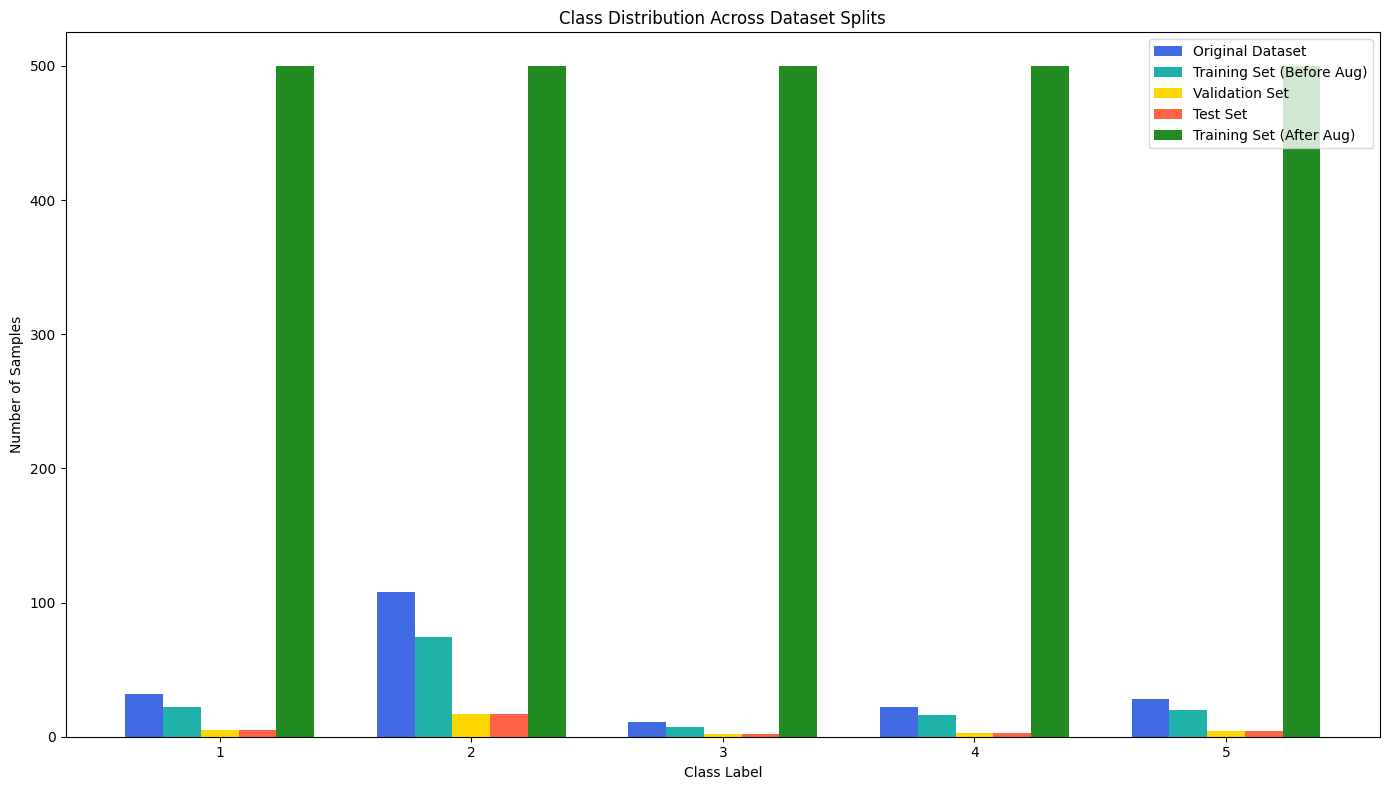


Workflow complete!
Original dataset size: 201
Training set size (before augmentation): 139
Training set size (after augmentation): 2500
Validation set size (unchanged): 31
Test set size (unchanged): 31


In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import uuid  # For generating unique identifiers for augmentations

def create_mammogram_augmentation(is_minority_class=False, augmentation_id=None):
    """
    Create an augmentation pipeline for mammogram images based on research parameters.
    Each pipeline instance gets a unique ID to track which augmentations were applied.

    Parameters:
    -----------
    is_minority_class : bool
        Whether this is for a minority class (unused but kept for compatibility)
    augmentation_id : str
        Unique identifier for this specific augmentation configuration

    Returns:
    --------
    tuple: (augmentation_pipeline, augmentation_id)
    """
    # Create a unique ID for this augmentation configuration if not provided
    if augmentation_id is None:
        augmentation_id = str(uuid.uuid4())

    # Implementing the augmentations from the research table, removing flipping and CLAHE
    augmentations = [
        # Rotation - 95% probability, Max Angle 15°
        A.Rotate(limit=15, p=0.95),

        # Shear - 60% probability, Max value 25°
        A.ShiftScaleRotate(
            shift_limit=0,  # No shift
            scale_limit=0,  # No scaling
            rotate_limit=0,  # No additional rotation
            interpolation=cv2.INTER_LINEAR,
            border_mode=cv2.BORDER_CONSTANT,
            value=0,
            shear_limit_x=(-25, 25),  # Shear along x-axis by max 25 degrees
            shear_limit_y=(-25, 25),  # Shear along y-axis by max 25 degrees
            p=0.6
        ),

        # Histogram Equalization - 60% probability
        A.Equalize(p=0.6),

        # Brightness - 80% probability, min value: 0.6, max value: 1.2
        A.RandomBrightnessContrast(
            brightness_limit=(0.6-1, 1.2-1),  # Albumentations uses relative change: values relative to 1
            contrast_limit=0,  # No contrast changes
            p=0.8
        )
    ]

    return A.Compose(augmentations), augmentation_id

def split_dataset_with_validation(df, test_size=0.15, val_size=0.15):
    """
    Split dataset into train/validation/test sets using stratification.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with mammogram data
    test_size : float
        Proportion of data to use for test set
    val_size : float
        Proportion of data to use for validation set

    Returns:
    --------
    tuple: (train_df, val_df, test_df)
    """
    print("Original dataset class distribution:")
    class_counts = df['label'].value_counts().sort_index()
    for label, count in class_counts.items():
        print(f"Class {label}: {count} samples ({count/len(df)*100:.2f}%)")

    # First, split off the test set
    train_val_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df['label'],
        random_state=42  # For reproducibility
    )

    # Calculate validation size relative to the train_val set
    relative_val_size = val_size / (1 - test_size)

    # Split the remaining data into train and validation sets
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=relative_val_size,
        stratify=train_val_df['label'],
        random_state=42  # For reproducibility
    )

    print("\nAfter train/validation/test split:")
    print(f"Training set size: {len(train_df)}")
    print(f"Validation set size: {len(val_df)}")
    print(f"Test set size: {len(test_df)}")

    print("\nTraining set class distribution:")
    train_counts = train_df['label'].value_counts().sort_index()
    for label, count in train_counts.items():
        print(f"Class {label}: {count} samples ({count/len(train_df)*100:.2f}%)")

    print("\nValidation set class distribution:")
    val_counts = val_df['label'].value_counts().sort_index()
    for label, count in val_counts.items():
        print(f"Class {label}: {count} samples ({count/len(val_df)*100:.2f}%)")

    print("\nTest set class distribution:")
    test_counts = test_df['label'].value_counts().sort_index()
    for label, count in test_counts.items():
        print(f"Class {label}: {count} samples ({count/len(test_df)*100:.2f}%)")

    return train_df, val_df, test_df

def augment_training_data(train_df, target_per_class=500):
    """
    Augment only the training data to balance classes, with tracking to avoid
    applying the same augmentation configuration multiple times to the same sample.
    """
    # First, make sure we're working with a clean dataset
    train_df = train_df.dropna(subset=['label']).copy()

    # Lists to store augmented data
    augmented_patient_ids = []
    augmented_cc_images = []
    augmented_mlo_images = []
    augmented_labels = []
    augmented_was_flipped = []

    # Dictionary to track which augmentations have been applied to which samples
    # Key: original sample index, Value: set of augmentation IDs applied to this sample
    sample_augmentation_history = {}

    # Get unique labels in the training set
    unique_labels = train_df['label'].unique()

    for label in unique_labels:
        # Filter data for this class
        class_df = train_df[train_df['label'] == label].reset_index(drop=True)
        current_count = len(class_df)

        print(f"\nProcessing class {label}: Current count = {current_count}, Target = {target_per_class}")

        # If we already have enough samples, randomly select target_per_class samples
        if current_count >= target_per_class:
            print(f"  Class {label} already has {current_count} samples, randomly selecting {target_per_class}")
            selected_indices = np.random.choice(current_count, target_per_class, replace=False)
            selected_df = class_df.iloc[selected_indices]

            augmented_patient_ids.extend(selected_df['patient_id'].tolist())
            augmented_cc_images.extend(selected_df['cc_image'].tolist())
            augmented_mlo_images.extend(selected_df['mlo_image'].tolist())
            augmented_labels.extend([label] * len(selected_df))
            augmented_was_flipped.extend(selected_df['was_flipped'].tolist())
        else:
            # Add all original samples
            augmented_patient_ids.extend(class_df['patient_id'].tolist())
            augmented_cc_images.extend(class_df['cc_image'].tolist())
            augmented_mlo_images.extend(class_df['mlo_image'].tolist())
            augmented_labels.extend([label] * len(class_df))
            augmented_was_flipped.extend(class_df['was_flipped'].tolist())

            # Calculate how many more are needed
            augment_needed = target_per_class - current_count
            print(f"  Generating {augment_needed} augmented samples for class {label}")

            # Generate augmentations
            augmented_count = 0
            max_attempts = augment_needed * 3  # Set a maximum number of attempts to prevent infinite loops
            attempts = 0

            # Initialize sample augmentation history for this class
            for i in range(len(class_df)):
                sample_augmentation_history[i] = set()

            while augmented_count < augment_needed and attempts < max_attempts:
                # Calculate how many more augmentations we need to generate
                remaining = augment_needed - augmented_count

                # Select a random index (without replacement if possible)
                available_indices = [i for i in range(len(class_df))
                                     if len(sample_augmentation_history[i]) < 5]  # Limit to 5 augmentations per sample

                if not available_indices:
                    # If all samples have reached the maximum number of augmentations, reset
                    print("  All samples have reached maximum augmentations. Resetting augmentation history.")
                    for i in range(len(class_df)):
                        sample_augmentation_history[i] = set()
                    available_indices = list(range(len(class_df)))

                idx = np.random.choice(available_indices)

                # Create a new augmentation configuration
                augmentation, aug_id = create_mammogram_augmentation()

                # Check if this exact augmentation has been applied to this sample before
                if aug_id in sample_augmentation_history[idx]:
                    attempts += 1
                    continue  # Skip this and try again

                # Get original data for this sample
                original_patient_id = class_df.iloc[idx]['patient_id']
                cc_img = class_df.iloc[idx]['cc_image']
                mlo_img = class_df.iloc[idx]['mlo_image']
                was_flipped = class_df.iloc[idx]['was_flipped']

                # Apply augmentation to both CC and MLO views
                augmented_cc = augmentation(image=cc_img)['image']
                augmented_mlo = augmentation(image=mlo_img)['image']

                # Store augmented data with explicit label
                augmented_patient_ids.append(f"{original_patient_id}_aug{augmented_count}")
                augmented_cc_images.append(augmented_cc)
                augmented_mlo_images.append(augmented_mlo)
                augmented_labels.append(label)
                augmented_was_flipped.append(was_flipped)

                # Record this augmentation as used for this sample
                sample_augmentation_history[idx].add(aug_id)

                augmented_count += 1
                attempts += 1

            if attempts >= max_attempts and augmented_count < augment_needed:
                print(f"  Warning: Reached maximum attempts ({max_attempts}) but only generated {augmented_count}/{augment_needed} augmentations")

    # Create augmented dataframe
    augmented_df = pd.DataFrame({
        'patient_id': augmented_patient_ids,
        'cc_image': augmented_cc_images,
        'mlo_image': augmented_mlo_images,
        'label': augmented_labels,
        'was_flipped': augmented_was_flipped
    })

    # Verify no NaN labels
    nan_count = augmented_df['label'].isna().sum()
    if nan_count > 0:
        print(f"WARNING: Found {nan_count} NaN labels in augmented data. Removing them.")
        augmented_df = augmented_df.dropna(subset=['label'])

    # Print augmentation summary
    print("\nAugmented Training Dataset Summary:")
    print(f"Total samples: {len(augmented_df)}")

    augmented_counts = augmented_df['label'].value_counts().sort_index()
    for class_label, count in augmented_counts.items():
        print(f"Class {class_label}: {count} samples ({count/len(augmented_df)*100:.2f}%)")

    return augmented_df

def visualize_dataset_distributions(original_df, train_df, val_df, test_df, augmented_train_df=None, save_path=None):
    """
    Visualize the class distribution across all dataset splits.
    """
    # Get unique labels from all datasets
    unique_labels = np.sort(np.unique(np.concatenate([
        original_df['label'].unique(),
        train_df['label'].unique(),
        val_df['label'].unique(),
        test_df['label'].unique()
    ])))

    # Count samples in each class for each dataset
    original_counts = [sum(original_df['label'] == label) for label in unique_labels]
    train_counts = [sum(train_df['label'] == label) for label in unique_labels]
    val_counts = [sum(val_df['label'] == label) for label in unique_labels]
    test_counts = [sum(test_df['label'] == label) for label in unique_labels]

    # Set up bar positions
    bar_width = 0.2
    if augmented_train_df is not None:
        bar_width = 0.15

    r1 = np.arange(len(unique_labels))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]

    # Create figure
    plt.figure(figsize=(14, 8))

    # Create bars
    plt.bar(r1, original_counts, width=bar_width, label='Original Dataset', color='royalblue')
    plt.bar(r2, train_counts, width=bar_width, label='Training Set (Before Aug)', color='lightseagreen')
    plt.bar(r3, val_counts, width=bar_width, label='Validation Set', color='gold')
    plt.bar(r4, test_counts, width=bar_width, label='Test Set', color='tomato')

    # Add augmented training set if provided
    if augmented_train_df is not None:
        r5 = [x + bar_width for x in r4]
        aug_train_counts = [sum(augmented_train_df['label'] == label) for label in unique_labels]
        plt.bar(r5, aug_train_counts, width=bar_width, label='Training Set (After Aug)', color='forestgreen')
        center_offset = bar_width * 2
    else:
        center_offset = bar_width * 1.5

    # Add labels and title
    plt.xlabel('Class Label')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution Across Dataset Splits')
    plt.xticks([r + center_offset for r in range(len(unique_labels))], unique_labels)

    # Add legend
    plt.legend()

    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Distribution plot saved to {save_path}")

    plt.tight_layout()
    plt.show()

def full_workflow_with_validation(df, test_size=0.15, val_size=0.15, target_per_class=500):
    """
    Run the complete workflow: split dataset into train/val/test, augment training set, and visualize results.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with mammogram data
    test_size : float
        Proportion of data to use for test set
    val_size : float
        Proportion of data to use for validation set
    target_per_class : int
        Target number of samples for each class in the training set after augmentation

    Returns:
    --------
    tuple: (train_df, val_df, test_df, augmented_train_df)
    """
    print("=" * 60)
    print("STARTING DATASET PROCESSING WORKFLOW WITH VALIDATION")
    print("=" * 60)

    # Split dataset into train/val/test
    train_df, val_df, test_df = split_dataset_with_validation(df, test_size, val_size)

    # Visualize class distribution before augmentation
    print("\nVisualize dataset splits before augmentation:")
    visualize_dataset_distributions(df, train_df, val_df, test_df)

    # Augment only the training set
    print("\nAugmenting only the training set data...")
    augmented_train_df = augment_training_data(train_df, target_per_class)

    # Visualize class distribution after augmentation
    print("\nVisualize dataset splits after augmentation:")
    visualize_dataset_distributions(df, train_df, val_df, test_df, augmented_train_df)

    print("\nWorkflow complete!")
    print(f"Original dataset size: {len(df)}")
    print(f"Training set size (before augmentation): {len(train_df)}")
    print(f"Training set size (after augmentation): {len(augmented_train_df)}")
    print(f"Validation set size (unchanged): {len(val_df)}")
    print(f"Test set size (unchanged): {len(test_df)}")

    return train_df, val_df, test_df, augmented_train_df

# Example usage
train_df, val_df, test_df, augmented_train_df = full_workflow_with_validation(processed_df, test_size=0.15, val_size=0.15, target_per_class=500)

In [ ]:
print(augmented_train_df.columns)

Index(['patient_id', 'cc_image', 'mlo_image', 'label', 'was_flipped'], dtype='object')


In [ ]:
# Before augmentation
print("NaN labels in original training data:", train_df['label'].isna().sum())

NaN labels in original training data: 0


In [ ]:
augmented_train_df.head()


patient_id                                           cc_image  \
0   50998231  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
1   50997026  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
2   24065611  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
3   22670124  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
4   50993643  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   

                                           mlo_image  label  was_flipped  
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      2         True  
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      2        False  
2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      2        False  
3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      2         True  
4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      2         True

In [ ]:
# Before augmentation
print("NaN labels in  augmented training data:", augmented_train_df['label'].isna().sum())

NaN labels in  augmented training data: 0


In [16]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 118.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 111.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 122.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.8 MB/s eta 0:00:00


Baseline

Model: "Baseline_MultiView_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cc_input            │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlo_input           │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 256, 256,  │          0 │ cc_input[0][0]    │
│ (AveragePooling2D)  │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 256, 256,  │          0 │ mlo_input[0][0]   │
│ (AveragePooling2D)  │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │        896 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ max_pooling2d_2[

 Total params: 204,293 (798.02 KB)

 Trainable params: 203,781 (796.02 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.2372 - auc: 0.5459 - loss: 2.4567
Epoch 1: val_accuracy improved from -inf to 0.54839, saving model to baseline_model_best.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 491ms/step - accuracy: 0.2372 - auc: 0.5460 - loss: 2.4556 - val_accuracy: 0.5484 - val_auc: 0.6965 - val_loss: 2.0339 - learning_rate: 5.0000e-04
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.3050 - auc: 0.6024 - loss: 1.9569
Epoch 2: val_accuracy did not improve from 0.54839
157/157 ━━━━━━━━━━━━━━━━━━━━ 77s 484ms/step - accuracy: 0.3049 - auc: 0.6024 - loss: 1.9566 - val_accuracy: 0.5161 - val_auc: 0.7274 - val_loss: 1.8135 - learning_rate: 5.0000e-04
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.3116 - auc: 0.6256 - loss: 1.7659
Epoch 3: val_accuracy did not improve from 0.54839
157/157 ━━━━━━━━━━━━━━━━━━━━ 78s 488ms/step - accuracy: 0.3116 - auc: 0.6256 - loss: 1.7658 - val_accuracy: 0.4839 - val_auc: 0.7114 - val_loss: 1.6536 - learning_rate: 5.0000e-04
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.3479 - auc: 0.6527 - loss: 1.6650
Epoch 4: val_accuracy did not improve from 0.54839
1

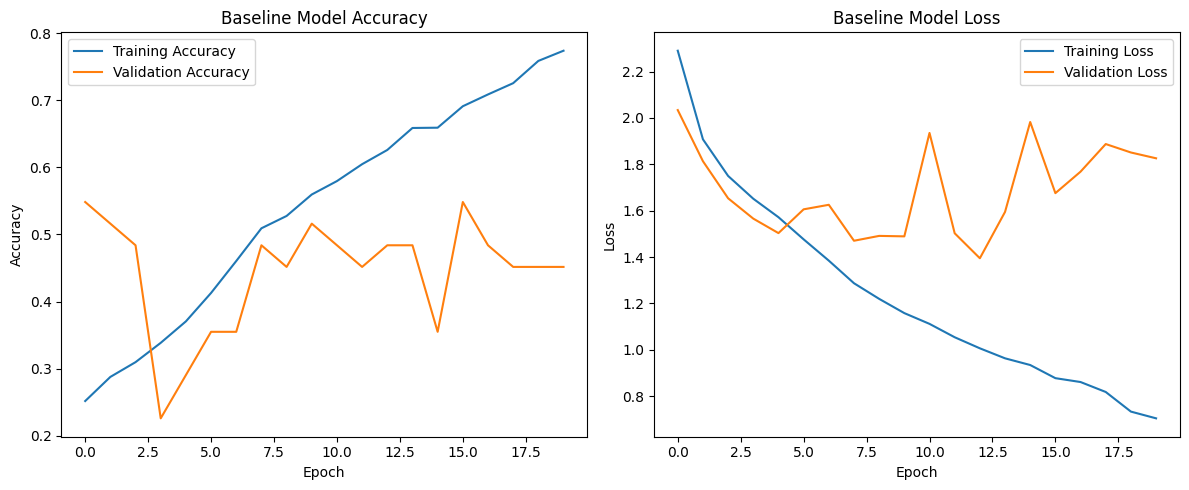

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.3837 - auc: 0.7559 - loss: 1.5976
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
Baseline Test Loss: 1.5999
Baseline Test Accuracy: 0.4194
Baseline Test AUC: 0.7745


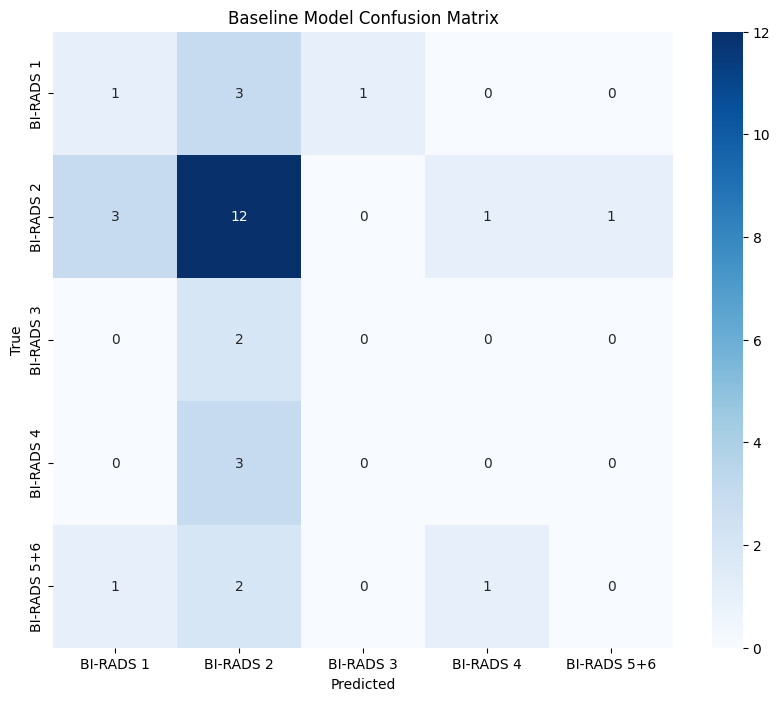

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

def create_baseline_multiview_model(input_shape=(1024, 1024, 3), num_classes=5):
    """
    Creates a simple baseline model for mammogram classification with significantly
    fewer parameters than ResNet50 to serve as a performance benchmark.

    Args:
        input_shape: Shape of input images (height, width, channels)
        num_classes: Number of classes for classification

    Returns:
        A Keras Model that takes CC and MLO views as input and outputs class probabilities
    """
    # Input layers
    cc_input = Input(shape=input_shape, name='cc_input')
    mlo_input = Input(shape=input_shape, name='mlo_input')

    # Initial downsampling to reduce memory footprint
    cc_downsampled = AveragePooling2D(pool_size=(4, 4))(cc_input)  # Reduces to 256x256
    mlo_downsampled = AveragePooling2D(pool_size=(4, 4))(mlo_input)  # Reduces to 256x256

    # Simple convolutional feature extractor - same for both views
    def feature_extractor(x):
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x)
        x = GlobalAveragePooling2D()(x)
        return x

    # Extract features from both views
    cc_features = feature_extractor(cc_downsampled)
    mlo_features = feature_extractor(mlo_downsampled)

    # Concatenate features from both views
    fused_features = Concatenate()([cc_features, mlo_features])

    # Classification head with regularization
    x = BatchNormalization()(fused_features)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=[cc_input, mlo_input], outputs=outputs, name='Baseline_MultiView_Model')

    return model

def compile_baseline_model(model):
    """Compiles the baseline model with appropriate optimizer and metrics"""
    optimizer = Adam(learning_rate=0.0005)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', AUC()]
    )
    return model

def train_baseline_model(model, train_df, val_df, batch_size=16, epochs=20):
    """
    Trains the baseline multiview model with provided dataframes

    Args:
        model: Compiled Keras model
        train_df: DataFrame containing training data (cc_image, mlo_image, label)
        val_df: DataFrame containing validation data (cc_image, mlo_image, label)
        batch_size: Batch size for training
        epochs: Number of epochs to train

    Returns:
        Trained model and training history
    """
    # Make copies to avoid modifying original data
    train_df = train_df.copy()
    val_df = val_df.copy()

    # Normalize labels to 0-based indexing if needed
    if np.min(train_df['label']) == 1:
        train_df['label'] = train_df['label'] - 1
        val_df['label'] = val_df['label'] - 1

    # Prepare training data
    cc_train = np.array(train_df['cc_image'].tolist())
    mlo_train = np.array(train_df['mlo_image'].tolist())

    # Simple normalization
    cc_train = cc_train / 255.0
    mlo_train = mlo_train / 255.0

    # One-hot encode the labels
    num_classes = model.output_shape[-1]
    y_train = tf.keras.utils.to_categorical(train_df['label'], num_classes=num_classes)

    # Prepare validation data
    cc_val = np.array(val_df['cc_image'].tolist())
    mlo_val = np.array(val_df['mlo_image'].tolist())

    # Apply same normalization
    cc_val = cc_val / 255.0
    mlo_val = mlo_val / 255.0

    y_val = tf.keras.utils.to_categorical(val_df['label'], num_classes=num_classes)

    # Define callbacks for efficient training
    callbacks = [
        ModelCheckpoint(
            'baseline_model_best.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        )
    ]

    # Train the model
    history = model.fit(
        x=[cc_train, mlo_train],
        y=y_train,
        validation_data=([cc_val, mlo_val], y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

def evaluate_baseline_model(model, test_df, class_names=None):
    """
    Evaluates the baseline model using test dataframe

    Args:
        model: Trained Keras model
        test_df: DataFrame containing test data (cc_image, mlo_image, label)
        class_names: Names of the classes (optional)

    Returns:
        Dictionary containing evaluation metrics
    """
    if class_names is None:
        class_names = ['BI-RADS 1', 'BI-RADS 2', 'BI-RADS 3', 'BI-RADS 4', 'BI-RADS 5+6']

    # Make a copy to avoid modifying the original dataframe
    test_df = test_df.copy()

    # Adjust labels to 0-based indexing if needed
    if np.min(test_df['label']) == 1:
        test_df['label'] = test_df['label'] - 1

    # Prepare test data
    cc_test = np.array(test_df['cc_image'].tolist())
    mlo_test = np.array(test_df['mlo_image'].tolist())

    # Apply same normalization as in training
    cc_test = cc_test / 255.0
    mlo_test = mlo_test / 255.0

    y_test_labels = test_df['label']
    num_classes = model.output_shape[-1]
    y_test = tf.keras.utils.to_categorical(y_test_labels, num_classes=num_classes)

    # Evaluate model
    test_loss, test_acc, test_auc = model.evaluate(
        [cc_test, mlo_test],
        y_test,
        batch_size=16,
        verbose=1
    )

    # Generate predictions
    y_pred_prob = model.predict([cc_test, mlo_test], batch_size=16)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Classification report
    report = classification_report(
        y_test_labels,
        y_pred,
        target_names=class_names,
        output_dict=True
    )

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test_labels, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Baseline Model Confusion Matrix')
    plt.savefig('baseline_confusion_matrix.png')

    return {
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'test_auc': test_auc,
        'report': report,
        'confusion_matrix': conf_matrix
    }

def plot_baseline_training_history(history):
    """Plots the training history of the baseline model"""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Baseline Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Baseline Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('baseline_training_history.png')
    plt.show()

# Example usage
if __name__ == "__main__":
    # Set random seed for reproducibility
    tf.random.set_seed(42)

    # Define parameters
    input_shape = (1024, 1024, 3)
    num_classes = 5
    batch_size = 16
    epochs = 20

    # Create model
    baseline_model = create_baseline_multiview_model(
        input_shape=input_shape,
        num_classes=num_classes
    )
    baseline_model = compile_baseline_model(baseline_model)

    # Print model summary
    baseline_model.summary()

    # Note: Replace the following with your actual dataframes
    trained_model, history = train_baseline_model(
         baseline_model,
         augmented_train_df,
         val_df,
         batch_size=batch_size,
         epochs=epochs
    )

    # Plot training history
    plot_baseline_training_history(history)

    # Evaluate model on test set
    evaluation = evaluate_baseline_model(
         trained_model,
         test_df
    )

    # Print evaluation results
    print(f"Baseline Test Loss: {evaluation['test_loss']:.4f}")
    print(f"Baseline Test Accuracy: {evaluation['test_accuracy']:.4f}")
    print(f"Baseline Test AUC: {evaluation['test_auc']:.4f}")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Add, Multiply, Activation
from tensorflow.keras.layers import Reshape, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

def create_view_feature_extractor(input_shape=(1024, 1024, 3), name_prefix=""):
    """
    Creates a feature extractor with reduced capacity to avoid overfitting
    """
    inputs = Input(shape=input_shape)

    # Initial aggressive downsampling to reduce memory footprint and parameters
    x = AveragePooling2D(pool_size=(8, 8))(inputs)  # 128x128

    # First block - reduced filters
    x = Conv2D(16, (3, 3), padding='same', activation='relu',
               kernel_regularizer=l2(0.001), name=f'{name_prefix}_conv1_1')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn1_1')(x)
    x = Dropout(0.2)(x)  # Add dropout early
    x = Conv2D(16, (3, 3), padding='same', activation='relu',
               kernel_regularizer=l2(0.001), name=f'{name_prefix}_conv1_2')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn1_2')(x)
    x = MaxPooling2D((2, 2), name=f'{name_prefix}_pool1')(x)  # 64x64

    # Second block - reduced filters and added regularization
    x = Conv2D(32, (3, 3), padding='same', activation='relu',
               kernel_regularizer=l2(0.001), name=f'{name_prefix}_conv2_1')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn2_1')(x)
    x = Dropout(0.3)(x)  # Increase dropout
    x = Conv2D(32, (3, 3), padding='same', activation='relu',
               kernel_regularizer=l2(0.001), name=f'{name_prefix}_conv2_2')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn2_2')(x)
    x = MaxPooling2D((2, 2), name=f'{name_prefix}_pool2')(x)  # 32x32

    # Third block - simplified with fewer filters
    x = Conv2D(64, (3, 3), padding='same', activation='relu',
               kernel_regularizer=l2(0.001), name=f'{name_prefix}_conv3_1')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn3_1')(x)
    x = Dropout(0.4)(x)  # Aggressive dropout
    x = MaxPooling2D((2, 2), name=f'{name_prefix}_pool3')(x)  # 16x16

    # Global features
    x = GlobalAveragePooling2D(name=f'{name_prefix}_gap')(x)

    # Return both the model and the output features
    model = Model(inputs=inputs, outputs=x, name=f'{name_prefix}_encoder')
    return model

def simplified_cross_view_fusion(cc_features, mlo_features):
    """
    Simplified cross-view fusion to reduce complexity
    """
    # Simple concatenation with dropout
    fused = Concatenate()([cc_features, mlo_features])
    fused = Dropout(0.5)(fused)  # Heavy dropout after fusion

    return fused

def create_improved_multiview_model(input_shape=(1024, 1024, 3), num_classes=5):
    """
    Creates a simplified model for mammogram classification with reduced capacity
    to prevent overfitting.
    """
    # Input layers
    cc_input = Input(shape=input_shape, name='cc_input')
    mlo_input = Input(shape=input_shape, name='mlo_input')

    # Create feature extractors for each view
    cc_encoder = create_view_feature_extractor(input_shape, name_prefix="cc")
    mlo_encoder = create_view_feature_extractor(input_shape, name_prefix="mlo")

    # Extract features from both views
    cc_features = cc_encoder(cc_input)
    mlo_features = mlo_encoder(mlo_input)

    # Simplified fusion
    fused_features = simplified_cross_view_fusion(cc_features, mlo_features)

    # Classification head with strong regularization
    x = BatchNormalization()(fused_features)

    # Simplify dense layers - just one layer with fewer neurons
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Final classification layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=[cc_input, mlo_input], outputs=outputs, name='Simplified_MultiView_Model')

    return model

def compile_improved_model(model):
    """Compiles the improved model with appropriate optimizer and metrics"""
    # Use smaller learning rate
    optimizer = Adam(learning_rate=0.0001)  # Reduced learning rate

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', AUC()]
    )
    return model

def train_improved_model(model, train_df, val_df, batch_size=16, epochs=30):
    """
    Trains the improved multiview model with provided dataframes

    Args:
        model: Compiled Keras model
        train_df: DataFrame containing training data (cc_image, mlo_image, label)
        val_df: DataFrame containing validation data (cc_image, mlo_image, label)
        batch_size: Batch size for training
        epochs: Number of epochs to train

    Returns:
        Trained model and training history
    """
    # Make copies to avoid modifying original data
    train_df = train_df.copy()
    val_df = val_df.copy()

    # Normalize labels to 0-based indexing if needed
    if np.min(train_df['label']) == 1:
        train_df['label'] = train_df['label'] - 1
        val_df['label'] = val_df['label'] - 1

    # Prepare training data
    cc_train = np.array(train_df['cc_image'].tolist())
    mlo_train = np.array(train_df['mlo_image'].tolist())

    # Better normalization - center and scale
    cc_train = (cc_train - 127.5) / 127.5
    mlo_train = (mlo_train - 127.5) / 127.5

    # One-hot encode the labels
    num_classes = model.output_shape[-1]
    y_train = tf.keras.utils.to_categorical(train_df['label'], num_classes=num_classes)

    # Prepare validation data
    cc_val = np.array(val_df['cc_image'].tolist())
    mlo_val = np.array(val_df['mlo_image'].tolist())

    # Apply same normalization
    cc_val = (cc_val - 127.5) / 127.5
    mlo_val = (mlo_val - 127.5) / 127.5

    y_val = tf.keras.utils.to_categorical(val_df['label'], num_classes=num_classes)

    # Define callbacks for efficient training
    callbacks = [
        ModelCheckpoint(
            'simplified_model_best.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=15,  # More patience to ensure convergence
            restore_best_weights=True,
            verbose=1
        )
    ]

    # Train the model
    history = model.fit(
        x=[cc_train, mlo_train],
        y=y_train,
        validation_data=([cc_val, mlo_val], y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

def evaluate_model(model, test_df, class_names=None):
    """
    Evaluates the model using test dataframe

    Args:
        model: Trained Keras model
        test_df: DataFrame containing test data (cc_image, mlo_image, label)
        class_names: Names of the classes (optional)

    Returns:
        Dictionary containing evaluation metrics
    """
    if class_names is None:
        class_names = ['BI-RADS 1', 'BI-RADS 2', 'BI-RADS 3', 'BI-RADS 4', 'BI-RADS 5+6']

    # Make a copy to avoid modifying the original dataframe
    test_df = test_df.copy()

    # Adjust labels to 0-based indexing if needed
    if np.min(test_df['label']) == 1:
        test_df['label'] = test_df['label'] - 1

    # Prepare test data
    cc_test = np.array(test_df['cc_image'].tolist())
    mlo_test = np.array(test_df['mlo_image'].tolist())

    # Apply same normalization as in training
    cc_test = (cc_test - 127.5) / 127.5
    mlo_test = (mlo_test - 127.5) / 127.5

    y_test_labels = test_df['label']
    num_classes = model.output_shape[-1]
    y_test = tf.keras.utils.to_categorical(y_test_labels, num_classes=num_classes)

    # Evaluate model
    test_loss, test_acc, test_auc = model.evaluate(
        [cc_test, mlo_test],
        y_test,
        batch_size=16,
        verbose=1
    )

    # Generate predictions
    y_pred_prob = model.predict([cc_test, mlo_test], batch_size=16)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Classification report
    report = classification_report(
        y_test_labels,
        y_pred,
        target_names=class_names,
        output_dict=True
    )

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test_labels, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Simplified Model Confusion Matrix')
    plt.savefig('simplified_confusion_matrix.png')

    return {
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'test_auc': test_auc,
        'report': report,
        'confusion_matrix': conf_matrix
    }

def plot_training_history(history):
    """Plots the training history of the model"""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('simplified_training_history.png')
    plt.show()

# Example usage (preserving the original workflow)
if __name__ == "__main__":
    # Set random seed for reproducibility
    tf.random.set_seed(42)

    # Define parameters
    input_shape = (1024, 1024, 3)
    num_classes = 5
    batch_size = 16  # Keep original batch size
    epochs = 30

    # Create model
    simplified_model = create_improved_multiview_model(
        input_shape=input_shape,
        num_classes=num_classes
    )
    simplified_model = compile_improved_model(simplified_model)

    # Print model summary
    simplified_model.summary()

    # Train model with the augmented data as in original code
    trained_model, history = train_improved_model(
        simplified_model,
        augmented_train_df,  # Use augmented training data as specified
        val_df,              # Use validation data as specified
        batch_size=batch_size,
        epochs=epochs
    )

    # Plot training history
    plot_training_history(history)

    # Evaluate model on test set
    evaluation = evaluate_model(
        trained_model,
        test_df           # Use test data as specified for evaluation
    )

    # Print evaluation results
    print(f"Simplified Test Loss: {evaluation['test_loss']:.4f}")
    print(f"Simplified Test Accuracy: {evaluation['test_accuracy']:.4f}")
    print(f"Simplified Test AUC: {evaluation['test_auc']:.4f}")

Model: "Simplified_MultiView_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cc_input            │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlo_input           │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cc_encoder          │ (None, 64)        │     35,792 │ cc_input[0][0]    │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlo_encoder         │ (None, 64)        │     35,792 │ mlo_input[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ cc_encoder[0][0], │
│ (Concatenate)       │                   │            │ mlo_encoder[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 128)       │          0 │ concatenate_1[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dropout_15[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5)         │        325 │ dropout_16[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 80,933 (316.14 KB)

 Trainable params: 79,909 (312.14 KB)

 Non-trainable params: 1,024 (4.00 KB)

KeyboardInterrupt: 

In [26]:
augmented_train_df.columns
augmented_train_df.head()

patient_id                                           cc_image  \
0   50998231  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
1   50997026  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
2   24065611  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
3   22670124  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
4   50993643  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   

                                           mlo_image  label  was_flipped  
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      2         True  
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      2        False  
2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      2        False  
3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      2         True  
4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      2         True

Hierarchical

Model 1

Training dataframe shape: (2500, 5)
Training dataframe columns: ['patient_id', 'cc_image', 'mlo_image', 'label', 'was_flipped']
Type of first CC image entry: <class 'numpy.ndarray'>


Model: "Hierarchical_BIRADS_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cc_input            │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlo_input           │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cc_encoder          │ (None, 64)        │     35,792 │ cc_input[0][0]    │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlo_encoder         │ (None, 64)        │     35,792 │ mlo_input[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ cc_encoder[0][0], │
│ (Concatenate)       │                   │            │ mlo_encoder[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ level1_bn1          │ (None, 128)       │        512 │ dropout_6[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ level2_bn1          │ (None, 128)       │        512 │ dropout_6[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ level3_bn1          │ (None, 128)       │        512 │ dropout_6[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ level4_bn1          │ (None, 128)       │        512 │ dropout_6[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ level1_dense1       │ (None, 64)        │      8,256 │ level1_bn1[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ level2_dense1       │ (None, 64)        │      8,256 │ level2_bn1[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ level3_dense1       │ (None, 64)        │      8,256 │ level3_bn1[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ level4_dense1       │ (None, 64)        │      8,256 │ level4_bn1[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ level1_bn2          │ (None, 64)        │        256 │ level1_dense1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ level2_bn2          │ (None, 64)        │        256 │ level2_dense1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ level3_bn2          │ (None, 64)        │        256 │ level3_dense1[0]… │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 107,940 (421.64 KB)

 Trainable params: 105,764 (413.14 KB)

 Non-trainable params: 2,176 (8.50 KB)

Train data shape: (2500, 5)
Train label range: 0 to 4
CC train shape: (2500, 512, 512, 3)
MLO train shape: (2500, 512, 512, 3)
Preparing hierarchical labels...
Starting model training...
Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - level1_output_accuracy: 0.5234 - level1_output_auc: 0.5201 - level1_output_loss: 0.9983 - level2_output_accuracy: 0.4844 - level2_output_auc_1: 0.4773 - level2_output_loss: 1.0203 - level3_output_accuracy: 0.5073 - level3_output_auc_2: 0.4897 - level3_output_loss: 1.0925 - level4_output_accuracy: 0.5218 - level4_output_auc_3: 0.5193 - level4_output_loss: 0.9862 - loss: 7.6804
Epoch 1: val_loss improved from inf to 6.23863, saving model to hierarchical_model_best.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 49s 102ms/step - level1_output_accuracy: 0.5234 - level1_output_auc: 0.5201 - level1_output_loss: 0.9982 - level2_output_accuracy: 0.4844 - level2_output_auc_1: 0.4773 - level2_output_loss: 1.0203 - level3_output_accuracy: 0.5073 - level3_output_auc_2: 0.4898 - level3_output_loss: 1.0924 - level4_output_accuracy: 0.5218 - level4_output_auc_3: 0.5193 - level4_output_loss: 0.9861 - loss: 7.6800 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.6038 - val_level1_output_loss: 0.4776 - val_level2_output_accuracy: 0.7097 - val_level2_output_auc_1: 0.4848 - val_level2_output_loss: 0.6111 - val_level3_output_accuracy: 0.2258 - val_level3_output_auc_2: 0.5357 - val_level3_output_loss: 1.1839 - val_level4_output_accuracy: 0.8710 - val_level4_output_auc_3: 0.7500 - val_level4_output_loss: 0.5217 - val_loss: 6.2386 - learning_rate: 1.0000e-04
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - level1_output_accuracy: 0.5338 - level1_output_auc: 0.5021 

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step - level1_output_accuracy: 0.5338 - level1_output_auc: 0.5022 - level1_output_loss: 0.8787 - level2_output_accuracy: 0.5086 - level2_output_auc_1: 0.5136 - level2_output_loss: 0.9248 - level3_output_accuracy: 0.5123 - level3_output_auc_2: 0.5172 - level3_output_loss: 0.9865 - level4_output_accuracy: 0.5410 - level4_output_auc_3: 0.4947 - level4_output_loss: 0.9153 - loss: 7.1156 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.6654 - val_level1_output_loss: 0.4768 - val_level2_output_accuracy: 0.7097 - val_level2_output_auc_1: 0.5227 - val_level2_output_loss: 0.6172 - val_level3_output_accuracy: 0.2258 - val_level3_output_auc_2: 0.5268 - val_level3_output_loss: 0.7852 - val_level4_output_accuracy: 0.8710 - val_level4_output_auc_3: 0.7685 - val_level4_output_loss: 0.4757 - val_loss: 5.6422 - learning_rate: 1.0000e-04
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - level1_output_accuracy: 0.5880 - level1_output_auc: 0.5261 -

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 94ms/step - level1_output_accuracy: 0.5879 - level1_output_auc: 0.5261 - level1_output_loss: 0.8269 - level2_output_accuracy: 0.4956 - level2_output_auc_1: 0.4849 - level2_output_loss: 0.9450 - level3_output_accuracy: 0.5145 - level3_output_auc_2: 0.5020 - level3_output_loss: 0.9825 - level4_output_accuracy: 0.5816 - level4_output_auc_3: 0.5232 - level4_output_loss: 0.8242 - loss: 6.8405 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.7654 - val_level1_output_loss: 0.4988 - val_level2_output_accuracy: 0.7097 - val_level2_output_auc_1: 0.5076 - val_level2_output_loss: 0.6078 - val_level3_output_accuracy: 0.7742 - val_level3_output_auc_2: 0.5119 - val_level3_output_loss: 0.6000 - val_level4_output_accuracy: 0.8710 - val_level4_output_auc_3: 0.7222 - val_level4_output_loss: 0.4132 - val_loss: 5.2660 - learning_rate: 1.0000e-04
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - level1_output_accuracy: 0.5937 - level1_output_auc: 0.4920 -

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 94ms/step - level1_output_accuracy: 0.5938 - level1_output_auc: 0.4921 - level1_output_loss: 0.7858 - level2_output_accuracy: 0.5309 - level2_output_auc_1: 0.5170 - level2_output_loss: 0.8687 - level3_output_accuracy: 0.5143 - level3_output_auc_2: 0.5068 - level3_output_loss: 0.9462 - level4_output_accuracy: 0.6059 - level4_output_auc_3: 0.5349 - level4_output_loss: 0.7709 - loss: 6.5034 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.6808 - val_level1_output_loss: 0.4719 - val_level2_output_accuracy: 0.7097 - val_level2_output_auc_1: 0.5354 - val_level2_output_loss: 0.6299 - val_level3_output_accuracy: 0.7742 - val_level3_output_auc_2: 0.4851 - val_level3_output_loss: 0.6425 - val_level4_output_accuracy: 0.8710 - val_level4_output_auc_3: 0.3843 - val_level4_output_loss: 0.4434 - val_loss: 5.2160 - learning_rate: 1.0000e-04
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - level1_output_accuracy: 0.6354 - level1_output_auc: 0.5112 -

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 93ms/step - level1_output_accuracy: 0.6354 - level1_output_auc: 0.5112 - level1_output_loss: 0.7274 - level2_output_accuracy: 0.5289 - level2_output_auc_1: 0.5108 - level2_output_loss: 0.8562 - level3_output_accuracy: 0.5047 - level3_output_auc_2: 0.4919 - level3_output_loss: 0.9385 - level4_output_accuracy: 0.6407 - level4_output_auc_3: 0.5283 - level4_output_loss: 0.7057 - loss: 6.2433 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.6808 - val_level1_output_loss: 0.4720 - val_level2_output_accuracy: 0.7097 - val_level2_output_auc_1: 0.5101 - val_level2_output_loss: 0.6372 - val_level3_output_accuracy: 0.7742 - val_level3_output_auc_2: 0.5417 - val_level3_output_loss: 0.5914 - val_level4_output_accuracy: 0.8710 - val_level4_output_auc_3: 0.8333 - val_level4_output_loss: 0.3944 - val_loss: 5.0087 - learning_rate: 1.0000e-04
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - level1_output_accuracy: 0.6536 - level1_output_auc: 0.5319 -

313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 93ms/step - level1_output_accuracy: 0.6536 - level1_output_auc: 0.5319 - level1_output_loss: 0.6781 - level2_output_accuracy: 0.4984 - level2_output_auc_1: 0.4893 - level2_output_loss: 0.8834 - level3_output_accuracy: 0.4999 - level3_output_auc_2: 0.4866 - level3_output_loss: 0.9423 - level4_output_accuracy: 0.6717 - level4_output_auc_3: 0.5345 - level4_output_loss: 0.6853 - loss: 6.0987 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.6654 - val_level1_output_loss: 0.4598 - val_level2_output_accuracy: 0.7097 - val_level2_output_auc_1: 0.5631 - val_level2_output_loss: 0.6139 - val_level3_output_accuracy: 0.8065 - val_level3_output_auc_2: 0.5893 - val_level3_output_loss: 0.6558 - val_level4_output_accuracy: 0.8710 - val_level4_output_auc_3: 0.7917 - val_level4_output_loss: 0.3933 - val_loss: 4.9391 - learning_rate: 1.0000e-04
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - level1_output_accuracy: 0.6560 - level1_output_auc: 0.5059 -

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step - level1_output_accuracy: 0.6560 - level1_output_auc: 0.5059 - level1_output_loss: 0.6809 - level2_output_accuracy: 0.5264 - level2_output_auc_1: 0.5142 - level2_output_loss: 0.8329 - level3_output_accuracy: 0.5026 - level3_output_auc_2: 0.4813 - level3_output_loss: 0.9157 - level4_output_accuracy: 0.6703 - level4_output_auc_3: 0.5168 - level4_output_loss: 0.6781 - loss: 5.9195 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.6885 - val_level1_output_loss: 0.4645 - val_level2_output_accuracy: 0.7097 - val_level2_output_auc_1: 0.5657 - val_level2_output_loss: 0.6308 - val_level3_output_accuracy: 0.7742 - val_level3_output_auc_2: 0.5655 - val_level3_output_loss: 0.6179 - val_level4_output_accuracy: 0.8710 - val_level4_output_auc_3: 0.8102 - val_level4_output_loss: 0.3935 - val_loss: 4.8300 - learning_rate: 1.0000e-04
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - level1_output_accuracy: 0.6521 - level1_output_auc: 0.5125 -

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 94ms/step - level1_output_accuracy: 0.6522 - level1_output_auc: 0.5126 - level1_output_loss: 0.6660 - level2_output_accuracy: 0.5243 - level2_output_auc_1: 0.5169 - level2_output_loss: 0.8135 - level3_output_accuracy: 0.5467 - level3_output_auc_2: 0.5252 - level3_output_loss: 0.8434 - level4_output_accuracy: 0.6896 - level4_output_auc_3: 0.5315 - level4_output_loss: 0.6341 - loss: 5.6778 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.6923 - val_level1_output_loss: 0.4729 - val_level2_output_accuracy: 0.6129 - val_level2_output_auc_1: 0.4798 - val_level2_output_loss: 0.6734 - val_level3_output_accuracy: 0.7742 - val_level3_output_auc_2: 0.5655 - val_level3_output_loss: 0.5846 - val_level4_output_accuracy: 0.8710 - val_level4_output_auc_3: 0.8241 - val_level4_output_loss: 0.3911 - val_loss: 4.7532 - learning_rate: 1.0000e-04
Epoch 9/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - level1_output_accuracy: 0.7123 - level1_output_auc: 0.5160 -

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 94ms/step - level1_output_accuracy: 0.7123 - level1_output_auc: 0.5160 - level1_output_loss: 0.6434 - level2_output_accuracy: 0.5474 - level2_output_auc_1: 0.5363 - level2_output_loss: 0.7863 - level3_output_accuracy: 0.5300 - level3_output_auc_2: 0.4823 - level3_output_loss: 0.8961 - level4_output_accuracy: 0.6948 - level4_output_auc_3: 0.5135 - level4_output_loss: 0.6342 - loss: 5.5944 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.6500 - val_level1_output_loss: 0.4440 - val_level2_output_accuracy: 0.7097 - val_level2_output_auc_1: 0.5025 - val_level2_output_loss: 0.6464 - val_level3_output_accuracy: 0.7742 - val_level3_output_auc_2: 0.5357 - val_level3_output_loss: 0.5742 - val_level4_output_accuracy: 0.8710 - val_level4_output_auc_3: 0.7731 - val_level4_output_loss: 0.3916 - val_loss: 4.6033 - learning_rate: 1.0000e-04
Epoch 10/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - level1_output_accuracy: 0.7084 - level1_output_auc: 0.5314 

313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 93ms/step - level1_output_accuracy: 0.7084 - level1_output_auc: 0.5314 - level1_output_loss: 0.6166 - level2_output_accuracy: 0.5382 - level2_output_auc_1: 0.5231 - level2_output_loss: 0.7960 - level3_output_accuracy: 0.5554 - level3_output_auc_2: 0.5256 - level3_output_loss: 0.8179 - level4_output_accuracy: 0.7086 - level4_output_auc_3: 0.4861 - level4_output_loss: 0.6371 - loss: 5.4198 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.6577 - val_level1_output_loss: 0.4484 - val_level2_output_accuracy: 0.7097 - val_level2_output_auc_1: 0.4672 - val_level2_output_loss: 0.6426 - val_level3_output_accuracy: 0.7742 - val_level3_output_auc_2: 0.5417 - val_level3_output_loss: 0.5468 - val_level4_output_accuracy: 0.8710 - val_level4_output_auc_3: 0.7222 - val_level4_output_loss: 0.3931 - val_loss: 4.4960 - learning_rate: 1.0000e-04
Epoch 11/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - level1_output_accuracy: 0.6944 - level1_output_auc: 0.4813 

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 94ms/step - level1_output_accuracy: 0.6945 - level1_output_auc: 0.4814 - level1_output_loss: 0.6426 - level2_output_accuracy: 0.5357 - level2_output_auc_1: 0.5113 - level2_output_loss: 0.7971 - level3_output_accuracy: 0.5576 - level3_output_auc_2: 0.5429 - level3_output_loss: 0.7938 - level4_output_accuracy: 0.7201 - level4_output_auc_3: 0.5270 - level4_output_loss: 0.5991 - loss: 5.3066 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.6769 - val_level1_output_loss: 0.4412 - val_level2_output_accuracy: 0.7097 - val_level2_output_auc_1: 0.4672 - val_level2_output_loss: 0.6325 - val_level3_output_accuracy: 0.7742 - val_level3_output_auc_2: 0.5506 - val_level3_output_loss: 0.5485 - val_level4_output_accuracy: 0.8710 - val_level4_output_auc_3: 0.6343 - val_level4_output_loss: 0.3988 - val_loss: 4.4092 - learning_rate: 1.0000e-04
Epoch 12/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - level1_output_accuracy: 0.7112 - level1_output_auc: 0.5355 

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 94ms/step - level1_output_accuracy: 0.7112 - level1_output_auc: 0.5355 - level1_output_loss: 0.5975 - level2_output_accuracy: 0.5287 - level2_output_auc_1: 0.5191 - level2_output_loss: 0.7879 - level3_output_accuracy: 0.5387 - level3_output_auc_2: 0.5252 - level3_output_loss: 0.8019 - level4_output_accuracy: 0.7368 - level4_output_auc_3: 0.5454 - level4_output_loss: 0.5811 - loss: 5.1667 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.6192 - val_level1_output_loss: 0.4412 - val_level2_output_accuracy: 0.7097 - val_level2_output_auc_1: 0.4697 - val_level2_output_loss: 0.6305 - val_level3_output_accuracy: 0.7742 - val_level3_output_auc_2: 0.5000 - val_level3_output_loss: 0.5950 - val_level4_output_accuracy: 0.8710 - val_level4_output_auc_3: 0.6991 - val_level4_output_loss: 0.3951 - val_loss: 4.3800 - learning_rate: 1.0000e-04
Epoch 13/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - level1_output_accuracy: 0.7321 - level1_output_auc: 0.5121 

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 94ms/step - level1_output_accuracy: 0.7321 - level1_output_auc: 0.5122 - level1_output_loss: 0.6128 - level2_output_accuracy: 0.5186 - level2_output_auc_1: 0.5053 - level2_output_loss: 0.7865 - level3_output_accuracy: 0.5400 - level3_output_auc_2: 0.5147 - level3_output_loss: 0.7964 - level4_output_accuracy: 0.7382 - level4_output_auc_3: 0.5169 - level4_output_loss: 0.5962 - loss: 5.1176 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.6192 - val_level1_output_loss: 0.4405 - val_level2_output_accuracy: 0.7097 - val_level2_output_auc_1: 0.5152 - val_level2_output_loss: 0.6208 - val_level3_output_accuracy: 0.7742 - val_level3_output_auc_2: 0.5595 - val_level3_output_loss: 0.5800 - val_level4_output_accuracy: 0.8710 - val_level4_output_auc_3: 0.7315 - val_level4_output_loss: 0.3946 - val_loss: 4.2811 - learning_rate: 1.0000e-04
Epoch 14/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - level1_output_accuracy: 0.7301 - level1_output_auc: 0.5068 

313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 93ms/step - level1_output_accuracy: 0.7302 - level1_output_auc: 0.5068 - level1_output_loss: 0.5960 - level2_output_accuracy: 0.5492 - level2_output_auc_1: 0.5221 - level2_output_loss: 0.7580 - level3_output_accuracy: 0.5322 - level3_output_auc_2: 0.5176 - level3_output_loss: 0.7947 - level4_output_accuracy: 0.7406 - level4_output_auc_3: 0.4906 - level4_output_loss: 0.6027 - loss: 5.0071 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.6115 - val_level1_output_loss: 0.4429 - val_level2_output_accuracy: 0.7097 - val_level2_output_auc_1: 0.5051 - val_level2_output_loss: 0.6228 - val_level3_output_accuracy: 0.7742 - val_level3_output_auc_2: 0.5685 - val_level3_output_loss: 0.5560 - val_level4_output_accuracy: 0.8710 - val_level4_output_auc_3: 0.8148 - val_level4_output_loss: 0.3931 - val_loss: 4.1898 - learning_rate: 1.0000e-04
Epoch 15/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - level1_output_accuracy: 0.7306 - level1_output_auc: 0.5607 

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 93ms/step - level1_output_accuracy: 0.7306 - level1_output_auc: 0.5607 - level1_output_loss: 0.5728 - level2_output_accuracy: 0.5141 - level2_output_auc_1: 0.4908 - level2_output_loss: 0.7842 - level3_output_accuracy: 0.5463 - level3_output_auc_2: 0.5213 - level3_output_loss: 0.7790 - level4_output_accuracy: 0.7671 - level4_output_auc_3: 0.5767 - level4_output_loss: 0.5435 - loss: 4.8673 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.6192 - val_level1_output_loss: 0.4456 - val_level2_output_accuracy: 0.7097 - val_level2_output_auc_1: 0.5404 - val_level2_output_loss: 0.6119 - val_level3_output_accuracy: 0.7742 - val_level3_output_auc_2: 0.5833 - val_level3_output_loss: 0.5509 - val_level4_output_accuracy: 0.8710 - val_level4_output_auc_3: 0.6296 - val_level4_output_loss: 0.3971 - val_loss: 4.1157 - learning_rate: 1.0000e-04
Epoch 16/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - level1_output_accuracy: 0.7415 - level1_output_auc: 0.5602 

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 93ms/step - level1_output_accuracy: 0.7416 - level1_output_auc: 0.5602 - level1_output_loss: 0.5636 - level2_output_accuracy: 0.5438 - level2_output_auc_1: 0.5092 - level2_output_loss: 0.7654 - level3_output_accuracy: 0.5601 - level3_output_auc_2: 0.5176 - level3_output_loss: 0.7836 - level4_output_accuracy: 0.7620 - level4_output_auc_3: 0.5592 - level4_output_loss: 0.5529 - loss: 4.7874 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.5500 - val_level1_output_loss: 0.4535 - val_level2_output_accuracy: 0.7097 - val_level2_output_auc_1: 0.5379 - val_level2_output_loss: 0.6157 - val_level3_output_accuracy: 0.7742 - val_level3_output_auc_2: 0.5982 - val_level3_output_loss: 0.5463 - val_level4_output_accuracy: 0.8710 - val_level4_output_auc_3: 0.8380 - val_level4_output_loss: 0.3845 - val_loss: 4.0444 - learning_rate: 1.0000e-04
Epoch 17/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - level1_output_accuracy: 0.7516 - level1_output_auc: 0.5382 

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 94ms/step - level1_output_accuracy: 0.7516 - level1_output_auc: 0.5382 - level1_output_loss: 0.5711 - level2_output_accuracy: 0.5355 - level2_output_auc_1: 0.5024 - level2_output_loss: 0.7597 - level3_output_accuracy: 0.5603 - level3_output_auc_2: 0.5373 - level3_output_loss: 0.7629 - level4_output_accuracy: 0.7510 - level4_output_auc_3: 0.5347 - level4_output_loss: 0.5728 - loss: 4.7246 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.5231 - val_level1_output_loss: 0.4486 - val_level2_output_accuracy: 0.7097 - val_level2_output_auc_1: 0.5631 - val_level2_output_loss: 0.6042 - val_level3_output_accuracy: 0.7742 - val_level3_output_auc_2: 0.4940 - val_level3_output_loss: 0.5693 - val_level4_output_accuracy: 0.8710 - val_level4_output_auc_3: 0.7778 - val_level4_output_loss: 0.3856 - val_loss: 3.9890 - learning_rate: 1.0000e-04
Epoch 18/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - level1_output_accuracy: 0.7530 - level1_output_auc: 0.5386 

313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 93ms/step - level1_output_accuracy: 0.7531 - level1_output_auc: 0.5386 - level1_output_loss: 0.5653 - level2_output_accuracy: 0.5525 - level2_output_auc_1: 0.5130 - level2_output_loss: 0.7506 - level3_output_accuracy: 0.5514 - level3_output_auc_2: 0.5177 - level3_output_loss: 0.7642 - level4_output_accuracy: 0.7666 - level4_output_auc_3: 0.5258 - level4_output_loss: 0.5604 - loss: 4.6365 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.6154 - val_level1_output_loss: 0.4411 - val_level2_output_accuracy: 0.7097 - val_level2_output_auc_1: 0.6187 - val_level2_output_loss: 0.6123 - val_level3_output_accuracy: 0.7742 - val_level3_output_auc_2: 0.5833 - val_level3_output_loss: 0.5501 - val_level4_output_accuracy: 0.8710 - val_level4_output_auc_3: 0.8148 - val_level4_output_loss: 0.3878 - val_loss: 3.9115 - learning_rate: 1.0000e-04
Epoch 19/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - level1_output_accuracy: 0.7639 - level1_output_auc: 0.5451 

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step - level1_output_accuracy: 0.7639 - level1_output_auc: 0.5451 - level1_output_loss: 0.5610 - level2_output_accuracy: 0.5562 - level2_output_auc_1: 0.5339 - level2_output_loss: 0.7320 - level3_output_accuracy: 0.5531 - level3_output_auc_2: 0.5122 - level3_output_loss: 0.7648 - level4_output_accuracy: 0.7528 - level4_output_auc_3: 0.5135 - level4_output_loss: 0.5747 - loss: 4.5684 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.6077 - val_level1_output_loss: 0.4541 - val_level2_output_accuracy: 0.7097 - val_level2_output_auc_1: 0.5631 - val_level2_output_loss: 0.6063 - val_level3_output_accuracy: 0.7742 - val_level3_output_auc_2: 0.6071 - val_level3_output_loss: 0.5349 - val_level4_output_accuracy: 0.8710 - val_level4_output_auc_3: 0.8333 - val_level4_output_loss: 0.3789 - val_loss: 3.8370 - learning_rate: 1.0000e-04
Epoch 20/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - level1_output_accuracy: 0.7625 - level1_output_auc: 0.5622 

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 94ms/step - level1_output_accuracy: 0.7625 - level1_output_auc: 0.5622 - level1_output_loss: 0.5467 - level2_output_accuracy: 0.5537 - level2_output_auc_1: 0.5415 - level2_output_loss: 0.7184 - level3_output_accuracy: 0.5384 - level3_output_auc_2: 0.5021 - level3_output_loss: 0.7608 - level4_output_accuracy: 0.7794 - level4_output_auc_3: 0.5068 - level4_output_loss: 0.5655 - loss: 4.4687 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.6500 - val_level1_output_loss: 0.4474 - val_level2_output_accuracy: 0.7097 - val_level2_output_auc_1: 0.6364 - val_level2_output_loss: 0.6014 - val_level3_output_accuracy: 0.7742 - val_level3_output_auc_2: 0.5595 - val_level3_output_loss: 0.5436 - val_level4_output_accuracy: 0.8710 - val_level4_output_auc_3: 0.7963 - val_level4_output_loss: 0.3837 - val_loss: 3.7808 - learning_rate: 1.0000e-04
Epoch 21/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - level1_output_accuracy: 0.7597 - level1_output_auc: 0.5102 

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 94ms/step - level1_output_accuracy: 0.7598 - level1_output_auc: 0.5103 - level1_output_loss: 0.5783 - level2_output_accuracy: 0.5314 - level2_output_auc_1: 0.5072 - level2_output_loss: 0.7440 - level3_output_accuracy: 0.5483 - level3_output_auc_2: 0.5102 - level3_output_loss: 0.7562 - level4_output_accuracy: 0.7646 - level4_output_auc_3: 0.4892 - level4_output_loss: 0.5741 - loss: 4.4726 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.6077 - val_level1_output_loss: 0.4529 - val_level2_output_accuracy: 0.7097 - val_level2_output_auc_1: 0.6465 - val_level2_output_loss: 0.5998 - val_level3_output_accuracy: 0.7742 - val_level3_output_auc_2: 0.6042 - val_level3_output_loss: 0.5396 - val_level4_output_accuracy: 0.8710 - val_level4_output_auc_3: 0.7083 - val_level4_output_loss: 0.3849 - val_loss: 3.7252 - learning_rate: 1.0000e-04
Epoch 22/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - level1_output_accuracy: 0.7654 - level1_output_auc: 0.5660 

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 94ms/step - level1_output_accuracy: 0.7654 - level1_output_auc: 0.5660 - level1_output_loss: 0.5460 - level2_output_accuracy: 0.5609 - level2_output_auc_1: 0.5309 - level2_output_loss: 0.7228 - level3_output_accuracy: 0.5572 - level3_output_auc_2: 0.5317 - level3_output_loss: 0.7376 - level4_output_accuracy: 0.7563 - level4_output_auc_3: 0.5507 - level4_output_loss: 0.5468 - loss: 4.3176 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.6500 - val_level1_output_loss: 0.4321 - val_level2_output_accuracy: 0.7097 - val_level2_output_auc_1: 0.6641 - val_level2_output_loss: 0.5969 - val_level3_output_accuracy: 0.7742 - val_level3_output_auc_2: 0.5804 - val_level3_output_loss: 0.5514 - val_level4_output_accuracy: 0.8710 - val_level4_output_auc_3: 0.6759 - val_level4_output_loss: 0.3917 - val_loss: 3.6646 - learning_rate: 1.0000e-04
Epoch 23/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - level1_output_accuracy: 0.7704 - level1_output_auc: 0.5636 

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 94ms/step - level1_output_accuracy: 0.7704 - level1_output_auc: 0.5637 - level1_output_loss: 0.5479 - level2_output_accuracy: 0.5535 - level2_output_auc_1: 0.5330 - level2_output_loss: 0.7211 - level3_output_accuracy: 0.5567 - level3_output_auc_2: 0.5304 - level3_output_loss: 0.7325 - level4_output_accuracy: 0.7676 - level4_output_auc_3: 0.5532 - level4_output_loss: 0.5417 - loss: 4.2536 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.6038 - val_level1_output_loss: 0.4343 - val_level2_output_accuracy: 0.7097 - val_level2_output_auc_1: 0.5884 - val_level2_output_loss: 0.6172 - val_level3_output_accuracy: 0.7742 - val_level3_output_auc_2: 0.6220 - val_level3_output_loss: 0.5427 - val_level4_output_accuracy: 0.8710 - val_level4_output_auc_3: 0.7361 - val_level4_output_loss: 0.3830 - val_loss: 3.6204 - learning_rate: 1.0000e-04
Epoch 24/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - level1_output_accuracy: 0.7691 - level1_output_auc: 0.5702 

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step - level1_output_accuracy: 0.7692 - level1_output_auc: 0.5703 - level1_output_loss: 0.5395 - level2_output_accuracy: 0.5782 - level2_output_auc_1: 0.5522 - level2_output_loss: 0.7072 - level3_output_accuracy: 0.5598 - level3_output_auc_2: 0.5152 - level3_output_loss: 0.7453 - level4_output_accuracy: 0.7718 - level4_output_auc_3: 0.5446 - level4_output_loss: 0.5370 - loss: 4.1867 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.6115 - val_level1_output_loss: 0.4326 - val_level2_output_accuracy: 0.7097 - val_level2_output_auc_1: 0.6061 - val_level2_output_loss: 0.6024 - val_level3_output_accuracy: 0.7742 - val_level3_output_auc_2: 0.6220 - val_level3_output_loss: 0.5343 - val_level4_output_accuracy: 0.8710 - val_level4_output_auc_3: 0.7593 - val_level4_output_loss: 0.3778 - val_loss: 3.5377 - learning_rate: 1.0000e-04
Epoch 25/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - level1_output_accuracy: 0.7727 - level1_output_auc: 0.5942 

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step - level1_output_accuracy: 0.7727 - level1_output_auc: 0.5942 - level1_output_loss: 0.5282 - level2_output_accuracy: 0.5597 - level2_output_auc_1: 0.5501 - level2_output_loss: 0.7002 - level3_output_accuracy: 0.5643 - level3_output_auc_2: 0.5414 - level3_output_loss: 0.7208 - level4_output_accuracy: 0.7788 - level4_output_auc_3: 0.5870 - level4_output_loss: 0.5232 - loss: 4.0788 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.6038 - val_level1_output_loss: 0.4269 - val_level2_output_accuracy: 0.7097 - val_level2_output_auc_1: 0.6515 - val_level2_output_loss: 0.5927 - val_level3_output_accuracy: 0.7742 - val_level3_output_auc_2: 0.6429 - val_level3_output_loss: 0.5392 - val_level4_output_accuracy: 0.8710 - val_level4_output_auc_3: 0.7361 - val_level4_output_loss: 0.3774 - val_loss: 3.4776 - learning_rate: 1.0000e-04
Epoch 26/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - level1_output_accuracy: 0.7788 - level1_output_auc: 0.6013 

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 94ms/step - level1_output_accuracy: 0.7788 - level1_output_auc: 0.6012 - level1_output_loss: 0.5216 - level2_output_accuracy: 0.5501 - level2_output_auc_1: 0.5545 - level2_output_loss: 0.7000 - level3_output_accuracy: 0.5539 - level3_output_auc_2: 0.5439 - level3_output_loss: 0.7206 - level4_output_accuracy: 0.7716 - level4_output_auc_3: 0.5666 - level4_output_loss: 0.5304 - loss: 4.0292 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.5962 - val_level1_output_loss: 0.4454 - val_level2_output_accuracy: 0.7097 - val_level2_output_auc_1: 0.6667 - val_level2_output_loss: 0.5878 - val_level3_output_accuracy: 0.7742 - val_level3_output_auc_2: 0.6310 - val_level3_output_loss: 0.5322 - val_level4_output_accuracy: 0.8710 - val_level4_output_auc_3: 0.8287 - val_level4_output_loss: 0.3768 - val_loss: 3.4324 - learning_rate: 1.0000e-04
Epoch 27/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - level1_output_accuracy: 0.7821 - level1_output_auc: 0.6027 

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step - level1_output_accuracy: 0.7821 - level1_output_auc: 0.6028 - level1_output_loss: 0.5227 - level2_output_accuracy: 0.5614 - level2_output_auc_1: 0.5460 - level2_output_loss: 0.7058 - level3_output_accuracy: 0.5784 - level3_output_auc_2: 0.5611 - level3_output_loss: 0.7107 - level4_output_accuracy: 0.7749 - level4_output_auc_3: 0.5727 - level4_output_loss: 0.5228 - loss: 3.9700 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.6500 - val_level1_output_loss: 0.4211 - val_level2_output_accuracy: 0.7097 - val_level2_output_auc_1: 0.5682 - val_level2_output_loss: 0.6041 - val_level3_output_accuracy: 0.7742 - val_level3_output_auc_2: 0.6399 - val_level3_output_loss: 0.5379 - val_level4_output_accuracy: 0.8710 - val_level4_output_auc_3: 0.8102 - val_level4_output_loss: 0.3693 - val_loss: 3.3799 - learning_rate: 1.0000e-04
Epoch 28/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - level1_output_accuracy: 0.7686 - level1_output_auc: 0.6003 

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 94ms/step - level1_output_accuracy: 0.7687 - level1_output_auc: 0.6004 - level1_output_loss: 0.5283 - level2_output_accuracy: 0.5686 - level2_output_auc_1: 0.5560 - level2_output_loss: 0.6969 - level3_output_accuracy: 0.5837 - level3_output_auc_2: 0.5755 - level3_output_loss: 0.6930 - level4_output_accuracy: 0.7770 - level4_output_auc_3: 0.5893 - level4_output_loss: 0.5131 - loss: 3.8922 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.6115 - val_level1_output_loss: 0.4272 - val_level2_output_accuracy: 0.7097 - val_level2_output_auc_1: 0.6187 - val_level2_output_loss: 0.5961 - val_level3_output_accuracy: 0.7742 - val_level3_output_auc_2: 0.6280 - val_level3_output_loss: 0.5374 - val_level4_output_accuracy: 0.8710 - val_level4_output_auc_3: 0.8472 - val_level4_output_loss: 0.3712 - val_loss: 3.3349 - learning_rate: 1.0000e-04
Epoch 29/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - level1_output_accuracy: 0.7693 - level1_output_auc: 0.5836 

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 94ms/step - level1_output_accuracy: 0.7693 - level1_output_auc: 0.5837 - level1_output_loss: 0.5282 - level2_output_accuracy: 0.5858 - level2_output_auc_1: 0.5926 - level2_output_loss: 0.6816 - level3_output_accuracy: 0.5833 - level3_output_auc_2: 0.5481 - level3_output_loss: 0.7084 - level4_output_accuracy: 0.7842 - level4_output_auc_3: 0.6231 - level4_output_loss: 0.4982 - loss: 3.8314 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.6192 - val_level1_output_loss: 0.4253 - val_level2_output_accuracy: 0.7097 - val_level2_output_auc_1: 0.6338 - val_level2_output_loss: 0.5949 - val_level3_output_accuracy: 0.7742 - val_level3_output_auc_2: 0.6310 - val_level3_output_loss: 0.5398 - val_level4_output_accuracy: 0.8387 - val_level4_output_auc_3: 0.8426 - val_level4_output_loss: 0.3655 - val_loss: 3.2845 - learning_rate: 1.0000e-04
Epoch 30/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - level1_output_accuracy: 0.7698 - level1_output_auc: 0.6065 

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 94ms/step - level1_output_accuracy: 0.7698 - level1_output_auc: 0.6066 - level1_output_loss: 0.5244 - level2_output_accuracy: 0.6027 - level2_output_auc_1: 0.5998 - level2_output_loss: 0.6736 - level3_output_accuracy: 0.6250 - level3_output_auc_2: 0.6339 - level3_output_loss: 0.6596 - level4_output_accuracy: 0.8037 - level4_output_auc_3: 0.6201 - level4_output_loss: 0.4946 - loss: 3.7229 - val_level1_output_accuracy: 0.8387 - val_level1_output_auc: 0.6077 - val_level1_output_loss: 0.4321 - val_level2_output_accuracy: 0.7097 - val_level2_output_auc_1: 0.6515 - val_level2_output_loss: 0.5929 - val_level3_output_accuracy: 0.7742 - val_level3_output_auc_2: 0.6518 - val_level3_output_loss: 0.5291 - val_level4_output_accuracy: 0.8387 - val_level4_output_auc_3: 0.8241 - val_level4_output_loss: 0.3658 - val_loss: 3.2379 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 30.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Hierarchical Model Overall Accuracy: 0.1613

Binary Classification Performance:
  BIRADS 1 vs rest: Accuracy = 0.8387
  BIRADS 2 vs rest: Accuracy = 0.6923
  BIRADS 3 vs rest: Accuracy = 0.2222
  BIRADS 4 vs BIRADS 5/6: Accuracy = 0.2857

Detailed Classification Report:


ValueError: invalid literal for int() with base 10: 'BI-RADS 1'

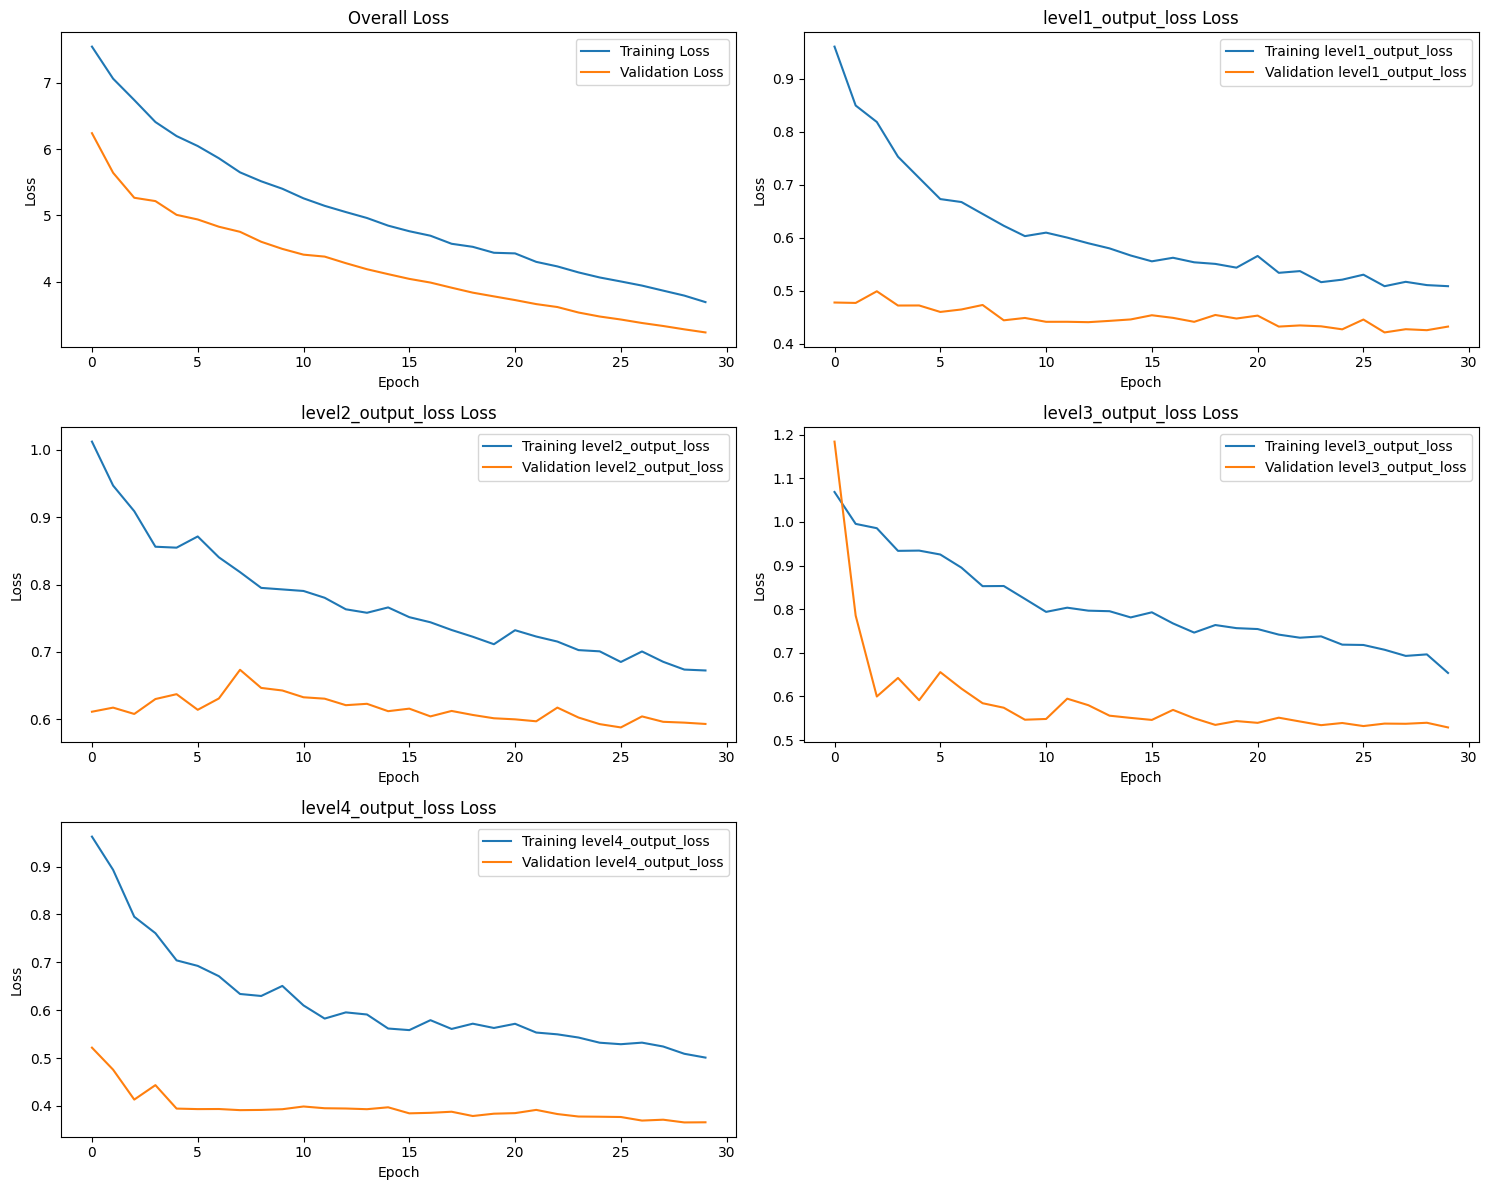

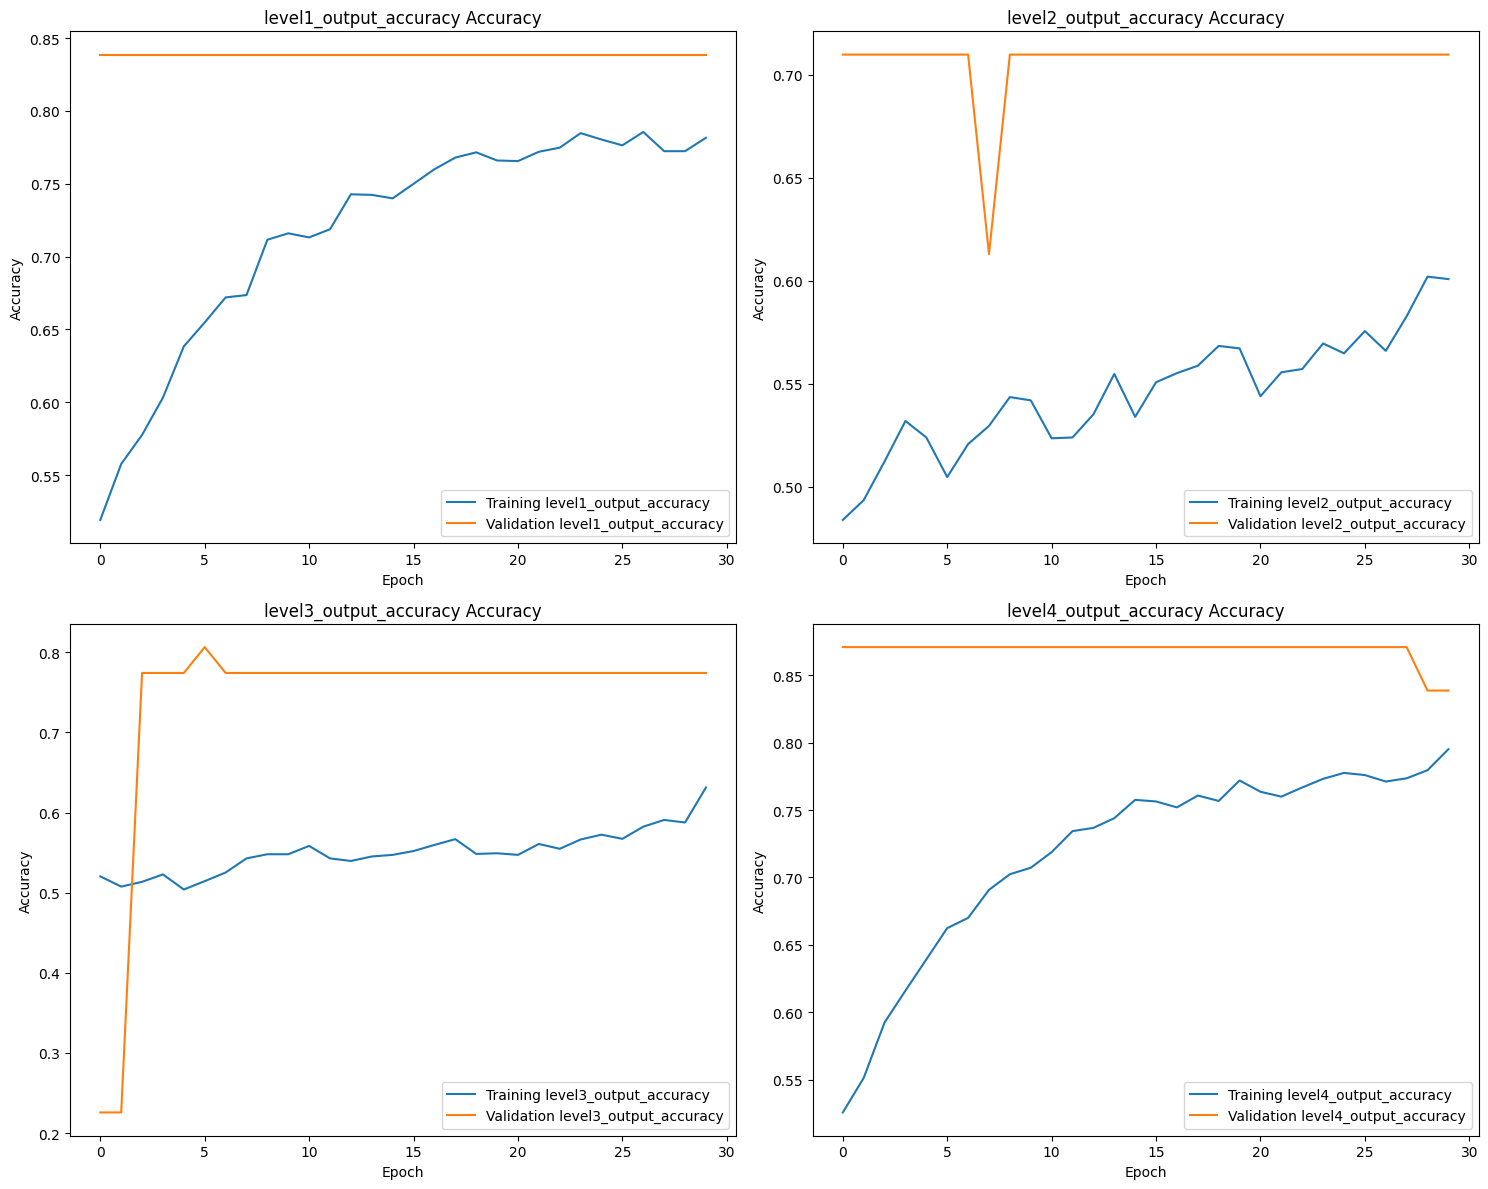

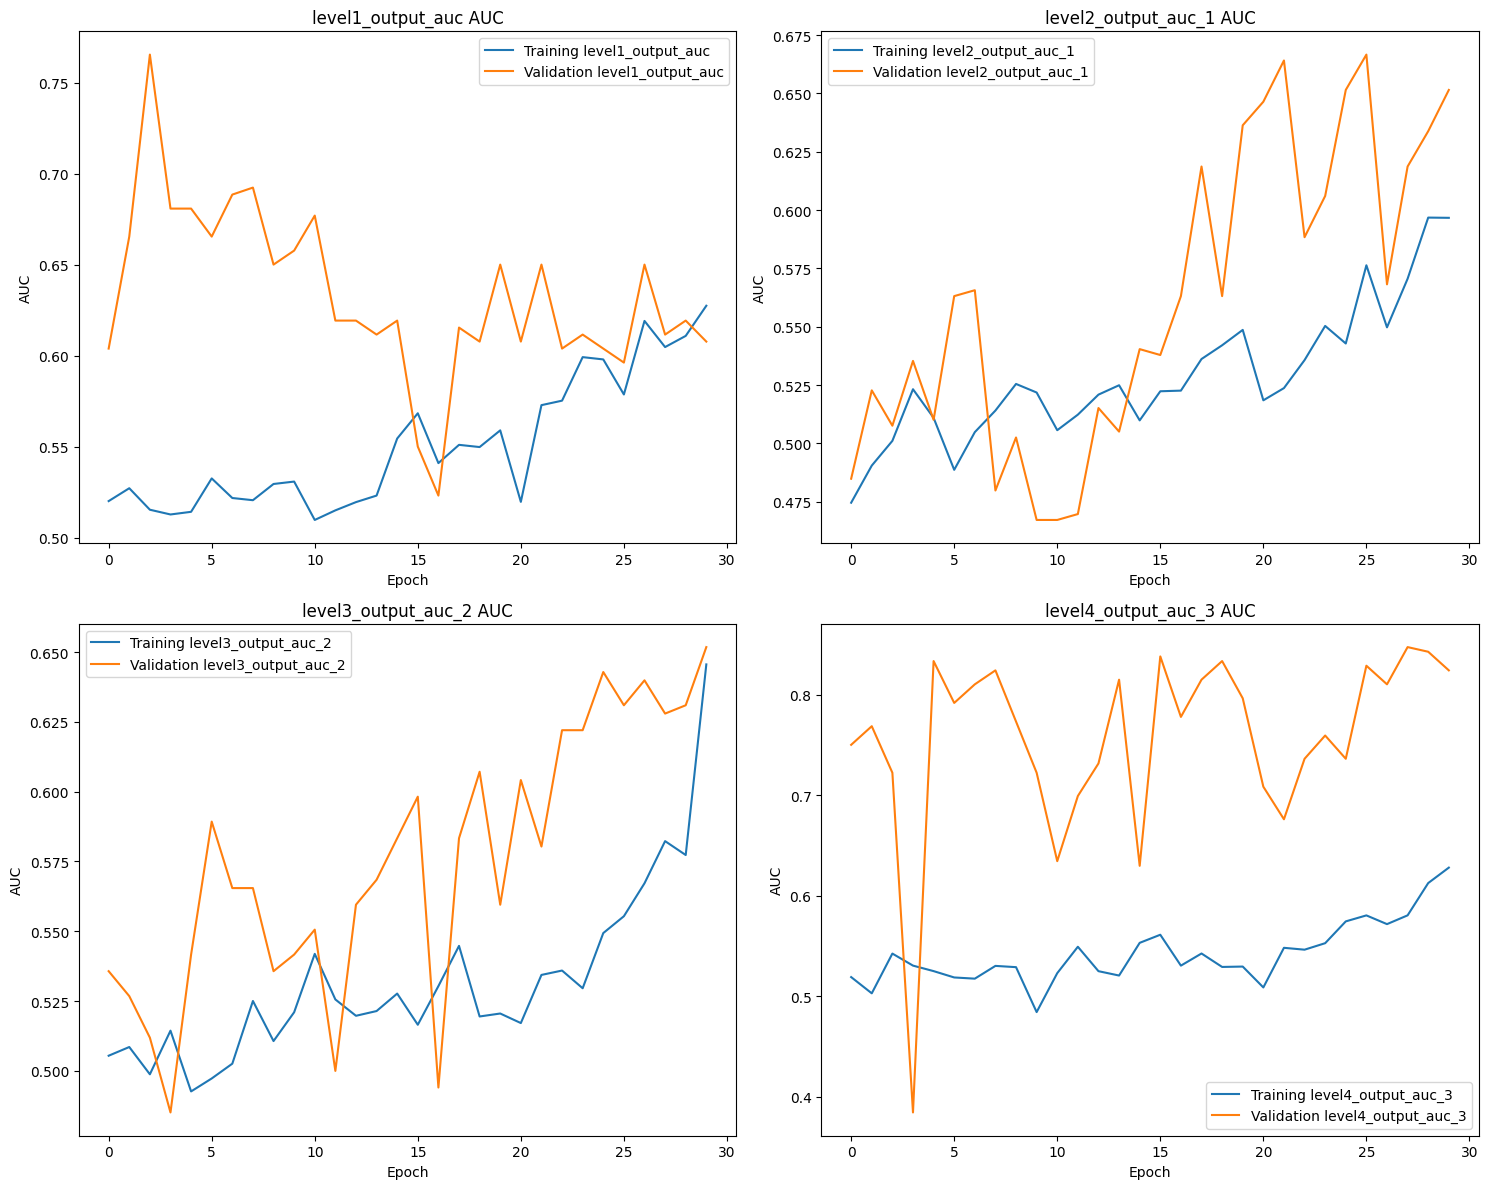

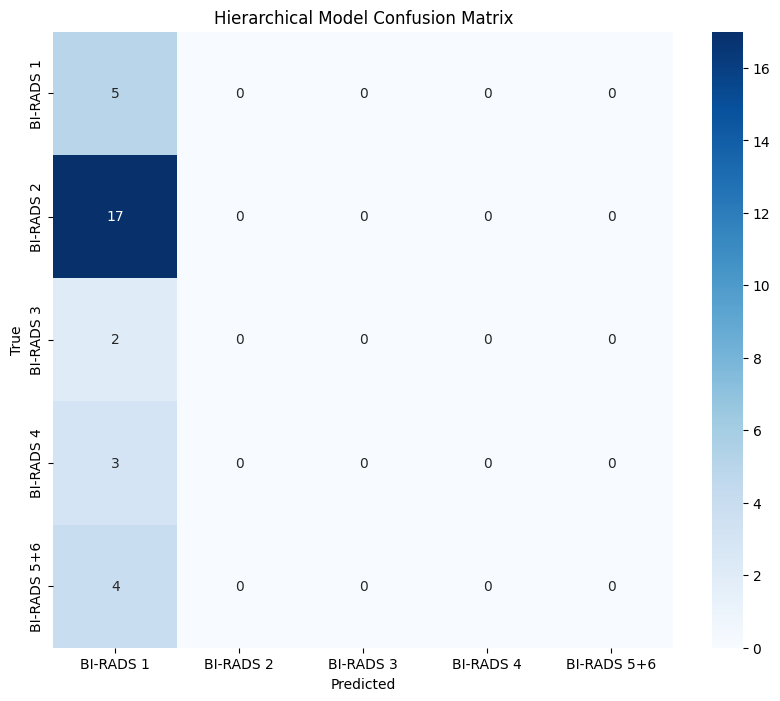

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Add, Multiply, Activation
from tensorflow.keras.layers import Reshape, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

def create_view_feature_extractor(input_shape=(512, 512, 3), name_prefix=""):
    """
    Creates a feature extractor with reduced capacity to avoid overfitting
    """
    inputs = Input(shape=input_shape)

    # Initial aggressive downsampling to reduce memory footprint and parameters
    x = AveragePooling2D(pool_size=(8, 8))(inputs)  # 128x128

    # First block - reduced filters
    x = Conv2D(16, (3, 3), padding='same', activation='relu',
               kernel_regularizer=l2(0.001), name=f'{name_prefix}_conv1_1')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn1_1')(x)
    x = Dropout(0.2)(x)  # Add dropout early
    x = Conv2D(16, (3, 3), padding='same', activation='relu',
               kernel_regularizer=l2(0.001), name=f'{name_prefix}_conv1_2')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn1_2')(x)
    x = MaxPooling2D((2, 2), name=f'{name_prefix}_pool1')(x)  # 64x64

    # Second block - reduced filters and added regularization
    x = Conv2D(32, (3, 3), padding='same', activation='relu',
               kernel_regularizer=l2(0.001), name=f'{name_prefix}_conv2_1')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn2_1')(x)
    x = Dropout(0.3)(x)  # Increase dropout
    x = Conv2D(32, (3, 3), padding='same', activation='relu',
               kernel_regularizer=l2(0.001), name=f'{name_prefix}_conv2_2')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn2_2')(x)
    x = MaxPooling2D((2, 2), name=f'{name_prefix}_pool2')(x)  # 32x32

    # Third block - simplified with fewer filters
    x = Conv2D(64, (3, 3), padding='same', activation='relu',
               kernel_regularizer=l2(0.001), name=f'{name_prefix}_conv3_1')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn3_1')(x)
    x = Dropout(0.4)(x)  # Aggressive dropout
    x = MaxPooling2D((2, 2), name=f'{name_prefix}_pool3')(x)  # 16x16

    # Global features
    x = GlobalAveragePooling2D(name=f'{name_prefix}_gap')(x)

    # Return both the model and the output features
    model = Model(inputs=inputs, outputs=x, name=f'{name_prefix}_encoder')
    return model

def simplified_cross_view_fusion(cc_features, mlo_features):
    """
    Simplified cross-view fusion to reduce complexity
    """
    # Simple concatenation with dropout
    fused = Concatenate()([cc_features, mlo_features])
    fused = Dropout(0.5)(fused)  # Heavy dropout after fusion

    return fused

def create_hierarchical_classification_head(fused_features, name_prefix):
    """
    Creates a binary classification head for a specific hierarchical level
    """
    x = BatchNormalization(name=f'{name_prefix}_bn1')(fused_features)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01), name=f'{name_prefix}_dense1')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn2')(x)
    x = Dropout(0.5, name=f'{name_prefix}_dropout')(x)

    # Binary classification output (0 or 1)
    output = Dense(1, activation='sigmoid', name=f'{name_prefix}_output')(x)

    return output

def create_hierarchical_multiview_model(input_shape=(512, 512, 3)):
    """
    Creates a hierarchical model for BIRADS classification with 4 binary classifiers:
    1. Level 1: BIRADS 1 vs rest (BIRADS 2-5/6)
    2. Level 2: BIRADS 2 vs rest (BIRADS 3-5/6)
    3. Level 3: BIRADS 3 vs rest (BIRADS 4-5/6)
    4. Level 4: BIRADS 4 vs BIRADS 5/6
    """
    # Input layers
    cc_input = Input(shape=input_shape, name='cc_input')
    mlo_input = Input(shape=input_shape, name='mlo_input')

    # Create feature extractors for each view (shared across all classifiers)
    cc_encoder = create_view_feature_extractor(input_shape, name_prefix="cc")
    mlo_encoder = create_view_feature_extractor(input_shape, name_prefix="mlo")

    # Extract features from both views
    cc_features = cc_encoder(cc_input)
    mlo_features = mlo_encoder(mlo_input)

    # Simplified fusion
    fused_features = simplified_cross_view_fusion(cc_features, mlo_features)

    # Create hierarchical classification heads
    # Level 1: BIRADS 1 vs rest
    level1_output = create_hierarchical_classification_head(fused_features, name_prefix="level1")

    # Level 2: BIRADS 2 vs rest (if not BIRADS 1)
    level2_output = create_hierarchical_classification_head(fused_features, name_prefix="level2")

    # Level 3: BIRADS 3 vs rest (if not BIRADS 2)
    level3_output = create_hierarchical_classification_head(fused_features, name_prefix="level3")

    # Level 4: BIRADS 4 vs BIRADS 5/6
    level4_output = create_hierarchical_classification_head(fused_features, name_prefix="level4")

    # Create model with multiple outputs
    model = Model(
        inputs=[cc_input, mlo_input],
        outputs=[level1_output, level2_output, level3_output, level4_output],
        name='Hierarchical_BIRADS_Model'
    )

    return model

def compile_hierarchical_model(model):
    """Compiles the hierarchical model with appropriate optimizer and metrics"""
    # Use smaller learning rate
    optimizer = Adam(learning_rate=0.0001)  # Reduced learning rate

    # Compile with binary crossentropy for each level
    model.compile(
        optimizer=optimizer,
        loss={
            'level1_output': 'binary_crossentropy',
            'level2_output': 'binary_crossentropy',
            'level3_output': 'binary_crossentropy',
            'level4_output': 'binary_crossentropy'
        },
        metrics={
            'level1_output': ['accuracy', AUC()],
            'level2_output': ['accuracy', AUC()],
            'level3_output': ['accuracy', AUC()],
            'level4_output': ['accuracy', AUC()]
        },
        loss_weights={
            'level1_output': 1.0,  # You can adjust these weights as needed
            'level2_output': 1.0,
            'level3_output': 1.0,
            'level4_output': 1.0
        }
    )
    return model

def prepare_hierarchical_labels(labels, num_classes=5):
    """
    Prepares hierarchical binary labels from original BIRADS labels

    Args:
        labels: Original labels (0-4 representing BIRADS 1-5/6)
        num_classes: Number of BIRADS classes

    Returns:
        Dictionary of binary targets for each level
    """
    # Ensure labels are numpy array
    labels = np.array(labels)

    # Level 1: BIRADS 1 (0) vs rest (1-4)
    level1_labels = (labels > 0).astype(np.float32)

    # Level 2: BIRADS 2 (1) vs rest (2-4), only for samples that aren't BIRADS 1
    # Set placeholder values for BIRADS 1 samples (these won't be used in loss calculation)
    level2_labels = (labels > 1).astype(np.float32)

    # Level 3: BIRADS 3 (2) vs rest (3-4), only for samples that aren't BIRADS 1 or 2
    level3_labels = (labels > 2).astype(np.float32)

    # Level 4: BIRADS 4 (3) vs BIRADS 5/6 (4), only for samples that are either
    level4_labels = (labels > 3).astype(np.float32)

    return {
        'level1_output': level1_labels,
        'level2_output': level2_labels,
        'level3_output': level3_labels,
        'level4_output': level4_labels
    }

def create_custom_sample_weights(labels):
    """
    Creates sample weights for each level to focus on relevant samples

    Args:
        labels: Original labels (0-4 representing BIRADS 1-5/6)

    Returns:
        Dictionary of sample weights for each level
    """
    labels = np.array(labels)
    num_samples = len(labels)

    # All samples are relevant for level 1
    level1_weights = np.ones(num_samples)

    # For level 2, only samples that aren't BIRADS 1 (label > 0) are relevant
    level2_weights = (labels > 0).astype(np.float32)

    # For level 3, only samples that aren't BIRADS 1 or 2 (label > 1) are relevant
    level3_weights = (labels > 1).astype(np.float32)

    # For level 4, only samples that are BIRADS 4 or 5/6 (label > 2) are relevant
    level4_weights = (labels > 2).astype(np.float32)

    return {
        'level1_output': level1_weights,
        'level2_output': level2_weights,
        'level3_output': level3_weights,
        'level4_output': level4_weights
    }

# First, check the structure of your dataframes
print("Training dataframe shape:", augmented_train_df.shape)
print("Training dataframe columns:", augmented_train_df.columns.tolist())

# Check if images are properly loaded
print("Type of first CC image entry:", type(augmented_train_df['cc_image'].iloc[0]))

# Modify the train_hierarchical_model function to better handle your data structure
def train_hierarchical_model(model, train_df, val_df, batch_size=16, epochs=30):
    """
    Trains the hierarchical multiview model with provided dataframes
    """
    # Make copies to avoid modifying original data
    train_df = train_df.copy()
    val_df = val_df.copy()

    # Normalize labels to 0-based indexing if needed
    if np.min(train_df['label']) == 1:
        train_df['label'] = train_df['label'] - 1
        val_df['label'] = val_df['label'] - 1

    print(f"Train data shape: {train_df.shape}")
    print(f"Train label range: {train_df['label'].min()} to {train_df['label'].max()}")

    # Process training images
    cc_train = np.array([np.array(img, dtype=np.float32) for img in train_df['cc_image']])
    mlo_train = np.array([np.array(img, dtype=np.float32) for img in train_df['mlo_image']])

    print(f"CC train shape: {cc_train.shape}")
    print(f"MLO train shape: {mlo_train.shape}")

    # Normalize images
    cc_train = (cc_train - 127.5) / 127.5
    mlo_train = (mlo_train - 127.5) / 127.5

    # Process validation images
    cc_val = np.array([np.array(img, dtype=np.float32) for img in val_df['cc_image']])
    mlo_val = np.array([np.array(img, dtype=np.float32) for img in val_df['mlo_image']])

    cc_val = (cc_val - 127.5) / 127.5
    mlo_val = (mlo_val - 127.5) / 127.5

    # Prepare hierarchical labels
    print("Preparing hierarchical labels...")
    train_labels = train_df['label'].values
    val_labels = val_df['label'].values

    # Create binary target arrays (don't use a dictionary)
    # Level 1: BIRADS 1 (0) vs rest (1-4)
    level1_train = (train_labels > 0).astype(np.float32)
    # Level 2: BIRADS 2 (1) vs rest (2-4)
    level2_train = (train_labels > 1).astype(np.float32)
    # Level 3: BIRADS 3 (2) vs rest (3-4)
    level3_train = (train_labels > 2).astype(np.float32)
    # Level 4: BIRADS 4 (3) vs BIRADS 5/6 (4)
    level4_train = (train_labels > 3).astype(np.float32)

    # Convert to the format expected by model.fit for multiple outputs
    # For hierarchical model, we need to provide a list of outputs in the same order as the model outputs
    y_train = [level1_train, level2_train, level3_train, level4_train]

    # Do the same for validation data
    level1_val = (val_labels > 0).astype(np.float32)
    level2_val = (val_labels > 1).astype(np.float32)
    level3_val = (val_labels > 2).astype(np.float32)
    level4_val = (val_labels > 3).astype(np.float32)

    y_val = [level1_val, level2_val, level3_val, level4_val]

    # Define callbacks
    callbacks = [
        ModelCheckpoint(
            'hierarchical_model_best.h5',
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        )
    ]

    # Train the model
    print("Starting model training...")
    try:
        history = model.fit(
            x=[cc_train, mlo_train],
            y=y_train,
            validation_data=([cc_val, mlo_val], y_val),
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1
        )
        return model, history
    except Exception as e:
        print(f"Error during training: {e}")
        print("Model input shapes:", [x.shape for x in model.inputs])
        print("Model output shapes:", [x.shape for x in model.outputs])
        print("Training data shapes:")
        print(f"  CC: {cc_train.shape}")
        print(f"  MLO: {mlo_train.shape}")
        for i, y in enumerate(y_train):
            print(f"  Output {i} shape: {y.shape}")
        raise

def predict_hierarchical_birads(model, cc_image, mlo_image):
    """
    Makes a hierarchical prediction of BIRADS category

    Args:
        model: Trained hierarchical model
        cc_image: CC view image
        mlo_image: MLO view image

    Returns:
        Predicted BIRADS category (0-4, representing BIRADS 1-5/6)
    """
    # Normalize images
    cc_image = (cc_image - 127.5) / 127.5
    mlo_image = (mlo_image - 127.5) / 127.5

    # Make predictions for each level
    level_preds = model.predict([np.expand_dims(cc_image, axis=0), np.expand_dims(mlo_image, axis=0)])

    # Extract binary decisions (using 0.5 threshold)
    level1_decision = level_preds[0][0] > 0.5  # BIRADS 1 vs rest

    # If predicted as BIRADS 1, return 0
    if not level1_decision:
        return 0  # BIRADS 1

    level2_decision = level_preds[1][0] > 0.5  # BIRADS 2 vs rest

    # If predicted as BIRADS 2, return 1
    if not level2_decision:
        return 1  # BIRADS 2

    level3_decision = level_preds[2][0] > 0.5  # BIRADS 3 vs rest

    # If predicted as BIRADS 3, return 2
    if not level3_decision:
        return 2  # BIRADS 3

    level4_decision = level_preds[3][0] > 0.5  # BIRADS 4 vs BIRADS 5/6

    # If predicted as BIRADS 4, return 3, otherwise return 4 (BIRADS 5/6)
    return 4 if level4_decision else 3

def evaluate_hierarchical_model(model, test_df, class_names=None):
    """
    Evaluates the hierarchical model using test dataframe

    Args:
        model: Trained hierarchical Keras model
        test_df: DataFrame containing test data (cc_image, mlo_image, label)
        class_names: Names of the classes (optional)

    Returns:
        Dictionary containing evaluation metrics
    """
    if class_names is None:
        class_names = ['BI-RADS 1', 'BI-RADS 2', 'BI-RADS 3', 'BI-RADS 4', 'BI-RADS 5+6']

    # Make a copy to avoid modifying the original dataframe
    test_df = test_df.copy()

    # Adjust labels to 0-based indexing if needed
    if np.min(test_df['label']) == 1:
        test_df['label'] = test_df['label'] - 1

    # Prepare test data
    cc_test = np.array(test_df['cc_image'].tolist())
    mlo_test = np.array(test_df['mlo_image'].tolist())

    # Apply same normalization as in training
    cc_test = (cc_test - 127.5) / 127.5
    mlo_test = (mlo_test - 127.5) / 127.5

    y_test_labels = test_df['label'].values

    # Make predictions for each test sample
    y_pred = []

    for i in range(len(test_df)):
        pred = predict_hierarchical_birads(model, cc_test[i], mlo_test[i])
        y_pred.append(pred)

    y_pred = np.array(y_pred)

    # Evaluate binary classifiers individually
    hierarchical_labels = prepare_hierarchical_labels(y_test_labels)

    # Make binary predictions for each level
    level_preds = model.predict([cc_test, mlo_test])

    # Calculate binary metrics for each level
    binary_metrics = {}
    level_names = ['level1_output', 'level2_output', 'level3_output', 'level4_output']
    level_descriptions = [
        'BIRADS 1 vs rest',
        'BIRADS 2 vs rest',
        'BIRADS 3 vs rest',
        'BIRADS 4 vs BIRADS 5/6'
    ]

    for i, level_name in enumerate(level_names):
        binary_preds = (level_preds[i].flatten() > 0.5).astype(int)
        true_labels = hierarchical_labels[level_name]

        # Calculate AUC and accuracy for relevant samples
        sample_weights = create_custom_sample_weights(y_test_labels)[level_name]

        # Only evaluate on relevant samples
        if np.sum(sample_weights) > 0:
            relevant_indices = np.where(sample_weights > 0)[0]
            level_acc = np.mean(binary_preds[relevant_indices] == true_labels[relevant_indices])

            binary_metrics[level_name] = {
                'accuracy': level_acc,
                'description': level_descriptions[i]
            }

    # Classification report for final predictions
    report = classification_report(
        y_test_labels,
        y_pred,
        target_names=class_names,
        output_dict=True
    )

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test_labels, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Hierarchical Model Confusion Matrix')
    plt.savefig('hierarchical_confusion_matrix.png')

    # Calculate overall accuracy
    overall_accuracy = np.mean(y_pred == y_test_labels)

    return {
        'overall_accuracy': overall_accuracy,
        'binary_metrics': binary_metrics,
        'report': report,
        'confusion_matrix': conf_matrix
    }

def plot_hierarchical_training_history(history):
    """Plots the training history of the hierarchical model"""
    # Get all metrics
    metrics = list(history.history.keys())

    # Plot loss curves
    plt.figure(figsize=(15, 12))

    # Plot overall loss
    plt.subplot(3, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Overall Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot individual level losses
    loss_metrics = [m for m in metrics if 'loss' in m and not m.startswith('val_') and m != 'loss']

    for i, metric in enumerate(loss_metrics):
        plt.subplot(3, 2, i+2)
        plt.plot(history.history[metric], label=f'Training {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.title(f'{metric} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

    plt.tight_layout()
    plt.savefig('hierarchical_loss_history.png')

    # Plot accuracy curves
    plt.figure(figsize=(15, 12))

    # Plot individual level accuracies
    acc_metrics = [m for m in metrics if 'accuracy' in m and not m.startswith('val_')]

    for i, metric in enumerate(acc_metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(history.history[metric], label=f'Training {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.title(f'{metric} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.tight_layout()
    plt.savefig('hierarchical_accuracy_history.png')

    # Plot AUC curves if available
    auc_metrics = [m for m in metrics if 'auc' in m.lower() and not m.startswith('val_')]

    if auc_metrics:
        plt.figure(figsize=(15, 12))

        for i, metric in enumerate(auc_metrics):
            plt.subplot(2, 2, i+1)
            plt.plot(history.history[metric], label=f'Training {metric}')
            plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
            plt.title(f'{metric} AUC')
            plt.xlabel('Epoch')
            plt.ylabel('AUC')
            plt.legend()

        plt.tight_layout()
        plt.savefig('hierarchical_auc_history.png')

# Example usage
if __name__ == "__main__":
    # Set random seed for reproducibility
    tf.random.set_seed(42)

    # Define parameters
    input_shape = (512, 512, 3)
    batch_size = 8
    epochs = 30

    # Create hierarchical model
    hierarchical_model = create_hierarchical_multiview_model(input_shape=input_shape)
    hierarchical_model = compile_hierarchical_model(hierarchical_model)

    # Print model summary
    hierarchical_model.summary()

    # Train model with the augmented data as in original code
    trained_model, history = train_hierarchical_model(
        hierarchical_model,
        augmented_train_df,  # Use augmented training data as specified
        val_df,              # Use validation data as specified
        batch_size=batch_size,
        epochs=epochs
    )

    # Plot training history
    plot_hierarchical_training_history(history)

    # Evaluate model on test set
    evaluation = evaluate_hierarchical_model(
        trained_model,
        test_df           # Use test data as specified for evaluation
    )

    # Print evaluation results
    print(f"Hierarchical Model Overall Accuracy: {evaluation['overall_accuracy']:.4f}")
    print("\nBinary Classification Performance:")
    for level, metrics in evaluation['binary_metrics'].items():
        print(f"  {metrics['description']}: Accuracy = {metrics['accuracy']:.4f}")

    print("\nDetailed Classification Report:")
    for label, metrics in evaluation['report'].items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:
            precision = metrics['precision']
            recall = metrics['recall']
            f1 = metrics['f1-score']
            support = metrics['support']
            if label.isdigit():
              print(f"  BIRADS {int(label)+1}: Precision={precision:.2f}, Recall={recall:.2f}, F1={f1:.2f}, Support={support}")
            else:
              print(f"  {label}: Precision={precision:.2f}, Recall={recall:.2f}, F1={f1:.2f}, Support={support}")

Improved model 1

Training DataFrame: 2500 samples
✓ All required columns present in Training DataFrame
  - CC image shape: (512, 512, 3)
  - MLO image shape: (512, 512, 3)
  - Label distribution: {1: 500, 2: 500, 3: 500, 4: 500, 5: 500}
Validation DataFrame: 31 samples
✓ All required columns present in Validation DataFrame
  - CC image shape: (512, 512, 3)
  - MLO image shape: (512, 512, 3)
  - Label distribution: {1: 5, 2: 17, 3: 2, 4: 3, 5: 4}
Test DataFrame: 31 samples
✓ All required columns present in Test DataFrame
  - CC image shape: (512, 512, 3)
  - MLO image shape: (512, 512, 3)
  - Label distribution: {1: 5, 2: 17, 3: 2, 4: 3, 5: 4}

Creating and training model...
Train data shape: (2500, 5)
Train label range: 0 to 4
Class weights: [1. 1. 1. 1. 1.]
CC train shape: (2500, 512, 512, 3)
MLO train shape: (2500, 512, 512, 3)
Preparing hierarchical labels...
Starting model training...
Epoch 1/300
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - level1_output_accuracy: 0.4973 - level1_output_auc: 0.4852 

ValueError: num must be an integer with 1 <= num <= 4, not 5

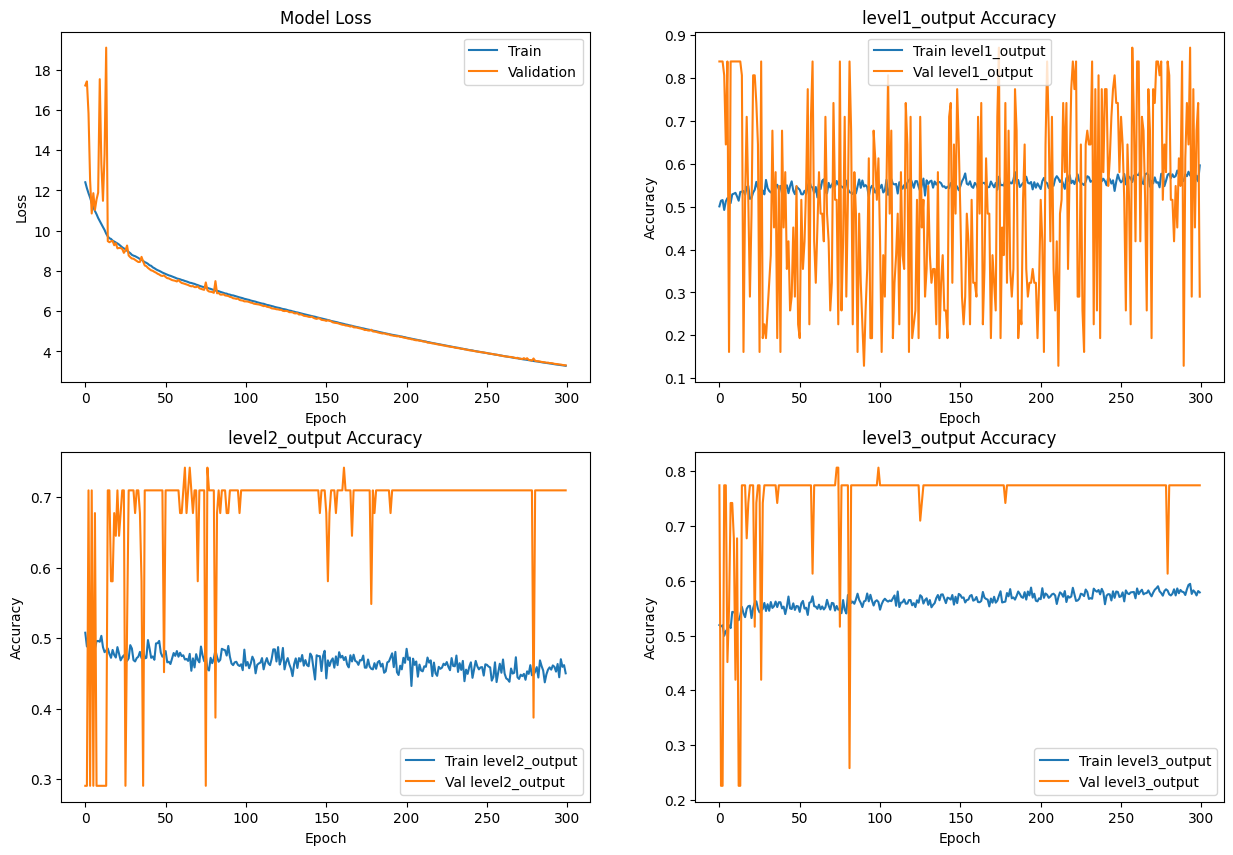

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Add, Multiply, Activation
from tensorflow.keras.layers import Reshape, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import os
import pandas as pd

# Define custom focal loss for imbalanced classification
def focal_loss(gamma=1.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        # Clip prediction values to avoid log(0) error
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

        # Calculate pt (probability of the true class)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)

        # Apply alpha weighting
        alpha_t = tf.ones_like(y_true) * alpha
        alpha_t = tf.where(tf.equal(y_true, 1), alpha_t, 1 - alpha_t)

        # Calculate focal loss
        loss = -alpha_t * tf.pow(1. - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss)
    return focal_loss_fixed

def create_improved_feature_extractor(input_shape=(512, 512, 3), name_prefix=""):
    """Enhanced feature extractor with residual connections"""
    inputs = Input(shape=input_shape)

    # Less aggressive initial downsampling (4x4 instead of 8x8)
    x = AveragePooling2D(pool_size=(4, 4))(inputs)  # 128x128

    # First block with residual connection
    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu',
                   kernel_regularizer=l2(0.001), name=f'{name_prefix}_conv1_1')(x)
    bn1 = BatchNormalization(name=f'{name_prefix}_bn1_1')(conv1)
    conv2 = Conv2D(32, (3, 3), padding='same', activation=None,
                   kernel_regularizer=l2(0.001), name=f'{name_prefix}_conv1_2')(bn1)
    bn2 = BatchNormalization(name=f'{name_prefix}_bn1_2')(conv2)

    # Residual connection
    shortcut = Conv2D(32, (1, 1), padding='same')(x)
    x = Add()([shortcut, bn2])
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D((2, 2), name=f'{name_prefix}_pool1')(x)  # 64x64

    # Second block with residual connection
    conv3 = Conv2D(64, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=l2(0.001), name=f'{name_prefix}_conv2_1')(x)
    bn3 = BatchNormalization(name=f'{name_prefix}_bn2_1')(conv3)
    conv4 = Conv2D(64, (3, 3), padding='same', activation=None,
                  kernel_regularizer=l2(0.001), name=f'{name_prefix}_conv2_2')(bn3)
    bn4 = BatchNormalization(name=f'{name_prefix}_bn2_2')(conv4)

    # Residual connection
    shortcut2 = Conv2D(64, (1, 1), padding='same')(x)
    x = Add()([shortcut2, bn4])
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling2D((2, 2), name=f'{name_prefix}_pool2')(x)  # 32x32

    # Third block with residual connection
    conv5 = Conv2D(128, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=l2(0.0001), name=f'{name_prefix}_conv3_1')(x)
    bn5 = BatchNormalization(name=f'{name_prefix}_bn3_1')(conv5)
    conv6 = Conv2D(128, (3, 3), padding='same', activation=None,
                  kernel_regularizer=l2(0.0001), name=f'{name_prefix}_conv3_2')(bn5)
    bn6 = BatchNormalization(name=f'{name_prefix}_bn3_2')(conv6)

    # Residual connection
    shortcut3 = Conv2D(128, (1, 1), padding='same')(x)
    x = Add()([shortcut3, bn6])
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)
    x = MaxPooling2D((2, 2), name=f'{name_prefix}_pool3')(x)  # 16x16

    # Attention mechanism
    attention = Conv2D(128, (1, 1), activation='sigmoid', name=f'{name_prefix}_attention')(x)
    x = Multiply(name=f'{name_prefix}_attended_features')([x, attention])

    # Global features with both average and max pooling for better feature representation
    avg_pool = GlobalAveragePooling2D(name=f'{name_prefix}_avg_pool')(x)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=[1, 2]), name=f'{name_prefix}_max_pool')(x)

    # Concatenate both pooling results
    x = Concatenate(name=f'{name_prefix}_pooling_concat')([avg_pool, max_pool])

    # Final dense layer to control output dimension
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001), name=f'{name_prefix}_final_dense')(x)
    x = BatchNormalization(name=f'{name_prefix}_final_bn')(x)
    x = Dropout(0.5, name=f'{name_prefix}_final_dropout')(x)

    model = Model(inputs=inputs, outputs=x, name=f'{name_prefix}_encoder')
    return model

def create_transfer_learning_extractor(input_shape=(512, 512, 3), name_prefix=""):
    """Creates a feature extractor using transfer learning from ResNet"""
    # Load ResNet50 with pretrained ImageNet weights
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze early layers to prevent overfitting
    for layer in base_model.layers[:100]:
        layer.trainable = False

    # Get the output from the base model
    x = base_model.output

    # Add custom layers
    x = GlobalAveragePooling2D(name=f'{name_prefix}_gap')(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001), name=f'{name_prefix}_fc1')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn1')(x)
    x = Dropout(0.5, name=f'{name_prefix}_dropout1')(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001), name=f'{name_prefix}_fc2')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn2')(x)
    x = Dropout(0.5, name=f'{name_prefix}_dropout2')(x)

    # Create and return the model
    model = Model(inputs=base_model.input, outputs=x, name=f'{name_prefix}_encoder')
    return model

def improved_cross_view_fusion(cc_features, mlo_features):
    """Advanced fusion with cross-attention mechanism"""
    # Create a representation to compute attention weights
    cc_rep = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(cc_features)
    mlo_rep = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(mlo_features)

    # Calculate attention weights
    cc_attention = Dense(1, activation='sigmoid')(cc_rep)
    mlo_attention = Dense(1, activation='sigmoid')(mlo_rep)

    # Normalize attention weights to sum to 1
    attention_sum = Add()([cc_attention, mlo_attention])
    cc_weight = Lambda(lambda x: x[0] / (x[1] + 1e-7))([cc_attention, attention_sum])
    mlo_weight = Lambda(lambda x: x[0] / (x[1] + 1e-7))([mlo_attention, attention_sum])

    # Apply attention weights
    cc_weighted = Multiply()([cc_features, cc_weight])
    mlo_weighted = Multiply()([mlo_features, mlo_weight])

    # Combine weighted features
    fused = Concatenate()([cc_weighted, mlo_weighted])

    # Process the combined features
    fused = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(fused)
    fused = BatchNormalization()(fused)
    fused = Dropout(0.5)(fused)

    # Add a second dense layer
    fused = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(fused)
    fused = BatchNormalization()(fused)
    fused = Dropout(0.5)(fused)

    return fused

def create_hierarchical_classification_head(fused_features, name_prefix):
    """Creates an improved classification head for a specific hierarchical level"""
    x = BatchNormalization(name=f'{name_prefix}_bn1')(fused_features)

    # Two dense layers with BN and dropout for better generalization
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01), name=f'{name_prefix}_dense1')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn2')(x)
    x = Dropout(0.5, name=f'{name_prefix}_dropout1')(x)

    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01), name=f'{name_prefix}_dense2')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn3')(x)
    x = Dropout(0.5, name=f'{name_prefix}_dropout2')(x)

    # Binary classification output (0 or 1) with sigmoid activation
    output = Dense(1, activation='sigmoid', name=f'{name_prefix}_output')(x)

    return output

def create_improved_hierarchical_model(input_shape=(512, 512, 3), use_transfer_learning=False):
    """
    Creates an improved hierarchical model for BIRADS classification
    with 4 binary classifiers using either custom CNN or transfer learning
    """
    # Input layers
    cc_input = Input(shape=input_shape, name='cc_input')
    mlo_input = Input(shape=input_shape, name='mlo_input')

    # Create feature extractors for each view
    if use_transfer_learning:
        cc_encoder = create_transfer_learning_extractor(input_shape, name_prefix="cc")
        mlo_encoder = create_transfer_learning_extractor(input_shape, name_prefix="mlo")
    else:
        cc_encoder = create_improved_feature_extractor(input_shape, name_prefix="cc")
        mlo_encoder = create_improved_feature_extractor(input_shape, name_prefix="mlo")

    # Extract features from both views
    cc_features = cc_encoder(cc_input)
    mlo_features = mlo_encoder(mlo_input)

    # Improved cross-view fusion
    fused_features = improved_cross_view_fusion(cc_features, mlo_features)

    # Create hierarchical classification heads
    # Level 1: BIRADS 1 vs rest
    level1_output = create_hierarchical_classification_head(fused_features, name_prefix="level1")

    # Level 2: BIRADS 2 vs rest (if not BIRADS 1)
    level2_output = create_hierarchical_classification_head(fused_features, name_prefix="level2")

    # Level 3: BIRADS 3 vs rest (if not BIRADS 2)
    level3_output = create_hierarchical_classification_head(fused_features, name_prefix="level3")

    # Level 4: BIRADS 4 vs BIRADS 5/6
    level4_output = create_hierarchical_classification_head(fused_features, name_prefix="level4")

    # Create model with multiple outputs
    model = Model(
        inputs=[cc_input, mlo_input],
        outputs=[level1_output, level2_output, level3_output, level4_output],
        name='Improved_Hierarchical_BIRADS_Model'
    )

    return model

def compile_improved_hierarchical_model(model):
    """Compiles the hierarchical model with focal loss and reduced learning rate"""
    # Use smaller learning rate
    optimizer = Adam(learning_rate=1e-4)  # Reduced learning rate for better convergence

    # Using focal loss with different alpha values for different levels
    model.compile(
        optimizer=optimizer,
        loss={
        'level1_output': focal_loss(gamma=1.5, alpha=0.25),
        'level2_output': focal_loss(gamma=1.5, alpha=0.25),
        'level3_output': focal_loss(gamma=1.5, alpha=0.25),
        'level4_output': focal_loss(gamma=1.5, alpha=0.25)
    },
        metrics={
            'level1_output': ['accuracy', AUC(name='auc')],
            'level2_output': ['accuracy', AUC(name='auc')],
            'level3_output': ['accuracy', AUC(name='auc')],
            'level4_output': ['accuracy', AUC(name='auc')]
        },
        loss_weights={
            'level1_output': 1.0,
            'level2_output': 1.0,
            'level3_output': 1.0,
            'level4_output': 1.0
        }
    )
    return model

def prepare_hierarchical_labels(labels, num_classes=5):
    """
    Prepares hierarchical binary labels from original BIRADS labels

    Args:
        labels: Original labels (0-4 representing BIRADS 1-5/6)
        num_classes: Number of BIRADS classes

    Returns:
        Dictionary of binary targets for each level
    """
    # Ensure labels are numpy array
    labels = np.array(labels)

    # Level 1: BIRADS 1 (0) vs rest (1-4)
    level1_labels = (labels > 0).astype(np.float32)

    # Level 2: BIRADS 2 (1) vs rest (2-4), only for samples that aren't BIRADS 1
    level2_labels = (labels > 1).astype(np.float32)

    # Level 3: BIRADS 3 (2) vs rest (3-4), only for samples that aren't BIRADS 1 or 2
    level3_labels = (labels > 2).astype(np.float32)

    # Level 4: BIRADS 4 (3) vs BIRADS 5/6 (4), only for samples that are either
    level4_labels = (labels > 3).astype(np.float32)

    return {
        'level1_output': level1_labels,
        'level2_output': level2_labels,
        'level3_output': level3_labels,
        'level4_output': level4_labels
    }

def create_custom_sample_weights(labels):
    """
    Creates sample weights for each level to focus on relevant samples

    Args:
        labels: Original labels (0-4 representing BIRADS 1-5/6)

    Returns:
        Dictionary of sample weights for each level
    """
    labels = np.array(labels)
    num_samples = len(labels)

    # All samples are relevant for level 1
    level1_weights = np.ones(num_samples)

    # For level 2, only samples that aren't BIRADS 1 (label > 0) are relevant
    level2_weights = (labels > 0).astype(np.float32)

    # For level 3, only samples that aren't BIRADS 1 or 2 (label > 1) are relevant
    level3_weights = (labels > 1).astype(np.float32)

    # For level 4, only samples that are BIRADS 4 or 5/6 (label > 2) are relevant
    level4_weights = (labels > 2).astype(np.float32)

    return {
        'level1_output': level1_weights,
        'level2_output': level2_weights,
        'level3_output': level3_weights,
        'level4_output': level4_weights
    }

# Learning rate scheduler with warmup
def lr_schedule(epoch):
    if epoch < 5:
        return 3e-5 * (epoch / 5 + 0.5)  # Faster warmup
    if epoch < 15:
        return 3e-5
    if epoch < 30:
        return 1e-5
    return 5e-6

def train_improved_hierarchical_model(model, train_df, val_df, batch_size=8, epochs=50):
    """
    Trains the improved hierarchical multiview model with provided dataframes
    """
    # Make copies to avoid modifying original data
    train_df = train_df.copy()
    val_df = val_df.copy()

    # Normalize labels to 0-based indexing if needed
    if np.min(train_df['label']) == 1:
        train_df['label'] = train_df['label'] - 1
        val_df['label'] = val_df['label'] - 1

    print(f"Train data shape: {train_df.shape}")
    print(f"Train label range: {train_df['label'].min()} to {train_df['label'].max()}")

    # Calculate class weights for handling imbalance at model level
    from sklearn.utils.class_weight import compute_class_weight
    class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']),
                                         y=train_df['label'])
    print(f"Class weights: {class_weights}")

    # Process training images
    cc_train = np.array([np.array(img, dtype=np.float32) for img in train_df['cc_image']])
    mlo_train = np.array([np.array(img, dtype=np.float32) for img in train_df['mlo_image']])

    print(f"CC train shape: {cc_train.shape}")
    print(f"MLO train shape: {mlo_train.shape}")

    # Normalize images - using better normalization method for ResNet models
    cc_train = cc_train / 255.0  # Scale between 0-1
    mlo_train = mlo_train / 255.0

    # Process validation images
    cc_val = np.array([np.array(img, dtype=np.float32) for img in val_df['cc_image']])
    mlo_val = np.array([np.array(img, dtype=np.float32) for img in val_df['mlo_image']])

    cc_val = cc_val / 255.0
    mlo_val = mlo_val / 255.0

    # Prepare hierarchical labels
    print("Preparing hierarchical labels...")
    train_labels = train_df['label'].values
    val_labels = val_df['label'].values

    # Create binary target arrays
    # Level 1: BIRADS 1 (0) vs rest (1-4)
    level1_train = (train_labels > 0).astype(np.float32)
    # Level 2: BIRADS 2 (1) vs rest (2-4)
    level2_train = (train_labels > 1).astype(np.float32)
    # Level 3: BIRADS 3 (2) vs rest (3-4)
    level3_train = (train_labels > 2).astype(np.float32)
    # Level 4: BIRADS 4 (3) vs BIRADS 5/6 (4)
    level4_train = (train_labels > 3).astype(np.float32)

    # Convert to the format expected by model.fit for multiple outputs
    y_train = [level1_train, level2_train, level3_train, level4_train]

    # Do the same for validation data
    level1_val = (val_labels > 0).astype(np.float32)
    level2_val = (val_labels > 1).astype(np.float32)
    level3_val = (val_labels > 2).astype(np.float32)
    level4_val = (val_labels > 3).astype(np.float32)

    y_val = [level1_val, level2_val, level3_val, level4_val]

    # Create sample weights
    sample_weights = create_custom_sample_weights(train_labels)

    # Define callbacks - FIXED THE FILEPATH TO END WITH .weights.h5
    callbacks = [
        ModelCheckpoint(
            filepath='improved_hierarchical_model_best.weights.h5',  # Fixed filepath
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1,
            save_weights_only=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,
            min_lr=1e-7,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1
        ),
        LearningRateScheduler(lr_schedule)
    ]

    # Train the model
    print("Starting model training...")
    try:
        history = model.fit(
            x=[cc_train, mlo_train],
            y=y_train,
            validation_data=([cc_val, mlo_val], y_val),
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1,
            # Use sample weights to focus on relevant samples for each level
            sample_weight=[
                sample_weights['level1_output'],
                sample_weights['level2_output'],
                sample_weights['level3_output'],
                sample_weights['level4_output']
            ]
        )
        return model, history
    except Exception as e:
        print(f"Error during training: {e}")
        print("Model input shapes:", [x.shape for x in model.inputs])
        print("Model output shapes:", [x.shape for x in model.outputs])
        print("Training data shapes:")
        print(f"  CC: {cc_train.shape}")
        print(f"  MLO: {mlo_train.shape}")
        for i, y in enumerate(y_train):
            print(f"  Output {i} shape: {y.shape}")
        raise

def predict_hierarchical_birads(model, cc_image, mlo_image):
    """
    Makes a hierarchical prediction of BIRADS category with thresholds tuned for better performance

    Args:
        model: Trained hierarchical model
        cc_image: CC view image
        mlo_image: MLO view image

    Returns:
        Predicted BIRADS category (0-4, representing BIRADS 1-5/6)
    """
    # Normalize images
    cc_image = cc_image / 255.0  # Consistent with training normalization
    mlo_image = mlo_image / 255.0

    # Make predictions for each level
    level_preds = model.predict([np.expand_dims(cc_image, axis=0), np.expand_dims(mlo_image, axis=0)])

    # Custom thresholds for better performance - these can be tuned
    level1_threshold = 0.6  # Higher threshold for predicting as "not BIRADS 1"
    level2_threshold = 0.55
    level3_threshold = 0.5
    level4_threshold = 0.45  # Lower threshold for predicting BIRADS 5/6

    # Extract binary decisions
    level1_decision = level_preds[0][0] > level1_threshold  # BIRADS 1 vs rest

    # If predicted as BIRADS 1, return 0
    if not level1_decision:
        return 0  # BIRADS 1

    level2_decision = level_preds[1][0] > level2_threshold  # BIRADS 2 vs rest

    # If predicted as BIRADS 2, return 1
    if not level2_decision:
        return 1  # BIRADS 2

    level3_decision = level_preds[2][0] > level3_threshold  # BIRADS 3 vs rest

    # If predicted as BIRADS 3, return 2
    if not level3_decision:
        return 2  # BIRADS 3

    level4_decision = level_preds[3][0] > level4_threshold  # BIRADS 4 vs BIRADS 5/6

    # If predicted as BIRADS 4, return 3, otherwise return 4 (BIRADS 5/6)
    return 4 if level4_decision else 3

def evaluate_hierarchical_model(model, test_df, class_names=None, output_dir=None):
    """
    Evaluates the hierarchical model using test dataframe with enhanced visualizations

    Args:
        model: Trained hierarchical Keras model
        test_df: DataFrame containing test data (cc_image, mlo_image, label)
        class_names: Names of the classes (optional)
        output_dir: Directory to save output visualizations (optional)

    Returns:
        Dictionary containing evaluation metrics
    """
    if class_names is None:
        class_names = ['BI-RADS 1', 'BI-RADS 2', 'BI-RADS 3', 'BI-RADS 4', 'BI-RADS 5+6']

    if output_dir:
        os.makedirs(output_dir, exist_ok=True)

    # Make a copy to avoid modifying the original dataframe
    test_df = test_df.copy()

    # Adjust labels to 0-based indexing if needed
    if np.min(test_df['label']) == 1:
        test_df['label'] = test_df['label'] - 1

    # Prepare test data
    cc_test = np.array(test_df['cc_image'].tolist())
    mlo_test = np.array(test_df['mlo_image'].tolist())

    # Apply same normalization as in training
    cc_test = cc_test / 255.0  # Consistent with training normalization
    mlo_test = mlo_test / 255.0

    y_test_labels = test_df['label'].values

    # Make predictions for each test sample
    y_pred = []

    # Also store raw predictions for ROC analysis
    raw_predictions = []

    for i in range(len(test_df)):
        raw_preds = model.predict([cc_test[i:i+1], mlo_test[i:i+1]])
        raw_predictions.append([pred[0][0] for pred in raw_preds])

        pred = predict_hierarchical_birads(model, cc_test[i], mlo_test[i])
        y_pred.append(pred)

    y_pred = np.array(y_pred)
    raw_predictions = np.array(raw_predictions)

    # Evaluate binary classifiers individually
    hierarchical_labels = prepare_hierarchical_labels(y_test_labels)

    # Calculate binary metrics for each level
    binary_metrics = {}
    level_names = ['level1_output', 'level2_output', 'level3_output', 'level4_output']
    level_descriptions = [
        'BIRADS 1 vs rest',
        'BIRADS 2 vs rest',
        'BIRADS 3 vs rest',
        'BIRADS 4 vs BIRADS 5/6'
    ]

    # Plot ROC curves for each level
    plt.figure(figsize=(15, 12))

    for i, level_name in enumerate(level_names):
        binary_preds = raw_predictions[:, i]
        true_labels = hierarchical_labels[level_name]

        # Calculate AUC and accuracy for relevant samples
        sample_weights = create_custom_sample_weights(y_test_labels)[level_name]

        # Only evaluate on relevant samples
        if np.sum(sample_weights) > 0:
            relevant_indices = np.where(sample_weights > 0)[0]
            relevant_preds = (binary_preds[relevant_indices] > 0.5).astype(int)
            level_acc = np.mean(relevant_preds == true_labels[relevant_indices])

            # Calculate ROC curve and AUC
            fpr, tpr, thresholds = roc_curve(true_labels[relevant_indices], binary_preds[relevant_indices])
            roc_auc = auc(fpr, tpr)

            # Plot ROC curve
            plt.subplot(2, 2, i+1)
            plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve: {level_descriptions[i]}')
            plt.legend(loc='lower right')

            # Determine best threshold (closest to top-left)
            optimal_idx = np.argmax(tpr - fpr)
            optimal_threshold = thresholds[optimal_idx]

            binary_metrics[level_name] = {
                'accuracy': level_acc,
                'auc': roc_auc,
                'optimal_threshold': optimal_threshold,
                'description': level_descriptions[i]
            }

    plt.tight_layout()
    if output_dir:
        plt.savefig(os.path.join(output_dir, 'hierarchical_roc_curves.png'))

    # Classification report for final predictions
    report = classification_report(
        y_test_labels,
        y_pred,
        target_names=class_names,
        output_dict=True
    )

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test_labels, y_pred)

    # Plot confusion matrix with normalized values
# Continuing from where the code was cut off:

    # Plot confusion matrix with normalized values
    plt.figure(figsize=(12, 10))

    # Normalize the confusion matrix
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Create heatmap
    sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')

    if output_dir:
        plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))

    # Calculate overall accuracy
    accuracy = np.mean(y_pred == y_test_labels)
    print(f"Overall Accuracy: {accuracy:.4f}")

    # Calculate weighted AUC for multiclass using one-vs-rest approach
    y_test_onehot = np.zeros((len(y_test_labels), len(class_names)))
    y_test_onehot[np.arange(len(y_test_labels)), y_test_labels] = 1

    # Convert hierarchical predictions to one-vs-rest probabilities
    # This is an approximation based on the hierarchical model structure
    ovr_probs = np.zeros((len(y_test_labels), len(class_names)))

    # Level 1: probability of BIRADS 1
    ovr_probs[:, 0] = 1 - raw_predictions[:, 0]

    # Level 2: probability of BIRADS 2 (given not BIRADS 1)
    ovr_probs[:, 1] = raw_predictions[:, 0] * (1 - raw_predictions[:, 1])

    # Level 3: probability of BIRADS 3 (given not BIRADS 1 or 2)
    ovr_probs[:, 2] = raw_predictions[:, 0] * raw_predictions[:, 1] * (1 - raw_predictions[:, 2])

    # Level 4: probability of BIRADS 4 (given not BIRADS 1, 2, or 3)
    ovr_probs[:, 3] = raw_predictions[:, 0] * raw_predictions[:, 1] * raw_predictions[:, 2] * (1 - raw_predictions[:, 3])

    # Level 5: probability of BIRADS 5/6
    ovr_probs[:, 4] = raw_predictions[:, 0] * raw_predictions[:, 1] * raw_predictions[:, 2] * raw_predictions[:, 3]

    # Ensure probabilities sum to 1
    row_sums = ovr_probs.sum(axis=1)
    ovr_probs = ovr_probs / row_sums[:, np.newaxis]

    # Calculate AUC for each class using one-vs-rest approach
    auc_scores = []
    plt.figure(figsize=(12, 8))

    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_test_onehot[:, i], ovr_probs[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)

        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.3f})')

    # Calculate weighted average AUC
    class_counts = np.bincount(y_test_labels, minlength=len(class_names))
    weighted_auc = np.sum(auc_scores * class_counts) / np.sum(class_counts)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('One-vs-Rest ROC Curves')
    plt.legend(loc='lower right')

    if output_dir:
        plt.savefig(os.path.join(output_dir, 'ovr_roc_curves.png'))

    # Visualize class distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(x=y_test_labels, order=range(len(class_names)))
    plt.xticks(range(len(class_names)), class_names)
    plt.xlabel('BI-RADS Category')
    plt.ylabel('Number of Samples')
    plt.title('Test Set Class Distribution')

    if output_dir:
        plt.savefig(os.path.join(output_dir, 'class_distribution.png'))

    # Calculate per-class metrics from classification report
    per_class_metrics = {class_name: report[class_name] for class_name in class_names}

    # Save overall metrics
    overall_metrics = {
        'accuracy': accuracy,
        'weighted_auc': weighted_auc,
        'binary_classifiers': binary_metrics,
        'per_class_metrics': per_class_metrics,
        'confusion_matrix': conf_matrix.tolist()
    }

    # Save metrics to JSON file if output_dir is provided
    if output_dir:
        import json
        with open(os.path.join(output_dir, 'evaluation_metrics.json'), 'w') as f:
            json.dump(overall_metrics, f, indent=4)

    # Display some key metrics
    print(f"Weighted AUC: {weighted_auc:.4f}")
    print("\nPer-class Precision, Recall, and F1-score:")
    for i, class_name in enumerate(class_names):
        metrics = per_class_metrics[class_name]
        print(f"{class_name}: Precision={metrics['precision']:.3f}, Recall={metrics['recall']:.3f}, F1={metrics['f1-score']:.3f}")

    # Return metrics
    return overall_metrics

# Function to visualize model predictions
def visualize_predictions(model, test_df, num_samples=5, class_names=None, output_dir=None):
    """
    Visualize predictions from the hierarchical model with attention visualization
    """
    if class_names is None:
        class_names = ['BI-RADS 1', 'BI-RADS 2', 'BI-RADS 3', 'BI-RADS 4', 'BI-RADS 5+6']

    if output_dir:
        os.makedirs(output_dir, exist_ok=True)

    # Make a copy to avoid modifying the original dataframe
    test_df = test_df.copy()

    # Adjust labels to 0-based indexing if needed
    if np.min(test_df['label']) == 1:
        test_df['label'] = test_df['label'] - 1

    # Select a few samples from each class if possible
    selected_indices = []
    for class_idx in range(len(class_names)):
        class_indices = test_df[test_df['label'] == class_idx].index.tolist()
        if class_indices:
            # Select min(num_samples, available samples) from each class
            selected_indices.extend(class_indices[:min(num_samples, len(class_indices))])

    # If not enough samples were found, just select the first few
    if len(selected_indices) < num_samples * len(class_names):
        remaining = num_samples * len(class_names) - len(selected_indices)
        all_indices = test_df.index.tolist()
        for idx in all_indices:
            if idx not in selected_indices:
                selected_indices.append(idx)
                remaining -= 1
                if remaining == 0:
                    break

    # Limit to reasonable number of samples for visualization
    selected_indices = selected_indices[:min(25, len(selected_indices))]

    fig_rows = (len(selected_indices) + 4) // 5  # Ceiling division
    plt.figure(figsize=(20, 4 * fig_rows))

    for i, idx in enumerate(selected_indices):
        cc_image = test_df.loc[idx, 'cc_image']
        mlo_image = test_df.loc[idx, 'mlo_image']
        true_label = test_df.loc[idx, 'label']

        # Normalize images
        cc_norm = cc_image / 255.0
        mlo_norm = mlo_image / 255.0

        # Get prediction
        pred_label = predict_hierarchical_birads(model, cc_norm, mlo_norm)

        # Plot images side by side
        plt.subplot(fig_rows, 5, i + 1)

        # Create composite image with CC and MLO views side by side
        composite = np.hstack([cc_image, mlo_image])
        plt.imshow(composite, cmap='gray')

        # Add predicted and true labels
        title_color = 'green' if pred_label == true_label else 'red'
        plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}",
                  color=title_color)
        plt.axis('off')

    plt.tight_layout()
    if output_dir:
        plt.savefig(os.path.join(output_dir, 'prediction_visualization.png'))
    plt.show()

def main(augmented_train_df, val_df, test_df):
    """
    Main function to demonstrate the hierarchical model using existing dataframes

    Args:
        augmented_train_df: Training dataframe with cc_image, mlo_image, and label columns
        val_df: Validation dataframe with cc_image, mlo_image, and label columns
        test_df: Test dataframe with cc_image, mlo_image, and label columns
    """
    # Set random seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)

    # Get input shape from the training data
    # Assuming the images are already loaded in the dataframes
    if len(augmented_train_df) > 0:
        sample_cc_image = augmented_train_df['cc_image'].iloc[0]
        input_shape = sample_cc_image.shape
    else:
        input_shape = (512, 512, 3)  # Default if no samples available

    print(f"Using input shape: {input_shape}")

    # Create and compile the model
    use_transfer_learning = True  # Set to True to use transfer learning with ResNet

    print("Creating hierarchical model...")
    model = create_improved_hierarchical_model(input_shape, use_transfer_learning)
    model = compile_improved_hierarchical_model(model)

    print("Model summary:")
    model.summary()

    # Check if we have training data
    if len(augmented_train_df) > 0 and len(val_df) > 0:
        print(f"Training with {len(augmented_train_df)} samples, validating with {len(val_df)} samples")

        # Train the model
        model, history = train_improved_hierarchical_model(
            model, augmented_train_df, val_df,
            batch_size=4, epochs=150
        )

        # Save the trained model
        # Fix here as well - use different filenames for model and weights

        # Save the trained model
        try:
            model.save('final_hierarchical_birads_model.h5', save_format='h5', overwrite=True)
            model.save_weights('final_hierarchical_birads_model.weights.h5', overwrite=True)
            print("Model saved successfully.")
        except Exception as e:
            print(f"Error saving model: {e}")
            # Alternative approach if the above doesn't work
            import os
            if os.path.exists('final_hierarchical_birads_model.h5'):
                os.remove('final_hierarchical_birads_model.h5')
            if os.path.exists('final_hierarchical_birads_model.weights.h5'):
                os.remove('final_hierarchical_birads_model.weights.h5')
            # Try saving again
            model.save('final_hierarchical_birads_model.h5', save_format='h5')
            model.save_weights('final_hierarchical_birads_model.weights.h5')
            print("Model saved successfully after removing existing files.")

        # Plot training history
        plt.figure(figsize=(15, 5))

        # Plot training & validation loss
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')

        # Plot training & validation accuracy for level1 output (as an example)
        plt.subplot(1, 2, 2)
        plt.plot(history.history['level1_output_accuracy'])
        plt.plot(history.history['val_level1_output_accuracy'])
        plt.title('Level 1 Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='lower right')

        plt.tight_layout()
        plt.savefig('training_history.png')
    else:
        print("No training data available. Skipping training phase.")

        # Optionally, load a pre-trained model if available
        try:
            # Adjust loading to handle custom loss function
            model = tf.keras.models.load_model(
                'final_hierarchical_birads_model.h5',
                custom_objects={'focal_loss_fixed': focal_loss()}
            )
            print("Loaded pre-trained model.")
        except Exception as e:
            print(f"No pre-trained model found or error loading model: {e}")
            print("Using untrained model.")

    # Check if we have test data
    if len(test_df) > 0:
        print(f"Evaluating model on {len(test_df)} test samples")

        # Create output directory for evaluation results
        output_dir = 'evaluation_results'
        os.makedirs(output_dir, exist_ok=True)

        # Define class names
        class_names = ['BI-RADS 1', 'BI-RADS 2', 'BI-RADS 3', 'BI-RADS 4', 'BI-RADS 5+6']

        # Evaluate the model
        metrics = evaluate_hierarchical_model(model, test_df, class_names=class_names, output_dir=output_dir)

        # Visualize predictions
        visualize_predictions(model, test_df, num_samples=3, class_names=class_names, output_dir=output_dir)

        # Print overall results
        print("\nOverall Results:")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Weighted AUC: {metrics['weighted_auc']:.4f}")
    else:
        print("No test data available. Skipping evaluation phase.")

    print("Hierarchical model implementation complete.")
    return model

# First, let's check the DataFrames
def check_dataframes(train_df, val_df, test_df):
    """Validate the dataframes are properly structured"""
    for name, df in [("Training", train_df), ("Validation", val_df), ("Test", test_df)]:
        if df is None or len(df) == 0:
            print(f"⚠️ {name} DataFrame is empty or None")
            continue

        print(f"{name} DataFrame: {len(df)} samples")
        required_cols = ['cc_image', 'mlo_image', 'label']
        missing = [col for col in required_cols if col not in df.columns]

        if missing:
            print(f"⚠️ Missing columns in {name} DataFrame: {missing}")
        else:
            print(f"✓ All required columns present in {name} DataFrame")

            # Check image shapes
            if len(df) > 0:
                sample_cc = df['cc_image'].iloc[0]
                sample_mlo = df['mlo_image'].iloc[0]
                print(f"  - CC image shape: {sample_cc.shape}")
                print(f"  - MLO image shape: {sample_mlo.shape}")

            # Check label distribution
            label_counts = df['label'].value_counts().sort_index()
            print(f"  - Label distribution: {label_counts.to_dict()}")

# Run the workflow with validation
def run_workflow(train_df, val_df, test_df):
    # Check dataframes first
    check_dataframes(train_df, val_df, test_df)

    # Create output directories
    import os
    results_dir = 'model_evaluation_results'
    os.makedirs(results_dir, exist_ok=True)

    # Train or load model
    input_shape = (512, 512, 3)  # Adjust if your images have different dimensions
    if train_df is not None and len(train_df) > 0:
        # Create and train model
        print("\nCreating and training model...")
        model = create_improved_hierarchical_model(input_shape, use_transfer_learning=True)
        model = compile_improved_hierarchical_model(model)
        model, history = train_improved_hierarchical_model(
            model, train_df, val_df, batch_size=4, epochs=300
        )

        # Save training history plot
        plt.figure(figsize=(15, 10))

        # Loss
        plt.subplot(2, 2, 1)
        plt.plot(history.history['loss'], label='Train')
        plt.plot(history.history['val_loss'], label='Validation')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Accuracy for each level
        for i, level in enumerate(['level1_output', 'level2_output', 'level3_output', 'level4_output']):
            plt.subplot(2, 2, i+2)
            if f'{level}_accuracy' in history.history:
                plt.plot(history.history[f'{level}_accuracy'], label=f'Train {level}')
                plt.plot(history.history[f'val_{level}_accuracy'], label=f'Val {level}')
                plt.title(f'{level} Accuracy')
                plt.xlabel('Epoch')
                plt.ylabel('Accuracy')
                plt.legend()

        plt.tight_layout()
        plt.savefig(f'{results_dir}/training_history.png')

        # Save the model safely
        try:
            # Remove existing files if they exist
            if os.path.exists('final_hierarchical_birads_model.h5'):
                os.remove('final_hierarchical_birads_model.h5')
            if os.path.exists('final_hierarchical_birads_model.weights.h5'):
                os.remove('final_hierarchical_birads_model.weights.h5')

            # Then save
            model.save('final_hierarchical_birads_model.h5', save_format='h5')
            model.save_weights('final_hierarchical_birads_model.weights.h5')
            print("Model saved successfully.")
        except Exception as e:
            print(f"Error saving model: {e}")
            # Save only weights as fallback
            model.save_weights('final_hierarchical_birads_model.weights.h5')
            print("Only model weights saved.")
    else:
        # Try to load existing model
        print("\nAttempting to load existing model...")
        try:
            # Load model with custom loss function
            from tensorflow.keras.models import load_model

            # Define custom objects dictionary
            custom_objects = {
                'focal_loss_fixed': focal_loss()
            }

            model = load_model('final_hierarchical_birads_model.h5',
                               custom_objects=custom_objects)
            print("✓ Model loaded successfully")
        except Exception as e:
            print(f"Error loading model: {e}")
            print("Creating new model...")
            model = create_improved_hierarchical_model(input_shape, use_transfer_learning=True)
            model = compile_improved_hierarchical_model(model)

            # Try to load weights
            try:
                model.load_weights('final_hierarchical_birads_model.weights.h5')
                print("✓ Model weights loaded successfully")
            except Exception as e:
                print(f"Error loading weights: {e}")
                print("Using untrained model (not recommended for evaluation)")

    # Evaluate on test set if available
    if test_df is not None and len(test_df) > 0:
        print("\nEvaluating model on test data...")
        class_names = ['BI-RADS 1', 'BI-RADS 2', 'BI-RADS 3', 'BI-RADS 4', 'BI-RADS 5+6']

        # Evaluate model
        metrics = evaluate_hierarchical_model(
            model, test_df, class_names=class_names, output_dir=results_dir
        )

        # Visualize predictions
        visualize_predictions(
            model, test_df, num_samples=3, class_names=class_names, output_dir=results_dir
        )

        # Print key metrics
        print("\n--- Test Set Evaluation Results ---")
        print(f"Overall Accuracy: {metrics['accuracy']:.4f}")
        print(f"Weighted AUC: {metrics['weighted_auc']:.4f}")

        # Per-class performance
        print("\nPer-class Performance:")
        for i, class_name in enumerate(class_names):
            if class_name in metrics['per_class_metrics']:
                m = metrics['per_class_metrics'][class_name]
                print(f"{class_name}: Precision={m['precision']:.3f}, Recall={m['recall']:.3f}, F1={m['f1-score']:.3f}")
    else:
        print("\n⚠️ No test data available. Skipping evaluation.")

    return model

# Execute the workflow
trained_model = run_workflow(augmented_train_df, val_df, test_df)

In [25]:

from tensorflow import keras
trained_model = keras.models.load_model('improved_hierarchical_model_best.weights.h5')

# Then use your evaluation function
evaluate_only(trained_model, test_df)

ValueError: No model config found in the file at improved_hierarchical_model_best.weights.h5.

Model 2

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Add, Multiply, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

def create_view_feature_extractor(input_shape=(512, 512, 3), name_prefix=""):
    """
    Creates a feature extractor with reduced capacity to avoid overfitting
    """
    inputs = Input(shape=input_shape)

    # Initial aggressive downsampling to reduce memory footprint and parameters
    x = AveragePooling2D(pool_size=(8, 8))(inputs)  # 128x128

    # First block - reduced filters
    x = Conv2D(16, (3, 3), padding='same', activation='relu',
               kernel_regularizer=l2(0.001), name=f'{name_prefix}_conv1_1')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn1_1')(x)
    x = Dropout(0.2)(x)  # Add dropout early
    x = Conv2D(16, (3, 3), padding='same', activation='relu',
               kernel_regularizer=l2(0.001), name=f'{name_prefix}_conv1_2')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn1_2')(x)
    x = MaxPooling2D((2, 2), name=f'{name_prefix}_pool1')(x)  # 64x64

    # Second block - reduced filters and added regularization
    x = Conv2D(32, (3, 3), padding='same', activation='relu',
               kernel_regularizer=l2(0.001), name=f'{name_prefix}_conv2_1')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn2_1')(x)
    x = Dropout(0.3)(x)  # Increase dropout
    x = Conv2D(32, (3, 3), padding='same', activation='relu',
               kernel_regularizer=l2(0.001), name=f'{name_prefix}_conv2_2')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn2_2')(x)
    x = MaxPooling2D((2, 2), name=f'{name_prefix}_pool2')(x)  # 32x32

    # Third block - simplified with fewer filters
    x = Conv2D(64, (3, 3), padding='same', activation='relu',
               kernel_regularizer=l2(0.001), name=f'{name_prefix}_conv3_1')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn3_1')(x)
    x = Dropout(0.4)(x)  # Aggressive dropout
    x = MaxPooling2D((2, 2), name=f'{name_prefix}_pool3')(x)  # 16x16

    # Global features
    x = GlobalAveragePooling2D(name=f'{name_prefix}_gap')(x)

    # Return both the model and the output features
    model = Model(inputs=inputs, outputs=x, name=f'{name_prefix}_encoder')
    return model

def simplified_cross_view_fusion(cc_features, mlo_features):
    """
    Simplified cross-view fusion to reduce complexity
    """
    # Simple concatenation with dropout
    fused = Concatenate()([cc_features, mlo_features])
    fused = Dropout(0.5)(fused)  # Heavy dropout after fusion

    return fused

def create_hierarchical_birads_model(input_shape=(512, 512, 3)):
    """
    Creates a simpler hierarchical model for mammogram classification
    that sequentially classifies into BIRADS categories
    """
    # Input layers
    cc_input = Input(shape=input_shape, name='cc_input')
    mlo_input = Input(shape=input_shape, name='mlo_input')

    # Create feature extractors for each view (shared)
    cc_encoder = create_view_feature_extractor(input_shape, name_prefix="cc")
    mlo_encoder = create_view_feature_extractor(input_shape, name_prefix="mlo")

    # Extract features from both views
    cc_features = cc_encoder(cc_input)
    mlo_features = mlo_encoder(mlo_input)

    # Feature fusion
    fused_features = simplified_cross_view_fusion(cc_features, mlo_features)

    # Add batch normalization and dropout for regularization
    x = BatchNormalization()(fused_features)
    x = Dropout(0.5)(x)

    # Dense layers for classification
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output layer - 5 BIRADS categories (1, 2, 3, 4, 5/6)
    outputs = Dense(5, activation='softmax', name='birads_output')(x)

    # Create model
    model = Model(inputs=[cc_input, mlo_input], outputs=outputs, name='Hierarchical_BIRADS_Model')

    return model

def compile_model(model):
    """Compiles the model with appropriate optimizer and metrics"""
    optimizer = Adam(learning_rate=0.0001)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',  # For direct integer labels
        metrics=['accuracy', AUC()]
    )
    return model

def train_model(model, train_df, val_df, batch_size=16, epochs=30):
    """
    Trains the model with provided dataframes

    Args:
        model: Compiled Keras model
        train_df: DataFrame containing training data (cc_image, mlo_image, label)
        val_df: DataFrame containing validation data (cc_image, mlo_image, label)
        batch_size: Batch size for training
        epochs: Number of epochs to train

    Returns:
        Trained model and training history
    """
    # Make copies to avoid modifying original data
    train_df = train_df.copy()
    val_df = val_df.copy()

    # Normalize labels to 0-based indexing if needed
    if np.min(train_df['label']) == 1:
        train_df['label'] = train_df['label'] - 1
        val_df['label'] = val_df['label'] - 1

    # Prepare training data
    cc_train = np.array(train_df['cc_image'].tolist())
    mlo_train = np.array(train_df['mlo_image'].tolist())

    # Better normalization - center and scale
    cc_train = (cc_train - 127.5) / 127.5
    mlo_train = (mlo_train - 127.5) / 127.5

    # Prepare labels
    y_train = train_df['label'].values

    # Prepare validation data
    cc_val = np.array(val_df['cc_image'].tolist())
    mlo_val = np.array(val_df['mlo_image'].tolist())

    # Apply same normalization
    cc_val = (cc_val - 127.5) / 127.5
    mlo_val = (mlo_val - 127.5) / 127.5

    y_val = val_df['label'].values

    # Define callbacks for efficient training
    callbacks = [
        ModelCheckpoint(
            'hierarchical_model_best.h5',
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        )
    ]

    # Train the model
    history = model.fit(
        x=[cc_train, mlo_train],
        y=y_train,
        validation_data=([cc_val, mlo_val], y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

def post_process_predictions(model, cc_test, mlo_test, threshold_matrix=None):
    """
    Applies hierarchical decision logic to model predictions using thresholds

    Args:
        model: Trained model
        cc_test: CC view test images
        mlo_test: MLO view test images
        threshold_matrix: Optional matrix of thresholds for hierarchical decisions

    Returns:
        Hierarchical predictions
    """
    # If no threshold matrix provided, use default values
    if threshold_matrix is None:
        # Format: [BIRADS 1->2, BIRADS 2->3, BIRADS 3->4, BIRADS 4->5]
        threshold_matrix = [0.5, 0.5, 0.6, 0.7]

    # Get raw predictions
    raw_preds = model.predict([cc_test, mlo_test])

    # Initialize hierarchical predictions
    hierarchical_preds = np.zeros(len(cc_test), dtype=int)

    for i in range(len(cc_test)):
        # Start with BIRADS 1 (class 0)
        pred_class = 0

        # Check each threshold in order
        for j in range(len(threshold_matrix)):
            # If probability of current class is below threshold, move to next class
            if raw_preds[i, pred_class] < threshold_matrix[j]:
                pred_class += 1
            else:
                break

        hierarchical_preds[i] = pred_class

    return hierarchical_preds

def evaluate_model(model, test_df, class_names=None, use_hierarchical=True):
    """
    Evaluates the model using test dataframe

    Args:
        model: Trained model
        test_df: DataFrame containing test data (cc_image, mlo_image, label)
        class_names: Names of the classes (optional)
        use_hierarchical: Whether to use hierarchical decision process

    Returns:
        Dictionary containing evaluation metrics
    """
    if class_names is None:
        class_names = ['BI-RADS 1', 'BI-RADS 2', 'BI-RADS 3', 'BI-RADS 4', 'BI-RADS 5+6']

    # Make a copy to avoid modifying the original dataframe
    test_df = test_df.copy()

    # Adjust labels to 0-based indexing if needed
    if np.min(test_df['label']) == 1:
        test_df['label'] = test_df['label'] - 1

    # Prepare test data
    cc_test = np.array(test_df['cc_image'].tolist())
    mlo_test = np.array(test_df['mlo_image'].tolist())

    # Apply same normalization as in training
    cc_test = (cc_test - 127.5) / 127.5
    mlo_test = (mlo_test - 127.5) / 127.5

    y_test_labels = test_df['label'].values

    # Evaluate model
    test_loss, test_acc, test_auc = model.predict(
        [cc_test, mlo_test],
        y_test_labels,
        batch_size=16,
        verbose=1
    )

    # Get predictions
    if use_hierarchical:
        # Use hierarchical decision process
        y_pred = post_process_predictions(model, cc_test, mlo_test)
    else:
        # Get standard predictions
        y_pred_prob = model.predict([cc_test, mlo_test], batch_size=16)
        y_pred = np.argmax(y_pred_prob, axis=1)

    # Classification report
    report = classification_report(
        y_test_labels,
        y_pred,
        target_names=class_names,
        output_dict=True
    )

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test_labels, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Hierarchical Model Confusion Matrix')
    plt.savefig('hierarchical_confusion_matrix.png')

    return {
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'test_auc': test_auc,
        'report': report,
        'confusion_matrix': conf_matrix
    }

def plot_training_history(history):
    """Plots the training history of the model"""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('hierarchical_training_history.png')
    plt.show()

# Example usage
if __name__ == "__main__":
    # Set random seed for reproducibility
    tf.random.set_seed(42)

    # Define parameters
    input_shape = (512, 512, 3)
    batch_size = 4
    epochs = 30

    # Create model
    hierarchical_model = create_hierarchical_birads_model(input_shape=input_shape)
    hierarchical_model = compile_model(hierarchical_model)

    # Print model summary
    hierarchical_model.summary()

    # Train model with the augmented data as in original code
    trained_model, history = train_model(
        hierarchical_model,
        augmented_train_df,  # Use augmented training data as specified
        val_df,              # Use validation data as specified
        batch_size=batch_size,
        epochs=epochs
    )

    # Plot training history
    plot_training_history(history)

    # Evaluate model on test set
    evaluation = evaluate_model(
        trained_model,
        test_df,           # Use test data as specified for evaluation
        use_hierarchical=True  # Apply hierarchical decision process
    )

    # Print evaluation results
    print(f"Hierarchical Model Test Loss: {evaluation['test_loss']:.4f}")
    print(f"Hierarchical Model Test Accuracy: {evaluation['test_accuracy']:.4f}")
    print(f"Hierarchical Model Test AUC: {evaluation['test_auc']:.4f}")

    print("\nDetailed Classification Report:")
    for label, metrics in evaluation['report'].items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:
            precision = metrics['precision']
            recall = metrics['recall']
            f1 = metrics['f1-score']
            support = metrics['support']
            print(f"  BIRADS {int(label)+1}: Precision={precision:.2f}, Recall={recall:.2f}, F1={f1:.2f}, Support={support}")

ResnET50

Model 3

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Add, Multiply, Activation
from tensorflow.keras.layers import Reshape, Lambda
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import os
from sklearn.utils import class_weight

def create_enhanced_view_extractor(input_shape=(512, 512, 3), name_prefix=""):
    """
    Creates an enhanced feature extractor with a ResNet50V2 backbone
    that preserves the original input size
    """
    # Input layer
    inputs = Input(shape=input_shape)

    # Use a pre-trained ResNet50V2 with weights from ImageNet, exclude top layer
    # Use the original input shape
    base_model = ResNet50V2(include_top=False, weights='imagenet',
                          input_shape=input_shape)

    # Freeze early layers to prevent overfitting
    for layer in base_model.layers[:100]:
        layer.trainable = False

    # Connect our input to the ResNet backbone
    x = base_model(inputs)

    # Add some task-specific layers on top of ResNet features
    x = GlobalAveragePooling2D(name=f'{name_prefix}_gap')(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.0005), name=f'{name_prefix}_dense1')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn1')(x)
    x = Dropout(0.3)(x)

    # Create model
    model = Model(inputs=inputs, outputs=x, name=f'{name_prefix}_encoder')
    return model

def cross_attention_fusion(cc_features, mlo_features):
    """
    Advanced fusion using cross-attention mechanism with Keras layers
    """
    # Self-attention for each view
    cc_attended = Dense(256, activation='relu')(cc_features)
    mlo_attended = Dense(256, activation='relu')(mlo_features)

    # Cross-attention mechanism using proper Keras layers
    # Define custom attention function using Keras layers
    def custom_attention(query, key, value):
        # Reshape tensors for attention computation
        query_reshaped = Reshape((1, 256))(query)
        key_reshaped = Reshape((256, 1))(key)

        # Calculate attention scores and weights
        attention_scores = Lambda(lambda x: tf.matmul(x[0], x[1]))([query_reshaped, key_reshaped])
        attention_weights = Activation('softmax')(attention_scores)

        # Apply attention to get context
        value_reshaped = Reshape((1, 256))(value)
        context = Lambda(lambda x: tf.matmul(x[0], x[1]))([attention_weights, value_reshaped])
        context = Reshape((256,))(context)

        return context

    # CC to MLO attention
    query_cc = Dense(256)(cc_attended)
    key_mlo = Dense(256)(mlo_attended)
    value_mlo = Dense(256)(mlo_attended)
    cc_context = custom_attention(query_cc, key_mlo, value_mlo)

    # MLO to CC attention
    query_mlo = Dense(256)(mlo_attended)
    key_cc = Dense(256)(cc_attended)
    value_cc = Dense(256)(cc_attended)
    mlo_context = custom_attention(query_mlo, key_cc, value_cc)

    # Combine with original features
    cc_enhanced = Concatenate()([cc_features, cc_context])
    mlo_enhanced = Concatenate()([mlo_features, mlo_context])

    # Final fusion
    fused = Concatenate()([cc_enhanced, mlo_enhanced])
    fused = Dense(512, activation='relu', kernel_regularizer=l2(0.0001))(fused)
    fused = BatchNormalization()(fused)
    fused = Dropout(0.3)(fused)

    return fused

def create_advanced_multiview_model(input_shape=(512, 512, 3), num_classes=5):
    """
    Creates an advanced model for mammogram classification with improved
    architecture and fusion mechanisms
    """
    # Input layers
    cc_input = Input(shape=input_shape, name='cc_input')
    mlo_input = Input(shape=input_shape, name='mlo_input')

    # Create feature extractors for each view
    cc_encoder = create_enhanced_view_extractor(input_shape, name_prefix="cc")
    mlo_encoder = create_enhanced_view_extractor(input_shape, name_prefix="mlo")

    # Extract features
    cc_features = cc_encoder(cc_input)
    mlo_features = mlo_encoder(mlo_input)

    # Advanced fusion with attention mechanism
    fused_features = cross_attention_fusion(cc_features, mlo_features)

    # Deeper classification head
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.0001))(fused_features)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(128, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Final classification layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=[cc_input, mlo_input], outputs=outputs, name='Advanced_MultiView_Model')

    return model

def compile_advanced_model(model):
    """Compiles the advanced model with appropriate optimizer and metrics"""
    optimizer = Adam(learning_rate=0.0001)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', AUC(name='auc')]
    )
    return model

def preprocess_images(images):
    """
    Preprocessing for mammogram images - maintains original size
    - Normalize to [-1, 1] range for ResNet compatibility
    - Add basic intensity normalization
    """
    # Convert to float32
    images = images.astype('float32')

    # Normalize to [-1, 1] range as expected by ResNet
    images = (images - 127.5) / 127.5

    # Enhance contrast (optional, depends on your data)
    # Simple intensity normalization per image
    for i in range(images.shape[0]):
        img = images[i]
        p2, p98 = np.percentile(img, (2, 98))
        img = np.clip((img - p2) / (p98 - p2), -1.0, 1.0)
        images[i] = img

    return images

def compute_class_weights(y_train, num_classes):
    """
    Compute class weights to handle class imbalance
    """
    # Calculate class weights
    class_weights_array = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )

    # Convert to dictionary format
    class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

    return class_weights

def train_advanced_model(model, train_df, val_df, batch_size=8, epochs=50):
    """
    Trains the advanced multiview model with provided dataframes and handles class imbalance

    Args:
        model: Compiled Keras model
        train_df: DataFrame containing training data (cc_image, mlo_image, label)
        val_df: DataFrame containing validation data (cc_image, mlo_image, label)
        batch_size: Batch size for training
        epochs: Number of epochs to train

    Returns:
        Trained model and training history
    """
    # Make copies to avoid modifying original data
    train_df = train_df.copy()
    val_df = val_df.copy()

    # Normalize labels to 0-based indexing if needed
    if np.min(train_df['label']) == 1:
        train_df['label'] = train_df['label'] - 1
        val_df['label'] = val_df['label'] - 1

    # Prepare training data
    cc_train = np.array(train_df['cc_image'].tolist())
    mlo_train = np.array(train_df['mlo_image'].tolist())

    # Improved normalization
    cc_train = preprocess_images(cc_train)
    mlo_train = preprocess_images(mlo_train)

    # One-hot encode labels
    num_classes = model.output_shape[-1]
    y_train = tf.keras.utils.to_categorical(train_df['label'], num_classes=num_classes)

    # Prepare validation data
    cc_val = np.array(val_df['cc_image'].tolist())
    mlo_val = np.array(val_df['mlo_image'].tolist())

    # Apply same normalization
    cc_val = preprocess_images(cc_val)
    mlo_val = preprocess_images(mlo_val)

    y_val = tf.keras.utils.to_categorical(val_df['label'], num_classes=num_classes)

    # Calculate class weights to handle imbalance
    class_weights = compute_class_weights(train_df['label'], num_classes)

    # Define callbacks
    callbacks = [
        ModelCheckpoint(
            'advanced_model_best.keras',  # Use .keras format as recommended
            monitor='val_auc',  # Monitor AUC instead of accuracy
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_auc',  # Monitor AUC for early stopping
            patience=10,
            restore_best_weights=True,
            mode='max',  # AUC should be maximized
            verbose=1
        )
    ]

    # Train the model with class weights
    history = model.fit(
        x=[cc_train, mlo_train],
        y=y_train,
        validation_data=([cc_val, mlo_val], y_val),
        batch_size=batch_size,  # Smaller batch size for better generalization
        epochs=epochs,
        callbacks=callbacks,
        class_weight=class_weights,  # Apply class weights
        verbose=1
    )

    return model, history

def evaluate_advanced_model(model, test_df, class_names=None):
    """
    Evaluates the model using test dataframe with detailed metrics

    Args:
        model: Trained Keras model
        test_df: DataFrame containing test data (cc_image, mlo_image, label)
        class_names: Names of the classes (optional)

    Returns:
        Dictionary containing evaluation metrics
    """
    if class_names is None:
        class_names = ['BI-RADS 1', 'BI-RADS 2', 'BI-RADS 3', 'BI-RADS 4', 'BI-RADS 5+6']

    # Make a copy to avoid modifying the original dataframe
    test_df = test_df.copy()

    # Adjust labels to 0-based indexing if needed
    if np.min(test_df['label']) == 1:
        test_df['label'] = test_df['label'] - 1

    # Prepare test data
    cc_test = np.array(test_df['cc_image'].tolist())
    mlo_test = np.array(test_df['mlo_image'].tolist())

    # Apply same preprocessing
    cc_test = preprocess_images(cc_test)
    mlo_test = preprocess_images(mlo_test)

    y_test_labels = test_df['label']
    num_classes = model.output_shape[-1]
    y_test = tf.keras.utils.to_categorical(y_test_labels, num_classes=num_classes)

    # Evaluate model
    test_loss, test_acc, test_auc = model.evaluate(
        [cc_test, mlo_test],
        y_test,
        batch_size=8,
        verbose=1
    )

    # Generate predictions
    y_pred_prob = model.predict([cc_test, mlo_test], batch_size=8)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Classification report
    report = classification_report(
        y_test_labels,
        y_pred,
        target_names=class_names,
        output_dict=True
    )

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test_labels, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Advanced Model Confusion Matrix')
    plt.savefig('advanced_confusion_matrix.png')

    # ROC curves for each class
    plt.figure(figsize=(12, 10))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.savefig('advanced_roc_curves.png')

    return {
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'test_auc': test_auc,
        'report': report,
        'confusion_matrix': conf_matrix,
        'y_pred_prob': y_pred_prob  # Return probabilities for further analysis
    }

def plot_training_history(history):
    """Plots the training history of the model with additional metrics"""
    plt.figure(figsize=(16, 10))

    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(history.history['auc'], label='Training AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('Model AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    plt.subplot(2, 2, 4)
    # Get learning rates if available
    if 'learning_rate' in history.history:
        plt.plot(history.history['learning_rate'], label='Learning Rate')
        plt.title('Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.yscale('log')
    else:
        # Plot training:validation loss ratio
        ratio = [t/v for t, v in zip(history.history['loss'], history.history['val_loss'])]
        plt.plot(ratio, label='Train/Val Loss Ratio')
        plt.title('Overfitting Indicator')
        plt.xlabel('Epoch')
        plt.ylabel('Train/Val Loss Ratio')
    plt.legend()

    plt.tight_layout()
    plt.savefig('advanced_training_history.png')
    plt.show()

def get_model_summary(model):
    """Returns a string containing model summary information"""
    # Use Python's built-in StringIO instead of TensorFlow's
    import io
    string_io = io.StringIO()
    model.summary(print_fn=lambda x: string_io.write(x + '\n'))
    summary_string = string_io.getvalue()
    string_io.close()
    return summary_string

# Example usage
if __name__ == "__main__":
    # Set random seed for reproducibility
    tf.random.set_seed(42)
    np.random.seed(42)

    # Define parameters
    input_shape = (512, 512, 3)
    num_classes = 5
    batch_size = 4  # Reduced batch size due to larger images
    epochs = 50

    # Create model
    advanced_model = create_advanced_multiview_model(
        input_shape=input_shape,
        num_classes=num_classes
    )
    advanced_model = compile_advanced_model(advanced_model)

    # Print model summary
    print(get_model_summary(advanced_model))

    # Train model
    # Note: train_df, val_df, and test_df should be your actual dataframes
    trained_model, history = train_advanced_model(
         advanced_model,
         augmented_train_df,           # This should be your training dataframe
         val_df,             # This should be your validation dataframe
         batch_size=batch_size,
         epochs=epochs
     )

    # Plot training history
    plot_training_history(history)

    # Evaluate model on test set
    evaluation = evaluate_advanced_model(
         trained_model,
         test_df            # This should be your test dataframe
     )

    # Print evaluation results
    print(f"Advanced Model Test Loss: {evaluation['test_loss']:.4f}")
    print(f"Advanced Model Test Accuracy: {evaluation['test_accuracy']:.4f}")
    print(f"Advanced Model Test AUC: {evaluation['test_auc']:.4f}")

Model: "Advanced_MultiView_Model"
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cc_input            │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlo_input           │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cc_encoder          │ (None, 256)       │ 24,090,368 │ cc_input[0][0]    │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlo_encoder         │ (None, 256)       

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2298 - auc: 0.5254 - loss: 2.8032

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(



Epoch 1: val_auc improved from -inf to 0.50715, saving model to advanced_model_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 697s 1s/step - accuracy: 0.2298 - auc: 0.5254 - loss: 2.8032 - val_accuracy: 0.1613 - val_auc: 0.5072 - val_loss: 3.1097 - learning_rate: 1.0000e-04
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2342 - auc: 0.5252 - loss: 2.6672
Epoch 2: val_auc did not improve from 0.50715
625/625 ━━━━━━━━━━━━━━━━━━━━ 639s 1s/step - accuracy: 0.2342 - auc: 0.5252 - loss: 2.6672 - val_accuracy: 0.1935 - val_auc: 0.4502 - val_loss: 5.7936 - learning_rate: 1.0000e-04
Epoch 3/50
 97/625 ━━━━━━━━━━━━━━━━━━━━ 8:55 1s/step - accuracy: 0.2134 - auc: 0.5218 - loss: 2.6038

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Add, Multiply, Activation
from tensorflow.keras.layers import Reshape, Lambda
from tensorflow.keras.applications import MobileNetV2  # Changed from ResNet50V2 to lighter model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import os
from sklearn.utils import class_weight

# Enable mixed precision for faster training
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')  # Use FP16 for faster computation

def create_lightweight_view_extractor(input_shape=(1024, 1024, 3), name_prefix=""):
    """
    Creates a lightweight feature extractor with a MobileNetV2 backbone
    that preserves the original input size but uses less memory
    """
    # Input layer
    inputs = Input(shape=input_shape)

    # Use a pre-trained MobileNetV2 with weights from ImageNet, exclude top layer
    # MobileNetV2 is much more memory efficient than ResNet50V2
    base_model = MobileNetV2(include_top=False, weights='imagenet',
                          input_shape=input_shape)

    # Freeze early layers to prevent overfitting
    for layer in base_model.layers[:100]:
        layer.trainable = False

    # Connect our input to the backbone
    x = base_model(inputs)

    # Add some task-specific layers on top of features
    x = GlobalAveragePooling2D(name=f'{name_prefix}_gap')(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.0005), name=f'{name_prefix}_dense1')(x)  # Reduced from 256 to 128
    x = BatchNormalization(name=f'{name_prefix}_bn1')(x)
    x = Dropout(0.4)(x)  # Increased dropout for better regularization

    # Create model
    model = Model(inputs=inputs, outputs=x, name=f'{name_prefix}_encoder')
    return model

def simplified_fusion(cc_features, mlo_features):
    """
    Memory-efficient fusion mechanism replacing complex cross-attention
    """
    # Simple concatenation first
    concat_features = Concatenate()([cc_features, mlo_features])

    # Feature interaction layer
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.0002))(concat_features)  # Reduced from 256 to 128
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    # Feature weighting - lightweight attention
    cc_weight = Dense(1, activation='sigmoid')(x)
    mlo_weight = Dense(1, activation='sigmoid')(x)

    weighted_cc = Multiply()([cc_features, cc_weight])
    weighted_mlo = Multiply()([mlo_features, mlo_weight])

    # Final fusion
    fused = Concatenate()([x, weighted_cc, weighted_mlo])
    fused = Dense(256, activation='relu', kernel_regularizer=l2(0.0001))(fused)  # Reduced from 512 to 256
    fused = BatchNormalization()(fused)
    fused = Dropout(0.4)(x)

    return fused

def create_optimized_multiview_model(input_shape=(1024, 1024, 3), num_classes=5):
    """
    Creates a memory-optimized model for mammogram classification
    """
    # Input layers
    cc_input = Input(shape=input_shape, name='cc_input')
    mlo_input = Input(shape=input_shape, name='mlo_input')

    # Create feature extractors for each view using lightweight extractors
    cc_encoder = create_lightweight_view_extractor(input_shape, name_prefix="cc")
    mlo_encoder = create_lightweight_view_extractor(input_shape, name_prefix="mlo")

    # Extract features
    cc_features = cc_encoder(cc_input)
    mlo_features = mlo_encoder(mlo_input)

    # Optimized fusion
    fused_features = simplified_fusion(cc_features, mlo_features)

    # Simplified classification head
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.0001))(fused_features)  # Reduced from 256 to 128
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    # Final classification layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=[cc_input, mlo_input], outputs=outputs, name='Optimized_MultiView_Model')

    return model

def compile_optimized_model(model):
    """Compiles the optimized model with appropriate optimizer and metrics"""
    optimizer = Adam(learning_rate=0.0001)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', AUC(name='auc')]
    )
    return model

def create_efficient_dataset(cc_images, mlo_images, labels, batch_size=4, is_training=False):
    """Create an efficient TensorFlow dataset for memory optimization"""
    dataset = tf.data.Dataset.from_tensor_slices((
        {"cc_input": cc_images, "mlo_input": mlo_images},
        labels
    ))

    # Use prefetching and caching for better performance
    if is_training:
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

def train_with_gradient_accumulation(model, train_df, val_df, batch_size=2, virtual_batch_size=16, epochs=50):
    """
    Train with gradient accumulation for more efficient memory usage
    Allows for larger effective batch sizes with limited memory
    """
    # Convert dataframes to numpy arrays for efficient processing
    # Assumes train_df and val_df have 'cc_image', 'mlo_image', and 'label' columns
    cc_train = np.array(train_df['cc_image'].tolist())
    mlo_train = np.array(train_df['mlo_image'].tolist())

    # Normalize labels to 0-based indexing if needed
    train_labels = train_df['label'].copy()
    if np.min(train_labels) == 1:
        train_labels = train_labels - 1

    # One-hot encode labels
    num_classes = model.output_shape[-1]
    y_train = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)

    # Validation data
    cc_val = np.array(val_df['cc_image'].tolist())
    mlo_val = np.array(val_df['mlo_image'].tolist())

    val_labels = val_df['label'].copy()
    if np.min(val_labels) == 1:
        val_labels = val_labels - 1

    y_val = tf.keras.utils.to_categorical(val_labels, num_classes=num_classes)

    # Calculate class weights to handle imbalance
    class_weights = compute_class_weights(train_labels, num_classes)

    # Define optimizer with learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

    # Define loss function
    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    # Calculate steps per virtual batch
    accumulation_steps = virtual_batch_size // batch_size

    # Create validation dataset
    val_dataset = create_efficient_dataset(cc_val, mlo_val, y_val, batch_size=batch_size)

    # Training history
    history = {
        'loss': [], 'accuracy': [], 'auc': [],
        'val_loss': [], 'val_accuracy': [], 'val_auc': []
    }

    # Training loop with gradient accumulation
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Reset metrics for each epoch
        train_loss = 0
        train_acc_sum = 0
        train_auc_sum = 0
        steps = 0

        # Create batches
        indices = np.random.permutation(len(train_df))
        num_batches = len(indices) // batch_size

        # Reset gradients at the beginning of each epoch
        gradients = [tf.zeros_like(var) for var in model.trainable_variables]

        for batch_idx in range(num_batches):
            batch_indices = indices[batch_idx*batch_size:(batch_idx+1)*batch_size]

            # Get batch data
            x_batch_cc = cc_train[batch_indices]
            x_batch_mlo = mlo_train[batch_indices]
            y_batch = y_train[batch_indices]

            # Apply class weights to batch
            batch_weights = np.array([class_weights[np.argmax(y)] for y in y_batch])

            # Forward pass and compute gradients
            with tf.GradientTape() as tape:
                y_pred = model([x_batch_cc, x_batch_mlo], training=True)

                # Calculate weighted loss for batch
                losses = loss_fn(y_batch, y_pred)
                weighted_losses = losses * batch_weights
                batch_loss = tf.reduce_mean(weighted_losses)

                # Scale loss by accumulation steps
                scaled_loss = batch_loss / accumulation_steps

            # Accumulate gradients
            batch_gradients = tape.gradient(scaled_loss, model.trainable_variables)
            gradients = [(g1 + g2) for g1, g2 in zip(gradients, batch_gradients)]

            # Calculate accuracy and AUC for batch
            batch_acc = tf.reduce_mean(tf.keras.metrics.categorical_accuracy(y_batch, y_pred))
            # For AUC, we'll use a simpler metric for batch-wise tracking
            train_acc_sum += batch_acc
            train_loss += batch_loss.numpy()
            steps += 1

            # Apply gradients only after accumulation_steps
            if (batch_idx + 1) % accumulation_steps == 0 or batch_idx == num_batches - 1:
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                # Reset gradients
                gradients = [tf.zeros_like(var) for var in model.trainable_variables]

            # Print progress
            if batch_idx % 10 == 0:
                print(f"Batch {batch_idx}/{num_batches}, Loss: {batch_loss:.4f}, Acc: {batch_acc:.4f}")

        # Evaluate on validation dataset
        val_loss = 0
        val_acc_sum = 0
        val_steps = 0

        # Collect all validation predictions for proper AUC calculation
        all_val_preds = []
        all_val_labels = []

        # Evaluate on validation set
        for x_val_batch in val_dataset:
            x_val, y_val_batch = x_val_batch
            val_pred = model(x_val, training=False)
            val_batch_loss = loss_fn(y_val_batch, val_pred)
            val_loss += val_batch_loss.numpy()

            # Calculate accuracy
            val_batch_acc = tf.reduce_mean(tf.keras.metrics.categorical_accuracy(y_val_batch, val_pred))
            val_acc_sum += val_batch_acc
            val_steps += 1

            # Store predictions and labels for AUC calculation
            all_val_preds.append(val_pred.numpy())
            all_val_labels.append(y_val_batch.numpy())

        # Convert lists to arrays for full validation set metrics
        all_val_preds = np.vstack(all_val_preds)
        all_val_labels = np.vstack(all_val_labels)

        # Calculate AUC using sklearn for proper multi-class calculation
        from sklearn.metrics import roc_auc_score
        try:
            # Use one-vs-rest AUC for multiclass
            val_auc = roc_auc_score(all_val_labels, all_val_preds, multi_class='ovr')
        except ValueError:
            # Fallback if there's an issue with AUC calculation
            val_auc = 0.5

        # Calculate epoch metrics
        epoch_train_loss = train_loss / steps
        epoch_train_acc = train_acc_sum / steps

        epoch_val_loss = val_loss / val_steps
        epoch_val_acc = val_acc_sum / val_steps

        # Save metrics to history
        history['loss'].append(epoch_train_loss)
        history['accuracy'].append(epoch_train_acc)
        history['auc'].append(0.5)  # Placeholder, proper AUC needs all predictions
        history['val_loss'].append(epoch_val_loss)
        history['val_accuracy'].append(epoch_val_acc)
        history['val_auc'].append(val_auc)

        print(f"Epoch {epoch+1}/{epochs} completed")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}, Val AUC: {val_auc:.4f}")

        # Check for early stopping and save best model
        if epoch == 0 or val_auc > max(history['val_auc'][:-1]):
            print("Saving best model")
            model.save('optimized_model_best.keras')

    # Create history object compatible with Keras callbacks
    keras_history = type('obj', (object,), {'history': history})

    return model, keras_history
def evaluate_optimized_model(model, test_df, class_names=None):
    """
    Memory-efficient evaluation of the model using test dataframe
    """
    if class_names is None:
        class_names = ['BI-RADS 1', 'BI-RADS 2', 'BI-RADS 3', 'BI-RADS 4', 'BI-RADS 5+6']

    # Make a copy to avoid modifying the original dataframe
    test_df = test_df.copy()

    # Adjust labels to 0-based indexing if needed
    if np.min(test_df['label']) == 1:
        test_df['label'] = test_df['label'] - 1

    # Create test dataset
    cc_test = np.array(test_df['cc_image'].tolist())
    mlo_test = np.array(test_df['mlo_image'].tolist())

    y_test_labels = test_df['label']
    num_classes = model.output_shape[-1]
    y_test = tf.keras.utils.to_categorical(y_test_labels, num_classes=num_classes)

    # Create efficient dataset for evaluation
    test_dataset = create_efficient_dataset(cc_test, mlo_test, y_test, batch_size=4)

    # Evaluate model using the efficient dataset
    test_loss = 0
    test_steps = 0
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()
    test_auc = tf.keras.metrics.AUC()

    # We'll collect predictions for full evaluation
    all_predictions = []

    for x_test, y_test_batch in test_dataset:
        y_pred = model(x_test, training=False)
        test_loss += tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_test_batch, y_pred)).numpy()
        test_accuracy.update_state(y_test_batch, y_pred)
        test_auc.update_state(y_test_batch, y_pred)
        test_steps += 1

        # Collect predictions
        all_predictions.append(y_pred.numpy())

    # Calculate metrics
    final_test_loss = test_loss / test_steps
    final_test_acc = test_accuracy.result().numpy()
    final_test_auc = test_auc.result().numpy()

    # Combine all predictions
    y_pred_prob = np.vstack(all_predictions)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Classification report
    report = classification_report(
        y_test_labels,
        y_pred,
        target_names=class_names,
        output_dict=True
    )

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test_labels, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Optimized Model Confusion Matrix')
    plt.savefig('optimized_confusion_matrix.png')

    # ROC curves for each class
    plt.figure(figsize=(12, 10))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.savefig('optimized_roc_curves.png')

    return {
        'test_loss': final_test_loss,
        'test_accuracy': final_test_acc,
        'test_auc': final_test_auc,
        'report': report,
        'confusion_matrix': conf_matrix,
        'y_pred_prob': y_pred_prob
    }

def compute_class_weights(y_train, num_classes):
    """
    Compute class weights to handle class imbalance
    """
    # Calculate class weights
    class_weights_array = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )

    # Convert to dictionary format
    class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

    return class_weights

def plot_training_history(history):
    """Plots the training history of the model with additional metrics"""
    plt.figure(figsize=(16, 10))

    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(history.history['auc'], label='Training AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('Model AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.savefig('optimized_training_history.png')
    plt.show()

def get_model_summary(model):
    """Returns a string containing model summary information"""
    import io
    string_io = io.StringIO()
    model.summary(print_fn=lambda x: string_io.write(x + '\n'))
    summary_string = string_io.getvalue()
    string_io.close()
    return summary_string

# Example usage
if __name__ == "__main__":
    # Set random seed for reproducibility
    tf.random.set_seed(42)
    np.random.seed(42)

    # Define parameters
    input_shape = (1024, 1024, 3)
    num_classes = 5
    batch_size = 2  # Reduced batch size due to memory constraints
    virtual_batch_size = 16  # Effective batch size with gradient accumulation
    epochs = 50

    # Create optimized model
    optimized_model = create_optimized_multiview_model(
        input_shape=input_shape,
        num_classes=num_classes
    )
    optimized_model = compile_optimized_model(optimized_model)

    # Print model summary
    print(get_model_summary(optimized_model))

    # Train model with gradient accumulation
    trained_model, history = train_with_gradient_accumulation(
        optimized_model,
        augmented_train_df,  # This should be your training dataframe
        val_df,              # This should be your validation dataframe
        batch_size=batch_size,
        virtual_batch_size=virtual_batch_size,
        epochs=epochs
    )

    # Plot training history
    plot_training_history(history)

    # Evaluate model on test set
    evaluation = evaluate_optimized_model(
        trained_model,
        test_df           # This should be your test dataframe
    )

    # Print evaluation results
    print(f"Optimized Model Test Loss: {evaluation['test_loss']:.4f}")
    print(f"Optimized Model Test Accuracy: {evaluation['test_accuracy']:.4f}")
    print(f"Optimized Model Test AUC: {evaluation['test_auc']:.4f}")

<ipython-input-17-6d164ab330a5>:32: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights='imagenet',


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "Optimized_MultiView_Model"
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cc_input            │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlo_input           │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cc_encoder          │ (None, 128)       │  2,422,464 │ cc_input[0][0]    │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlo_encoder         │ (None, 128)      

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Add, Multiply, Activation
from tensorflow.keras.layers import Reshape, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

def squeeze_excite_block(input_tensor, ratio=16):
    """
    Squeeze and Excitation block for channel-wise attention
    """
    init = input_tensor
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    # Squeeze
    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)

    # Excitation
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    # Scale
    x = Multiply()([init, se])
    return x

def spatial_attention(input_tensor):
    """
    Spatial attention mechanism to focus on important spatial regions
    """
    # Generate spatial attention map using Keras layers
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(input_tensor)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(input_tensor)
    concat = Concatenate()([avg_pool, max_pool])

    # Apply convolution to generate attention map
    spatial_attn = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)

    # Apply attention
    x = Multiply()([input_tensor, spatial_attn])
    return x

def create_view_feature_extractor(input_shape=(1024, 1024, 3), name_prefix=""):
    """
    Creates a feature extractor with residual connections
    """
    inputs = Input(shape=input_shape)

    # Initial downsampling to reduce memory footprint
    x = AveragePooling2D(pool_size=(4, 4))(inputs)  # 256x256

    # First block
    x = Conv2D(32, (3, 3), padding='same', activation='relu', name=f'{name_prefix}_conv1_1')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn1_1')(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu', name=f'{name_prefix}_conv1_2')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn1_2')(x)
    x = MaxPooling2D((2, 2), name=f'{name_prefix}_pool1')(x)  # 128x128
    x = spatial_attention(x)

    # Second block with residual connection
    shortcut = Conv2D(64, (1, 1), padding='same', name=f'{name_prefix}_shortcut1')(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu', name=f'{name_prefix}_conv2_1')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn2_1')(x)
    x = Conv2D(64, (3, 3), padding='same', name=f'{name_prefix}_conv2_2')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn2_2')(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), name=f'{name_prefix}_pool2')(x)  # 64x64

    # Third block with channel attention
    shortcut = Conv2D(128, (1, 1), padding='same', name=f'{name_prefix}_shortcut2')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu', name=f'{name_prefix}_conv3_1')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn3_1')(x)
    x = Conv2D(128, (3, 3), padding='same', name=f'{name_prefix}_conv3_2')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn3_2')(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    # Add squeeze-excite block for channel attention
    x = squeeze_excite_block(x)

    x = MaxPooling2D((2, 2), name=f'{name_prefix}_pool3')(x)  # 32x32

    # Fourth block
    x = Conv2D(256, (3, 3), padding='same', activation='relu', name=f'{name_prefix}_conv4_1')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn4_1')(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu', name=f'{name_prefix}_conv4_2')(x)
    x = BatchNormalization(name=f'{name_prefix}_bn4_2')(x)
    x = MaxPooling2D((2, 2), name=f'{name_prefix}_pool4')(x)  # 16x16

    # Global features
    x = GlobalAveragePooling2D(name=f'{name_prefix}_gap')(x)

    # Return both the model and the output features
    model = Model(inputs=inputs, outputs=x, name=f'{name_prefix}_encoder')
    return model

def cross_view_attention(cc_features, mlo_features):
    """
    Cross-view attention mechanism to capture dependencies between views
    """
    # Get the dimensions
    cc_dim = cc_features.shape[-1]
    mlo_dim = mlo_features.shape[-1]

    # Project features to a common space - make both the same dimension
    common_dim = 128
    cc_projected = Dense(common_dim, activation='relu')(cc_features)
    mlo_projected = Dense(common_dim, activation='relu')(mlo_features)

    # Compute attention scores
    attention_scores = Multiply()([cc_projected, mlo_projected])
    attention_weights = Activation('sigmoid')(attention_scores)

    # Project back to original dimensions before applying attention
    cc_attn_weights = Dense(cc_dim)(attention_weights)
    mlo_attn_weights = Dense(mlo_dim)(attention_weights)

    # Apply attention weights
    cc_attended = Multiply()([cc_features, cc_attn_weights])
    mlo_attended = Multiply()([mlo_features, mlo_attn_weights])

    # Concatenate the attended features
    cross_view_features = Concatenate()([cc_attended, mlo_attended])

    return cross_view_features

def create_improved_multiview_model(input_shape=(1024, 1024, 3), num_classes=5):
    """
    Creates an improved model for mammogram classification with cross-view fusion,
    attention mechanisms, and residual connections.

    Args:
        input_shape: Shape of input images (height, width, channels)
        num_classes: Number of classes for classification

    Returns:
        A Keras Model for mammogram classification
    """
    # Input layers
    cc_input = Input(shape=input_shape, name='cc_input')
    mlo_input = Input(shape=input_shape, name='mlo_input')

    # Create feature extractors for each view
    cc_encoder = create_view_feature_extractor(input_shape, name_prefix="cc")
    mlo_encoder = create_view_feature_extractor(input_shape, name_prefix="mlo")

    # Extract features from both views
    cc_features = cc_encoder(cc_input)
    mlo_features = mlo_encoder(mlo_input)

    # Cross-view attention fusion
    fused_features = cross_view_attention(cc_features, mlo_features)

    # Classification head with stronger regularization
    x = BatchNormalization()(fused_features)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Final classification layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=[cc_input, mlo_input], outputs=outputs, name='Improved_MultiView_Model')

    return model

def compile_improved_model(model):
    """Compiles the improved model with appropriate optimizer and metrics"""
    # Use standard Adam optimizer since we're not using tfa
    optimizer = Adam(learning_rate=0.0005)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', AUC()]
    )
    return model

def train_improved_model(model, train_df, val_df, batch_size=16, epochs=30):
    """
    Trains the improved multiview model with provided dataframes

    Args:
        model: Compiled Keras model
        train_df: DataFrame containing training data (cc_image, mlo_image, label)
        val_df: DataFrame containing validation data (cc_image, mlo_image, label)
        batch_size: Batch size for training
        epochs: Number of epochs to train

    Returns:
        Trained model and training history
    """
    # Make copies to avoid modifying original data
    train_df = train_df.copy()
    val_df = val_df.copy()

    # Normalize labels to 0-based indexing if needed
    if np.min(train_df['label']) == 1:
        train_df['label'] = train_df['label'] - 1
        val_df['label'] = val_df['label'] - 1

    # Prepare training data
    cc_train = np.array(train_df['cc_image'].tolist())
    mlo_train = np.array(train_df['mlo_image'].tolist())

    # Better normalization - center and scale
    cc_train = (cc_train - 127.5) / 127.5
    mlo_train = (mlo_train - 127.5) / 127.5

    # One-hot encode the labels
    num_classes = model.output_shape[-1]
    y_train = tf.keras.utils.to_categorical(train_df['label'], num_classes=num_classes)

    # Prepare validation data
    cc_val = np.array(val_df['cc_image'].tolist())
    mlo_val = np.array(val_df['mlo_image'].tolist())

    # Apply same normalization
    cc_val = (cc_val - 127.5) / 127.5
    mlo_val = (mlo_val - 127.5) / 127.5

    y_val = tf.keras.utils.to_categorical(val_df['label'], num_classes=num_classes)

    # Create weight decay callback as a replacement for AdamW
    weight_decay_callback = WeightDecayCallback(weight_decay=0.0001)

    # Define callbacks for efficient training
    callbacks = [
        ModelCheckpoint(
            'improved_model_best.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        weight_decay_callback  # Added weight decay callback
    ]

    # Train the model
    history = model.fit(
        x=[cc_train, mlo_train],
        y=y_train,
        validation_data=([cc_val, mlo_val], y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

def evaluate_model(model, test_df, class_names=None):
    """
    Evaluates the model using test dataframe

    Args:
        model: Trained Keras model
        test_df: DataFrame containing test data (cc_image, mlo_image, label)
        class_names: Names of the classes (optional)

    Returns:
        Dictionary containing evaluation metrics
    """
    if class_names is None:
        class_names = ['BI-RADS 1', 'BI-RADS 2', 'BI-RADS 3', 'BI-RADS 4', 'BI-RADS 5+6']

    # Make a copy to avoid modifying the original dataframe
    test_df = test_df.copy()

    # Adjust labels to 0-based indexing if needed
    if np.min(test_df['label']) == 1:
        test_df['label'] = test_df['label'] - 1

    # Prepare test data
    cc_test = np.array(test_df['cc_image'].tolist())
    mlo_test = np.array(test_df['mlo_image'].tolist())

    # Apply same normalization as in training
    cc_test = (cc_test - 127.5) / 127.5
    mlo_test = (mlo_test - 127.5) / 127.5

    y_test_labels = test_df['label']
    num_classes = model.output_shape[-1]
    y_test = tf.keras.utils.to_categorical(y_test_labels, num_classes=num_classes)

    # Evaluate model
    test_loss, test_acc, test_auc = model.evaluate(
        [cc_test, mlo_test],
        y_test,
        batch_size=16,
        verbose=1
    )

    # Generate predictions
    y_pred_prob = model.predict([cc_test, mlo_test], batch_size=16)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Classification report
    report = classification_report(
        y_test_labels,
        y_pred,
        target_names=class_names,
        output_dict=True
    )

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test_labels, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Improved Model Confusion Matrix')
    plt.savefig('improved_confusion_matrix.png')

    return {
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'test_auc': test_auc,
        'report': report,
        'confusion_matrix': conf_matrix
    }

def plot_training_history(history):
    """Plots the training history of the model"""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('improved_training_history.png')
    plt.show()

def create_ensemble_model(models, input_shape=(1024, 1024, 3), num_classes=5):
    """
    Creates an ensemble model that averages predictions from multiple models

    Args:
        models: List of trained models
        input_shape: Shape of input images (height, width, channels)
        num_classes: Number of classes for classification

    Returns:
        Ensemble model
    """
    # Input layers
    cc_input = Input(shape=input_shape, name='cc_input')
    mlo_input = Input(shape=input_shape, name='mlo_input')

    # Get predictions from each model
    predictions = []
    for i, model in enumerate(models):
        pred = model([cc_input, mlo_input])
        predictions.append(pred)

    # Average predictions
    if len(predictions) > 1:
        ensemble_pred = Add()(predictions)
        ensemble_pred = Lambda(lambda x: x / len(models))(ensemble_pred)
    else:
        ensemble_pred = predictions[0]

    # Create ensemble model
    ensemble_model = Model(inputs=[cc_input, mlo_input], outputs=ensemble_pred, name='Ensemble_Model')

    return ensemble_model

def data_augmentation(cc_images, mlo_images, labels, augmentation_factor=2):
    """
    Perform data augmentation on the training data

    Args:
        cc_images: CC view images
        mlo_images: MLO view images
        labels: Corresponding labels
        augmentation_factor: How many times to multiply the dataset

    Returns:
        Augmented images and labels
    """
    num_samples = len(cc_images)
    augmented_cc = []
    augmented_mlo = []
    augmented_labels = []

    # Add original data
    augmented_cc.extend(cc_images)
    augmented_mlo.extend(mlo_images)
    augmented_labels.extend(labels)

    for _ in range(augmentation_factor - 1):
        for i in range(num_samples):
            # Random horizontal flip
            if np.random.random() > 0.5:
                cc_aug = np.fliplr(cc_images[i])
                mlo_aug = np.fliplr(mlo_images[i])
            else:
                cc_aug = cc_images[i].copy()
                mlo_aug = mlo_images[i].copy()

            # Random brightness adjustment
            brightness_factor = np.random.uniform(0.8, 1.2)
            cc_aug = np.clip(cc_aug * brightness_factor, 0, 255)
            mlo_aug = np.clip(mlo_aug * brightness_factor, 0, 255)

            # Random rotation (small angles)
            angle = np.random.uniform(-15, 15)
            cc_aug = tf.keras.preprocessing.image.random_rotation(
                cc_aug.astype(np.float32), angle, row_axis=0, col_axis=1, channel_axis=2
            ).numpy()
            mlo_aug = tf.keras.preprocessing.image.random_rotation(
                mlo_aug.astype(np.float32), angle, row_axis=0, col_axis=1, channel_axis=2
            ).numpy()

            augmented_cc.append(cc_aug)
            augmented_mlo.append(mlo_aug)
            augmented_labels.append(labels[i])

    return np.array(augmented_cc), np.array(augmented_mlo), np.array(augmented_labels)

# Example usage
if __name__ == "__main__":
    # Set random seed for reproducibility
    tf.random.set_seed(42)

    # Define parameters
    input_shape = (1024, 1024, 3)
    num_classes = 5
    batch_size = 16
    epochs = 30

    # Create model
    improved_model = create_improved_multiview_model(
        input_shape=input_shape,
        num_classes=num_classes
    )
    improved_model = compile_improved_model(improved_model)

    # Print model summary
    improved_model.summary()

    # Note: Replace the following with your actual dataframes
    # Example of how you might load and augment data:
    # cc_train = np.array(train_df['cc_image'].tolist())
    # mlo_train = np.array(train_df['mlo_image'].tolist())
    # labels = train_df['label'].values
    #
    # # Augment data
    # aug_cc, aug_mlo, aug_labels = data_augmentation(cc_train, mlo_train, labels, augmentation_factor=3)
    #
    # # Create new dataframe with augmented data
    # augmented_train_df = pd.DataFrame({
    #     'cc_image': list(aug_cc),
    #     'mlo_image': list(aug_mlo),
    #     'label': aug_labels
    # })

    trained_model, history = train_improved_model(
         improved_model,
         augmented_train_df,  # Replace with your data
         val_df,              # Replace with your data
         batch_size=batch_size,
         epochs=epochs
    )

    # Plot training history
    plot_training_history(history)

    # Evaluate model on test set
    evaluation = evaluate_model(
         trained_model,
         test_df           # Replace with your data
    )

    # Print evaluation results
    print(f"Improved Test Loss: {evaluation['test_loss']:.4f}")
    print(f"Improved Test Accuracy: {evaluation['test_accuracy']:.4f}")
    print(f"Improved Test AUC: {evaluation['test_auc']:.4f}")

    # Create an ensemble model (optional)
    # Train multiple models with different random seeds or architectures
    models = [trained_model]  # Add more models as needed
    ensemble_model = create_ensemble_model(models, input_shape, num_classes)

    # Compile ensemble model
    ensemble_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', AUC()]
    )

    # Evaluate ensemble model
    ensemble_evaluation = evaluate_model(
        ensemble_model,
        test_df          # Replace with your data
    )

    print(f"Ensemble Test Loss: {ensemble_evaluation['test_loss']:.4f}")
    print(f"Ensemble Test Accuracy: {ensemble_evaluation['test_accuracy']:.4f}")
    print(f"Ensemble Test AUC: {ensemble_evaluation['test_auc']:.4f}")

Model: "Improved_MultiView_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cc_input            │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlo_input           │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cc_encoder          │ (None, 256)       │  1,188,675 │ cc_input[0][0]    │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlo_encoder         │ (None, 256)       │  1,188,675 │ mlo_input[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │     32,896 │ cc_encoder[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 128)       │     32,896 │ mlo_encoder[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_10         │ (None, 128)       │          0 │ dense_10[0][0],   │
│ (Multiply)          │                   │            │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 128)       │          0 │ multiply_10[0][0] │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │     33,024 │ activation_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 256)       │     33,024 │ activation_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_11         │ (None, 256)       │          0 │ cc_encoder[0][0], │
│ (Multiply)          │                   │            │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_12         │ (None, 256)       │          0 │ mlo_encoder[0][0… │
│ (Multiply)          │                   │            │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 512)       │          0 │ multiply_11[0][0… │
│ (Concatenate)       │                   │            │ multiply_12[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ concatenate_4[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 256)       │    131,328 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_14[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_15[0][0]    │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 2,677,643 (10.21 MB)

 Trainable params: 2,672,011 (10.19 MB)

 Non-trainable params: 5,632 (22.00 KB)

Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2133 - auc: 0.5160 - loss: 7.3149
Epoch 1: val_accuracy improved from -inf to 0.06452, saving model to improved_model_best.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 428s 3s/step - accuracy: 0.2133 - auc: 0.5161 - loss: 7.3132 - val_accuracy: 0.0645 - val_auc: 0.5986 - val_loss: 6.1539 - learning_rate: 5.0000e-04
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2147 - auc: 0.5203 - loss: 6.4092
Epoch 2: val_accuracy improved from 0.06452 to 0.58065, saving model to improved_model_best.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 415s 3s/step - accuracy: 0.2148 - auc: 0.5204 - loss: 6.4079 - val_accuracy: 0.5806 - val_auc: 0.7461 - val_loss: 5.3252 - learning_rate: 5.0000e-04
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2435 - auc: 0.5559 - loss: 5.6258
Epoch 3: val_accuracy did not improve from 0.58065
157/157 ━━━━━━━━━━━━━━━━━━━━ 410s 3s/step - accuracy: 0.2434 - auc: 0.5559 - loss: 5.6249 - val_accuracy: 0.5484 - val_auc: 0.7348 - val_loss: 4.8002 - learning_rate: 5.0000e-04
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2497 - auc: 0.5644 - loss: 4.9874
Epoch 4: val_accuracy did not improve from 0.58065
157/157 ━━━━━━━━━━━━━━━━━━━━ 411s 3s/step - accuracy: 0.2498 - auc: 0.5644 - loss: 4.9864 - val_accuracy: 0.5161 - val_auc: 0.7739 - val_loss: 4.0885 - learning_rate: 5.0000e-04
Epoch 5/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2785 - auc: 0.5933 - loss: 4.3790
Epoch 5: val_accuracy did not improve from 0.58065
157/157 ━━━━━━━━

KeyboardInterrupt: 

In [ ]:
print(tf.__version__)

2.19.0


In [ ]:
!pip install tensorflow-addons


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.3 MB/s eta 0:00:00


ResNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Add, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

def create_efficient_multiview_resnet(input_shape=(1024, 1024, 3), num_classes=5, fusion_strategy='concat'):
    """
    Creates a memory-efficient multi-view model using ResNet50 as the backbone
    with optimizations for large mammogram images and anti-overfitting techniques.

    Args:
        input_shape: Shape of input images (height, width, channels)
        num_classes: Number of classes for classification
        fusion_strategy: How to fuse features from CC and MLO views ('concat' or 'add')

    Returns:
        A Keras Model that takes CC and MLO views as input and outputs class probabilities
    """
    # Input layers for full-size images
    cc_input = Input(shape=input_shape, name='cc_input')
    mlo_input = Input(shape=input_shape, name='mlo_input')

    # Add initial downsampling to reduce memory footprint
    cc_downsampled = AveragePooling2D(pool_size=(2, 2))(cc_input)  # Reduces to 512x512
    mlo_downsampled = AveragePooling2D(pool_size=(2, 2))(mlo_input)  # Reduces to 512x512

    # Enable mixed precision if available (for faster computation)
    try:
        if tf.config.list_physical_devices('GPU'):
            policy = tf.keras.mixed_precision.Policy('mixed_float16')
            tf.keras.mixed_precision.set_global_policy(policy)
            print("Using mixed precision training")
    except:
        print("Mixed precision training not available, using default precision")

    # Base ResNet model with weights
    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(512, 512, 3)  # Now matches our downsampled size
    )

    # Progressive unfreezing approach - initially freeze more layers
    for layer in base_model.layers:
        layer.trainable = False

    # Only unfreeze very few layers initially (will progressively unfreeze more during training)
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    # Extract features from both views
    cc_features = base_model(cc_downsampled)
    mlo_features = base_model(mlo_downsampled)

    # Global pooling to reduce parameters
    cc_pooled = GlobalAveragePooling2D()(cc_features)
    mlo_pooled = GlobalAveragePooling2D()(mlo_features)

    # Fusion strategy
    if fusion_strategy == 'concat':
        fused_features = Concatenate()([cc_pooled, mlo_pooled])
    elif fusion_strategy == 'add':
        fused_features = Add()([cc_pooled, mlo_pooled])
    else:
        raise ValueError("Fusion strategy must be 'concat' or 'add'")

    # Enhanced classification head with regularization
    # Adding BatchNormalization and L2 regularization
    x = BatchNormalization()(fused_features)

    # Reduced model capacity with L2 regularization
    x = Dense(128, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = Dropout(0.6)(x)  # Increased dropout rate

    # Additional layer for better feature learning
    x = Dense(64, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)

    # Create model
    model = Model(inputs=[cc_input, mlo_input], outputs=outputs, name='Efficient_ResNet_MultiView')

    return model

def compile_model(model):
    """Compiles the model with appropriate optimizer and metrics"""
    # Added gradient clipping to prevent large weight updates
    optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', AUC()]
    )
    return model

def unfreeze_model_layers(model, num_layers_to_unfreeze):
    """
    Gradually unfreeze layers of the base model during training.

    Args:
        model: The Keras model
        num_layers_to_unfreeze: Number of additional layers to unfreeze
    """
    # Find the ResNet base model
    base_model = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            base_model = layer
            break

    if base_model is None:
        print("Base model not found")
        return

    # Count currently frozen layers
    frozen_layers = sum(1 for layer in base_model.layers if not layer.trainable)

    # Unfreeze additional layers
    layers_to_unfreeze = min(num_layers_to_unfreeze, frozen_layers)
    if layers_to_unfreeze <= 0:
        print("All layers already unfrozen")
        return

    print(f"Unfreezing {layers_to_unfreeze} additional layers")

    # Start unfreezing from the end (deeper layers first)
    for layer in base_model.layers[-frozen_layers:-frozen_layers+layers_to_unfreeze]:
        layer.trainable = True

def train_model_with_direct_dataframes(model, train_df, val_df, batch_size=8, epochs=30, log_dir='./logs'):
    """
    Trains the multiview model with directly provided dataframes and advanced anti-overfitting strategy

    Args:
        model: Compiled Keras model
        train_df: DataFrame containing training data (cc_image, mlo_image, label)
        val_df: DataFrame containing validation data (cc_image, mlo_image, label)
        batch_size: Batch size for training
        epochs: Number of epochs to train
        log_dir: Directory for TensorBoard logs

    Returns:
        Trained model and training history
    """
    # Check and correct labels before training
    print("Before correction - Unique labels in training set:", np.unique(train_df['label']))
    print("Before correction - Unique labels in validation set:", np.unique(val_df['label']))

    # Make copies to avoid modifying original data
    train_df = train_df.copy()
    val_df = val_df.copy()

    # Correct for zero-based indexing (if needed)
    # If your labels are 1-5, convert them to 0-4
    if np.min(train_df['label']) == 1:
        train_df['label'] = train_df['label'] - 1
        val_df['label'] = val_df['label'] - 1

    print("After correction - Unique labels in training set:", np.unique(train_df['label']))
    print("After correction - Unique labels in validation set:", np.unique(val_df['label']))

    # Prepare training data - using correct column names
    cc_train = np.array(train_df['cc_image'].tolist())
    mlo_train = np.array(train_df['mlo_image'].tolist())

    # One-hot encode the labels
    num_classes = model.output_shape[-1]
    y_train = tf.keras.utils.to_categorical(train_df['label'], num_classes=num_classes)

    # Prepare validation data - using correct column names
    cc_val = np.array(val_df['cc_image'].tolist())
    mlo_val = np.array(val_df['mlo_image'].tolist())
    y_val = tf.keras.utils.to_categorical(val_df['label'], num_classes=num_classes)

    # Define callbacks for efficient training
    callbacks = [
        ModelCheckpoint(
            'best_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,  # More aggressive LR reduction (from 0.5 to 0.2)
            patience=3,
            min_lr=1e-6,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=8,  # Slightly reduced patience to prevent overfitting
            restore_best_weights=True,
            verbose=1
        ),
        TensorBoard(log_dir=log_dir)
    ]

    # Use progressive unfreezing strategy
    initial_epochs = min(10, epochs // 3)  # Train for 1/3 of epochs initially

    # Phase 1: Initial training with mostly frozen backbone
    print(f"Phase 1: Initial training for {initial_epochs} epochs...")
    initial_history = model.fit(
        x=[cc_train, mlo_train],
        y=y_train,
        validation_data=([cc_val, mlo_val], y_val),
        batch_size=batch_size,
        epochs=initial_epochs,
        callbacks=callbacks,
        verbose=1
    )

    # Phase 2: Progressive unfreezing and continued training
    if epochs > initial_epochs:
        # Reset the best weights to continue training
        if os.path.exists('best_model.h5'):
            model.load_weights('best_model.h5')

        # Unfreeze more layers
        unfreeze_model_layers(model, 20)  # Unfreeze 20 more layers

        # FIX: Properly adjust learning rate - Get the current optimizer
        current_lr = float(model.optimizer.learning_rate.numpy())
        new_lr = current_lr * 0.1

        # Set the new learning rate using the proper method
        model.optimizer.learning_rate = new_lr
        print(f"Reduced learning rate from {current_lr} to {new_lr}")

        # Phase 2 training
        print(f"Phase 2: Training with more unfrozen layers for {epochs - initial_epochs} epochs...")
        continued_history = model.fit(
            x=[cc_train, mlo_train],
            y=y_train,
            validation_data=([cc_val, mlo_val], y_val),
            batch_size=batch_size,
            initial_epoch=initial_epochs,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1
        )

        # Combine histories
        history = initial_history
        for key in continued_history.history:
            history.history[key].extend(continued_history.history[key])
    else:
        history = initial_history

    return model, history

def evaluate_model_with_direct_dataframe(model, test_df, class_names=None):
    """
    Evaluates the model using direct dataframe data

    Args:
        model: Trained Keras model
        test_df: DataFrame containing test data (cc_image, mlo_image, label)
        class_names: Names of the classes (optional)

    Returns:
        Dictionary containing evaluation metrics
    """
    if class_names is None:
        class_names = ['BI-RADS 1', 'BI-RADS 2', 'BI-RADS 3', 'BI-RADS 4', 'BI-RADS 5+6']

    # Make a copy to avoid modifying the original dataframe
    test_df = test_df.copy()

    # Check and correct labels before evaluation
    print("Before correction - Unique labels in test set:", np.unique(test_df['label']))

    # Map BI-RADS 6 or any value >= 5 to class 4 (same as BI-RADS 5)
    test_df['label'] = test_df['label'].apply(lambda x: 4 if x >= 5 else x)

    print("After correction - Unique labels in test set:", np.unique(test_df['label']))

    # Prepare test data - using correct column names
    cc_test = np.array(test_df['cc_image'].tolist())
    mlo_test = np.array(test_df['mlo_image'].tolist())

    # One-hot encode the labels
    num_classes = model.output_shape[-1]
    y_test_labels = test_df['label']
    y_test = tf.keras.utils.to_categorical(y_test_labels, num_classes=num_classes)

    # Evaluate model with a reasonable batch size
    batch_size = 8
    test_loss, test_acc, test_auc = model.evaluate(
        [cc_test, mlo_test],
        y_test,
        batch_size=batch_size,
        verbose=1
    )

    # Generate predictions
    y_pred_prob = model.predict([cc_test, mlo_test], batch_size=batch_size)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Classification report
    report = classification_report(
        y_test_labels,  # Original integer labels
        y_pred,
        target_names=class_names,
        output_dict=True
    )

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test_labels, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')

    # Additional evaluation plots for overfitting analysis
    plot_roc_curves(y_test, y_pred_prob, class_names)

    return {
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'test_auc': test_auc,
        'report': report,
        'confusion_matrix': conf_matrix
    }

def plot_training_history(history):
    """Plots the training history with overfitting analysis"""
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Add overfitting analysis chart
    plt.subplot(1, 3, 3)
    # Calculate the gap between training and validation metrics (overfitting indicator)
    acc_gap = np.array(history.history['accuracy']) - np.array(history.history['val_accuracy'])
    loss_gap = np.array(history.history['val_loss']) - np.array(history.history['loss'])

    plt.plot(acc_gap, label='Accuracy Gap (Train-Val)', color='green')
    plt.plot(loss_gap, label='Loss Gap (Val-Train)', color='red')
    plt.axhline(y=0, color='grey', linestyle='--')
    plt.title('Overfitting Analysis')
    plt.xlabel('Epoch')
    plt.ylabel('Gap')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')

def plot_roc_curves(y_test, y_pred_prob, class_names):
    """Creates ROC curves for each class"""
    from sklearn.metrics import roc_curve, auc
    from itertools import cycle

    # Calculate ROC curve and ROC area for each class
    n_classes = len(class_names)

    # Handle ROC curve calculation safely
    try:
        # If y_test is already one-hot encoded
        if y_test.shape[1] == n_classes:
            y_test_bin = y_test
        else:
            y_test_bin = tf.keras.utils.to_categorical(np.argmax(y_test, axis=1), n_classes)
    except IndexError:
        # If y_test is just labels
        y_test_bin = tf.keras.utils.to_categorical(y_test, n_classes)

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))

    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    for i, color in zip(range(n_classes), colors):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Multi-class')
    plt.legend(loc="lower right")
    plt.savefig('roc_curves.png')

# Example usage
if __name__ == "__main__":
    # Set random seed for reproducibility
    tf.random.set_seed(42)

    # Define parameters
    input_shape = (1024, 1024, 3)
    num_classes = 5
    batch_size = 8
    epochs = 15

    # Create model
    model = create_efficient_multiview_resnet(
        input_shape=input_shape,
        num_classes=num_classes,
        fusion_strategy='concat'
    )
    model = compile_model(model)

    # Print model summary
    model.summary()

    # Train model with direct dataframes
    trained_model, history = train_model_with_direct_dataframes(
        model,
        augmented_train_df,  # This should be your training dataframe
        val_df,  # This should be your validation dataframe
        batch_size=batch_size,
        epochs=epochs
    )

    # Plot training history
    plot_training_history(history)

    # Evaluate model on test set
    evaluation = evaluate_model_with_direct_dataframe(
        trained_model,
        test_df  # This should be your test dataframe
    )

    # Print evaluation results
    print(f"Test Loss: {evaluation['test_loss']:.4f}")
    print(f"Test Accuracy: {evaluation['test_accuracy']:.4f}")
    print(f"Test AUC: {evaluation['test_auc']:.4f}")
    print("\nClassification Report:")
    for class_name, metrics in evaluation['report'].items():
        if isinstance(metrics, dict):
            print(f"{class_name}: Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, F1-Score={metrics['f1-score']:.4f}")

Model: "Efficient_ResNet_MultiView"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cc_input            │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlo_input           │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 512, 512,  │          0 │ cc_input[0][0]    │
│ (AveragePooling2D)  │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 512, 512,  │          0 │ mlo_input[0][0]   │
│ (AveragePooling2D)  │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 16, 16,    │ 23,587,712 │ average_pooling2… │
│ (Functional)        │ 2048)             │            │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[1][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 4096)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4096)      │     16,384 │ concatenate_12[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 128)       │    524,416 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_25[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 128)       │          0 │ re_lu_2[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 64)        │      8,256 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_26[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ re_lu_3[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 5)         │        325 │ dropout_14[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 24,137,861 (92.08 MB)

 Trainable params: 9,472,901 (36.14 MB)

 Non-trainable params: 14,664,960 (55.94 MB)

Before correction - Unique labels in training set: [1 2 3 4 5]
Before correction - Unique labels in validation set: [1 2 3 4 5]
After correction - Unique labels in training set: [0 1 2 3 4]
After correction - Unique labels in validation set: [0 1 2 3 4]
Phase 1: Initial training for 5 epochs...
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2518 - auc_12: 0.5641 - loss: 2.3292
Epoch 1: val_accuracy improved from -inf to 0.19355, saving model to best_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 406s 1s/step - accuracy: 0.2520 - auc_12: 0.5643 - loss: 2.3286 - val_accuracy: 0.1935 - val_auc_12: 0.6381 - val_loss: 2.0525 - learning_rate: 1.0000e-04
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4796 - auc_12: 0.7929 - loss: 1.6118
Epoch 2: val_accuracy improved from 0.19355 to 0.25806, saving model to best_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - accuracy: 0.4798 - auc_12: 0.7930 - loss: 1.6115 - val_accuracy: 0.2581 - val_auc_12: 0.5722 - val_loss: 2.4851 - learning_rate: 1.0000e-04
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6643 - auc_12: 0.9009 - loss: 1.2305
Epoch 3: val_accuracy improved from 0.25806 to 0.32258, saving model to best_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - accuracy: 0.6644 - auc_12: 0.9010 - loss: 1.2304 - val_accuracy: 0.3226 - val_auc_12: 0.6355 - val_loss: 2.3238 - learning_rate: 1.0000e-04
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7631 - auc_12: 0.9406 - loss: 1.0397
Epoch 4: val_accuracy improved from 0.32258 to 0.41935, saving model to best_model.h5



Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
313/313 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - accuracy: 0.7631 - auc_12: 0.9406 - loss: 1.0396 - val_accuracy: 0.4194 - val_auc_12: 0.6792 - val_loss: 2.1454 - learning_rate: 1.0000e-04
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8516 - auc_12: 0.9743 - loss: 0.8209
Epoch 5: val_accuracy improved from 0.41935 to 0.51613, saving model to best_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 379s 1s/step - accuracy: 0.8516 - auc_12: 0.9743 - loss: 0.8209 - val_accuracy: 0.5161 - val_auc_12: 0.7438 - val_loss: 1.8278 - learning_rate: 2.0000e-05
Restoring model weights from the end of the best epoch: 5.
Unfreezing 20 additional layers
Reduced learning rate from 1.9999999494757503e-05 to 1.9999999494757505e-06
Phase 2: Training with more unfrozen layers for 10 epochs...
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8802 - auc_12: 0.9795 - loss: 0.7809
Epoch 6: val_accuracy did not improve from 0.51613
313/313 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - accuracy: 0.8802 - auc_12: 0.9795 - loss: 0.7808 - val_accuracy: 0.4516 - val_auc_12: 0.7401 - val_loss: 1.8380 - learning_rate: 2.0000e-06
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8858 - auc_12: 0.9822 - loss: 0.7643
Epoch 7: val_accuracy did not improve from 0.51613
313/313 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - accuracy: 0.8858 - auc_12: 0.9822 - loss: 0.7642 - val

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Add, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.metrics import AUC
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def create_efficient_multiview_resnet(input_shape=(1024, 1024, 3), num_classes=5, fusion_strategy='concat'):
    """
    Creates a memory-efficient multi-view model using ResNet50 as the backbone
    with optimizations for large mammogram images.

    Args:
        input_shape: Shape of input images (height, width, channels)
        num_classes: Number of classes for classification
        fusion_strategy: How to fuse features from CC and MLO views ('concat' or 'add')

    Returns:
        A Keras Model that takes CC and MLO views as input and outputs class probabilities
    """
    # Input layers for full-size images
    cc_input = Input(shape=input_shape, name='cc_input')
    mlo_input = Input(shape=input_shape, name='mlo_input')

    # Add initial downsampling to reduce memory footprint
    cc_downsampled = AveragePooling2D(pool_size=(2, 2))(cc_input)  # Reduces to 512x512
    mlo_downsampled = AveragePooling2D(pool_size=(2, 2))(mlo_input)  # Reduces to 512x512

    # Enable mixed precision if available (for faster computation)
    try:
        if tf.config.list_physical_devices('GPU'):
            policy = tf.keras.mixed_precision.Policy('mixed_float16')
            tf.keras.mixed_precision.set_global_policy(policy)
            print("Using mixed precision training")
    except:
        print("Mixed precision training not available, using default precision")

    # Base ResNet model with weights
    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(512, 512, 3)  # Now matches our downsampled size
    )

    # Freeze early layers for transfer learning and faster training
    for layer in base_model.layers[:100]:
        layer.trainable = False

    # Extract features from both views
    cc_features = base_model(cc_downsampled)
    mlo_features = base_model(mlo_downsampled)

    # Global pooling to reduce parameters
    cc_pooled = GlobalAveragePooling2D()(cc_features)
    mlo_pooled = GlobalAveragePooling2D()(mlo_features)

    # Fusion strategy
    if fusion_strategy == 'concat':
        fused_features = Concatenate()([cc_pooled, mlo_pooled])
    elif fusion_strategy == 'add':
        fused_features = Add()([cc_pooled, mlo_pooled])
    else:
        raise ValueError("Fusion strategy must be 'concat' or 'add'")

    # Simplified classification head
    x = Dense(256, activation='relu')(fused_features)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=[cc_input, mlo_input], outputs=outputs, name='Efficient_ResNet_MultiView')

    return model

def compile_model(model):
    """Compiles the model with appropriate optimizer and metrics"""
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', AUC()]
    )
    return model

def train_model(model, cc_train, mlo_train, y_train, cc_val, mlo_val, y_val,
                batch_size=8, epochs=30, log_dir='./logs'):
    """
    Trains the multiview model with the provided data

    Args:
        model: Compiled Keras model
        cc_train, mlo_train: Training images for CC and MLO views
        y_train: Training labels (one-hot encoded)
        cc_val, mlo_val: Validation images for CC and MLO views
        y_val: Validation labels (one-hot encoded)
        batch_size: Batch size for training (smaller for large images)
        epochs: Number of epochs to train
        log_dir: Directory for TensorBoard logs

    Returns:
        Trained model and training history
    """
    # Define callbacks for efficient training
    callbacks = [
        ModelCheckpoint(
            'best_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        TensorBoard(log_dir=log_dir)
    ]

    # Train model with direct data feeding (no generator)
    history = model.fit(
        x=[cc_train, mlo_train],
        y=y_train,
        validation_data=([cc_val, mlo_val], y_val),
        batch_size=batch_size,  # Smaller batch size for large images
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

def evaluate_model(model, cc_test, mlo_test, y_test, class_names=None):
    """
    Evaluates the model and generates performance metrics

    Args:
        model: Trained Keras model
        cc_test, mlo_test: Test images for CC and MLO views
        y_test: Test labels (one-hot encoded)
        class_names: Names of the classes (optional)

    Returns:
        Dictionary containing evaluation metrics
    """
    if class_names is None:
        class_names = ['BI-RADS 1', 'BI-RADS 2', 'BI-RADS 3', 'BI-RADS 4', 'BI-RADS 5+6']

    # Use a small batch size for evaluation to avoid OOM issues
    test_loss, test_acc, test_auc = model.evaluate(
        [cc_test, mlo_test],
        y_test,
        batch_size=8,
        verbose=1
    )

    # Generate predictions in batches to avoid memory issues
    batch_size = 8
    num_samples = len(y_test)
    y_pred_prob = np.zeros((num_samples, num_classes))

    for i in range(0, num_samples, batch_size):
        end_idx = min(i + batch_size, num_samples)
        batch_pred = model.predict(
            [cc_test[i:end_idx], mlo_test[i:end_idx]],
            verbose=0
        )
        y_pred_prob[i:end_idx] = batch_pred

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Classification report
    report = classification_report(
        y_true,
        y_pred,
        target_names=class_names,
        output_dict=True
    )

    # Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')

    return {
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'test_auc': test_auc,
        'report': report,
        'confusion_matrix': conf_matrix
    }

def plot_training_history(history):
    """Plots the training history"""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')

# Example usage
if __name__ == "__main__":
    # Set random seed for reproducibility
    tf.random.set_seed(42)

    # Define number of classes
    num_classes = 5

    # Create model
    model = create_efficient_multiview_resnet(
        input_shape=(1024, 1024, 3),
        num_classes=num_classes,
        fusion_strategy='concat'
    )
    model = compile_model(model)

    # Print model summary
    model.summary()

    # To use with your data:
    # Make sure labels are one-hot encoded
    # y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
    # y_val_onehot = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

    # Train model
    # Smaller batch size (4 or 8) recommended for 1024x1024x3 images
    trained_model, history = train_model(
         model,
         cc_train, mlo_train, y_train,
         cc_val, mlo_val, y_val,
         batch_size=8,
         epochs=15
     )


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Efficient_ResNet_MultiView"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cc_input            │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlo_input           │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 512, 512,  │          0 │ cc_input[0][0]    │
│ (AveragePooling2D)  │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 512, 512,  │          0 │ mlo_input[0][0]   │
│ (AveragePooling2D)  │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 16, 16,    │ 23,587,712 │ average_pooling2… │
│ (Functional)        │ 2048)             │            │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[1][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4096)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,048,832 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 5)         │      1,285 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,637,829 (93.99 MB)

 Trainable params: 20,503,045 (78.21 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

Epoch 1/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3138 - auc: 0.5977 - loss: 1.6674
Epoch 1: val_accuracy improved from -inf to 0.57000, saving model to best_model.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 482s 2s/step - accuracy: 0.3144 - auc: 0.5984 - loss: 1.6660 - val_accuracy: 0.5700 - val_auc: 0.8477 - val_loss: 1.2202 - learning_rate: 1.0000e-04
Epoch 2/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7147 - auc: 0.9229 - loss: 0.7825
Epoch 2: val_accuracy improved from 0.57000 to 0.61600, saving model to best_model.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.7149 - auc: 0.9230 - loss: 0.7819 - val_accuracy: 0.6160 - val_auc: 0.8816 - val_loss: 1.1366 - learning_rate: 1.0000e-04
Epoch 3/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8884 - auc: 0.9818 - loss: 0.3606
Epoch 3: val_accuracy improved from 0.61600 to 0.80200, saving model to best_model.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - accuracy: 0.8884 - auc: 0.9818 - loss: 0.3603 - val_accuracy: 0.8020 - val_auc: 0.9544 - val_loss: 0.6630 - learning_rate: 1.0000e-04
Epoch 4/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9401 - auc: 0.9943 - loss: 0.1923
Epoch 4: val_accuracy did not improve from 0.80200
188/188 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - accuracy: 0.9401 - auc: 0.9943 - loss: 0.1923 - val_accuracy: 0.7780 - val_auc: 0.9463 - val_loss: 0.8002 - learning_rate: 1.0000e-04
Epoch 5/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9517 - auc: 0.9967 - loss: 0.1428
Epoch 5: val_accuracy improved from 0.80200 to 0.88400, saving model to best_model.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.9517 - auc: 0.9967 - loss: 0.1427 - val_accuracy: 0.8840 - val_auc: 0.9843 - val_loss: 0.3341 - learning_rate: 1.0000e-04
Epoch 6/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9556 - auc: 0.9946 - loss: 0.1569
Epoch 6: val_accuracy improved from 0.88400 to 0.92800, saving model to best_model.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.9556 - auc: 0.9946 - loss: 0.1568 - val_accuracy: 0.9280 - val_auc: 0.9855 - val_loss: 0.2717 - learning_rate: 1.0000e-04
Epoch 7/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9733 - auc: 0.9980 - loss: 0.0966
Epoch 7: val_accuracy did not improve from 0.92800
188/188 ━━━━━━━━━━━━━━━━━━━━ 445s 2s/step - accuracy: 0.9732 - auc: 0.9980 - loss: 0.0967 - val_accuracy: 0.9260 - val_auc: 0.9876 - val_loss: 0.2787 - learning_rate: 1.0000e-04
Epoch 8/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9917 - auc: 0.9999 - loss: 0.0316
Epoch 8: val_accuracy did not improve from 0.92800
188/188 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - accuracy: 0.9917 - auc: 0.9999 - loss: 0.0316 - val_accuracy: 0.8100 - val_auc: 0.9586 - val_loss: 0.7222 - learning_rate: 1.0000e-04
Epoch 9/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9783 - auc: 0.9995 - loss: 0.0627
Epoch 9: val_accuracy did not improve from 0.92800

Epoch 9: Reduce

188/188 ━━━━━━━━━━━━━━━━━━━━ 444s 2s/step - accuracy: 0.9874 - auc: 0.9994 - loss: 0.0545 - val_accuracy: 0.9380 - val_auc: 0.9876 - val_loss: 0.2781 - learning_rate: 5.0000e-05
Epoch 11/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9984 - auc: 1.0000 - loss: 0.0072
Epoch 11: val_accuracy did not improve from 0.93800
188/188 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.9984 - auc: 1.0000 - loss: 0.0072 - val_accuracy: 0.9280 - val_auc: 0.9845 - val_loss: 0.2797 - learning_rate: 5.0000e-05
Epoch 12/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0040
Epoch 12: val_accuracy improved from 0.93800 to 0.95400, saving model to best_model.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0040 - val_accuracy: 0.9540 - val_auc: 0.9926 - val_loss: 0.1687 - learning_rate: 5.0000e-05
Epoch 13/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0013
Epoch 13: val_accuracy did not improve from 0.95400
188/188 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0013 - val_accuracy: 0.9540 - val_auc: 0.9903 - val_loss: 0.1835 - learning_rate: 5.0000e-05
Epoch 14/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0012
Epoch 14: val_accuracy improved from 0.95400 to 0.95600, saving model to best_model.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0012 - val_accuracy: 0.9560 - val_auc: 0.9904 - val_loss: 0.1820 - learning_rate: 5.0000e-05
Epoch 15/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9996 - auc: 1.0000 - loss: 0.0023
Epoch 15: val_accuracy improved from 0.95600 to 0.96000, saving model to best_model.h5



Epoch 15: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
188/188 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.9996 - auc: 1.0000 - loss: 0.0023 - val_accuracy: 0.9600 - val_auc: 0.9880 - val_loss: 0.1840 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 12.


63/63 ━━━━━━━━━━━━━━━━━━━━ 63s 1000ms/step - accuracy: 0.9869 - auc: 0.9994 - loss: 0.0442
Test accuracy: 0.9760
Test AUC: 0.9984


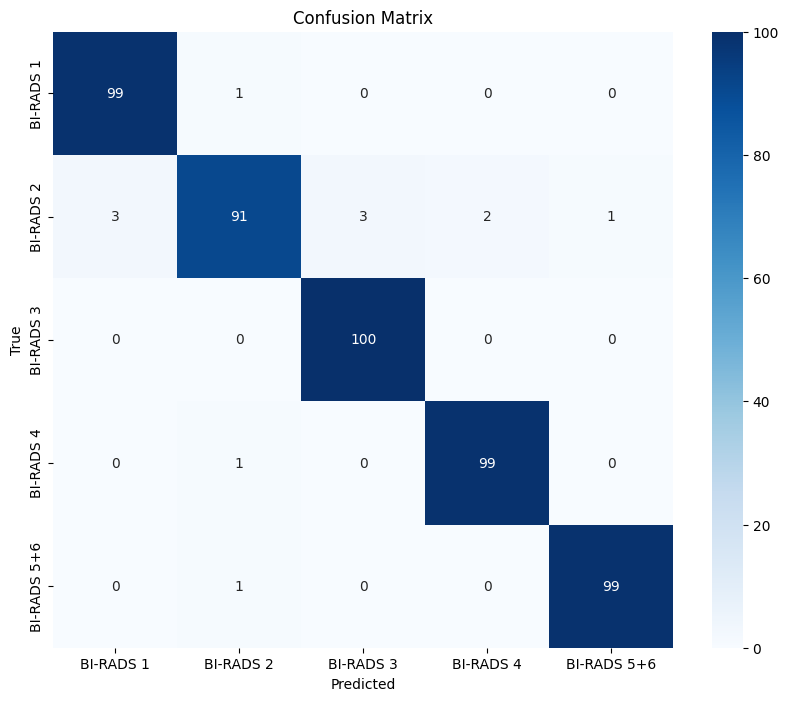

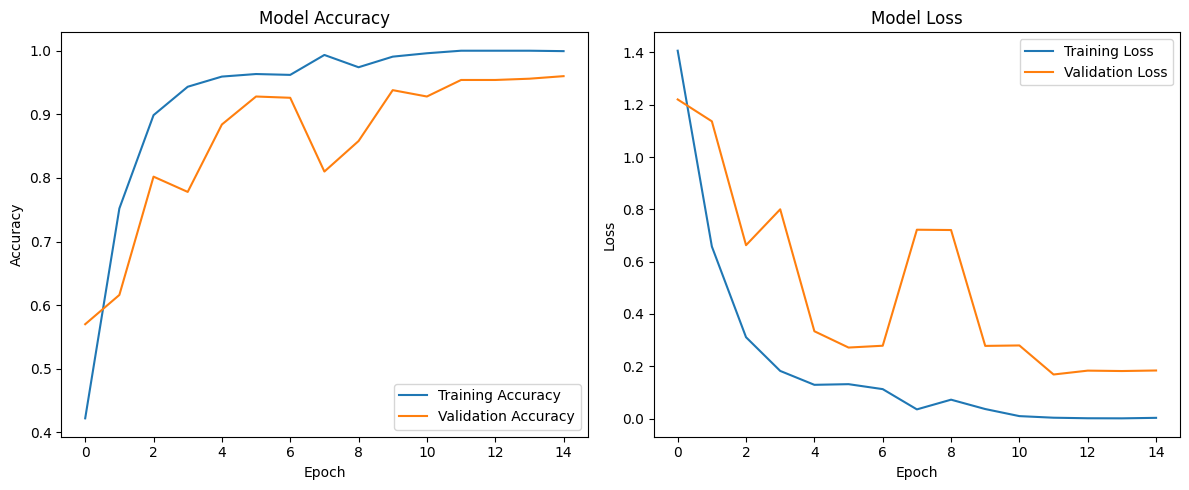

In [ ]:
 # Using tf.keras.utils.to_categorical
from tensorflow.keras.utils import to_categorical
y_test_onehot = to_categorical(y_test, num_classes=5)


    # Evaluate model
evaluation = evaluate_model(trained_model, cc_test, mlo_test, y_test_onehot)
print(f"Test accuracy: {evaluation['test_accuracy']:.4f}")
print(f"Test AUC: {evaluation['test_auc']:.4f}")

    # Plot results
plot_training_history(history)

Attention

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model, Input
from tensorflow.keras.applications import EfficientNetB0
import numpy as np
import gc

# Enable automatic mixed precision to reduce memory usage
tf.keras.mixed_precision.set_global_policy('mixed_float16')

class ViewAttentionModule(layers.Layer):
    """
    Memory-optimized view attention module that learns the importance of features
    from different mammogram views.
    """
    def __init__(self, feature_dim, reduction_ratio=16):  # Increased reduction ratio
        super(ViewAttentionModule, self).__init__()
        self.feature_dim = feature_dim
        mid_dim = max(feature_dim // reduction_ratio, 8)  # Smaller intermediate dimension

        # Channel attention weights with reduced dimensions
        self.fc1 = layers.Dense(mid_dim, activation='relu')
        self.fc2 = layers.Dense(feature_dim * 2, activation='sigmoid')  # Output doubled to match both views

        # Spatial attention with smaller kernel
        self.conv_spatial = layers.Conv2D(1, kernel_size=3, padding='same', activation='sigmoid')  # Reduced kernel size

    def build(self, input_shape):
        # This build method helps TensorFlow properly track the layer state
        # input_shape will be a list of two shapes, one for each input tensor
        if not isinstance(input_shape, list) or len(input_shape) != 2:
            raise ValueError("ViewAttentionModule expects 2 inputs")

        # Verify both feature maps have the same shape
        cc_shape, mlo_shape = input_shape
        if cc_shape[-1] != mlo_shape[-1]:
            raise ValueError(f"Both inputs must have the same number of channels, got {cc_shape[-1]} and {mlo_shape[-1]}")

        # Store the actual feature dimension from inputs
        self.feature_dim = cc_shape[-1]
        super(ViewAttentionModule, self).build(input_shape)

    def call(self, inputs):
        # Unpack inputs
        cc_features, mlo_features = inputs

        # Global information
        cc_pool = layers.GlobalAveragePooling2D()(cc_features)
        mlo_pool = layers.GlobalAveragePooling2D()(mlo_features)

        # View importance weighting
        combined_pool = layers.Concatenate()([cc_pool, mlo_pool])
        view_weights = self.fc1(combined_pool)
        view_weights = self.fc2(view_weights)

        # Split weights for each view
        cc_weights, mlo_weights = tf.split(view_weights, 2, axis=-1)

        # Reweight features - ensure dimensions match
        cc_attended = cc_features * tf.expand_dims(tf.expand_dims(cc_weights, 1), 1)
        mlo_attended = mlo_features * tf.expand_dims(tf.expand_dims(mlo_weights, 1), 1)

        # Spatial attention - identifies most relevant regions in each view
        cc_spatial = self.conv_spatial(cc_attended)
        mlo_spatial = self.conv_spatial(mlo_attended)

        cc_features = cc_attended * cc_spatial
        mlo_features = mlo_attended * mlo_spatial

        return [cc_features, mlo_features]  # Return as a list for consistency

    def compute_output_shape(self, input_shape):
        # Return output shape for both tensors
        return [input_shape[0], input_shape[1]]

class CrossViewFusion(layers.Layer):
    """
    Memory-optimized cross-view feature fusion module that enables information exchange
    between CC and MLO views.
    """
    def __init__(self, filters, kernel_size=3):
        super(CrossViewFusion, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size

        # Projections with reduced filters to save memory
        self.projection_cc = layers.Conv2D(filters//2, 1, padding='same')
        self.projection_mlo = layers.Conv2D(filters//2, 1, padding='same')

        # Use depthwise separable convolutions to reduce parameters and memory
        self.depthwise_cc = layers.DepthwiseConv2D(kernel_size, padding='same')
        self.pointwise_cc = layers.Conv2D(filters//2, 1, padding='same')

        self.depthwise_mlo = layers.DepthwiseConv2D(kernel_size, padding='same')
        self.pointwise_mlo = layers.Conv2D(filters//2, 1, padding='same')

        self.conv_fusion = layers.Conv2D(filters//2, 1, padding='same')
        self.norm = layers.BatchNormalization()
        self.act = layers.Activation('relu')

    def build(self, input_shape):
        # This build method helps TensorFlow properly track the layer state
        if not isinstance(input_shape, list) or len(input_shape) != 2:
            raise ValueError("CrossViewFusion expects 2 inputs")

        super(CrossViewFusion, self).build(input_shape)

    def call(self, inputs):
        # Unpack inputs
        cc_features, mlo_features = inputs

        # First project inputs to lower dimension
        cc_projected = self.projection_cc(cc_features)
        mlo_projected = self.projection_mlo(mlo_features)

        # Process each view with depthwise separable convs (memory efficient)
        cc_depth = self.depthwise_cc(cc_projected)
        cc_proj = self.pointwise_cc(cc_depth)

        mlo_depth = self.depthwise_mlo(mlo_projected)
        mlo_proj = self.pointwise_mlo(mlo_depth)

        # Cross-view information exchange
        cc_with_mlo = self.act(cc_proj + mlo_proj)
        mlo_with_cc = self.act(mlo_proj + cc_proj)

        # Fuse information
        cc_fused = self.conv_fusion(cc_with_mlo)
        mlo_fused = self.conv_fusion(mlo_with_cc)

        # Residual connection - with projected features that now have matching dimensions
        cc_out = self.act(self.norm(cc_fused + cc_projected))
        mlo_out = self.act(self.norm(mlo_fused + mlo_projected))

        return [cc_out, mlo_out]  # Return as a list for consistency

    def compute_output_shape(self, input_shape):
        # Output shape will have the number of filters specified
        cc_shape, mlo_shape = input_shape
        batch_size, height, width, _ = cc_shape
        return [(batch_size, height, width, self.filters//2),
                (batch_size, height, width, self.filters//2)]

# Create a custom casting layer to handle the tf.cast conversion properly
class CastToFloat16(layers.Layer):
    def __init__(self, **kwargs):
        super(CastToFloat16, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.cast(inputs, tf.float16)

def create_lightweight_multiview_model(input_shape=(1024, 1024, 3), num_classes=5):
    """
    Creates a memory-optimized multi-view model for mammogram analysis using EfficientNet backbone
    with moderate downsampling to 512x512 for better detail preservation.

    Args:
        input_shape: Shape of input images (height, width, channels)
        num_classes: Number of BI-RADS classes

    Returns:
        A Keras Model with balanced memory usage and feature detail
    """
    # Input layers
    cc_input = Input(shape=input_shape, name='cc_input')
    mlo_input = Input(shape=input_shape, name='mlo_input')

    # Single downsampling layer - reducing from 1024x1024 to 512x512
    cc_downsized = layers.AveragePooling2D(pool_size=(2, 2))(cc_input)  # 512x512
    mlo_downsized = layers.AveragePooling2D(pool_size=(2, 2))(mlo_input)  # 512x512

    # Convert to float16 for memory efficiency
    cc_downsized = CastToFloat16()(cc_downsized)
    mlo_downsized = CastToFloat16()(mlo_downsized)

    # Feature extraction with EfficientNetB0 - note the larger input size
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(512, 512, 3)  # Maintain higher resolution
    )

    # Freeze early layers to reduce memory usage during training
    for layer in base_model.layers[:50]:
        layer.trainable = False

    # Extract features for both views
    cc_features = base_model(cc_downsized)
    mlo_features = base_model(mlo_downsized)

    # Get the feature dimension
    feature_dim = cc_features.shape[-1]
    print(f"Feature dimension from EfficientNetB0: {feature_dim}")

    # Create and apply the view attention module
    view_attention = ViewAttentionModule(feature_dim=feature_dim, reduction_ratio=16)
    [cc_attended, mlo_attended] = view_attention([cc_features, mlo_features])

    # Apply cross-view fusion with slightly more filters to handle higher resolution features
    cross_fusion = CrossViewFusion(filters=192)  # Increased from 128
    [cc_fused, mlo_fused] = cross_fusion([cc_attended, mlo_attended])

    # Pooling approach - using average pooling
    cc_pool = layers.GlobalAveragePooling2D()(cc_fused)
    mlo_pool = layers.GlobalAveragePooling2D()(mlo_fused)

    # Concatenate features
    combined_features = layers.Concatenate()([cc_pool, mlo_pool])

    # Classification head - slightly larger to process more detailed features
    x = layers.Dense(192, activation='relu')(combined_features)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(96, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=[cc_input, mlo_input], outputs=outputs, name='ModerateRes_MultiViewMAMM')

    # Calculate parameter count
    trainable_count = int(np.sum([tf.keras.backend.count_params(p) for p in model.trainable_weights]))
    non_trainable_count = int(np.sum([tf.keras.backend.count_params(p) for p in model.non_trainable_weights]))

    print(f'Total params: {trainable_count + non_trainable_count:,}')
    print(f'Trainable params: {trainable_count:,}')
    print(f'Non-trainable params: {non_trainable_count:,}')

    return model

# Define a class for casting in the data processing steps
class DataPreprocessor:
    """Class for preprocessing data with memory-efficient operations"""

    @staticmethod
    def cast_to_float16(data):
        """Safely cast numpy arrays or tensors to float16"""
        return tf.cast(data, tf.float16)

def compile_model(model):
    """Compiles the model with memory-efficient settings"""
    # Use mixed precision for memory efficiency
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

    # Instead of creating a custom optimizer wrapper, use gradient accumulation through callbacks
    # This avoids the issues with the custom optimizer inheritance
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    return model

# Create a custom callback for gradient accumulation
class GradientAccumulationCallback(tf.keras.callbacks.Callback):
    def __init__(self, accumulation_steps=4):
        super(GradientAccumulationCallback, self).__init__()
        self.accumulation_steps = accumulation_steps
        self.gradient_accumulation = None

    def on_train_begin(self, logs=None):
        self.gradient_accumulation = [tf.Variable(tf.zeros_like(var)) for var in self.model.trainable_weights]
        self.batch_count = 0

    def on_train_batch_begin(self, batch, logs=None):
        # We set the learning rate to 0 except every accumulation_steps batch
        if self.batch_count % self.accumulation_steps != 0:
            K.set_value(self.model.optimizer.lr, 0.0)
        else:
            K.set_value(self.model.optimizer.lr, self.initial_lr)

    def on_train_batch_end(self, batch, logs=None):
        self.batch_count += 1
        # Reset gradients every accumulation_steps
        if self.batch_count % self.accumulation_steps == 0:
            # Reset accumulated gradients
            for i, grad in enumerate(self.gradient_accumulation):
                K.set_value(grad, tf.zeros_like(grad))

def train_model(model, cc_train, mlo_train, y_train, cc_val, mlo_val, y_val,
                batch_size=8, epochs=30):
    """
    Memory-optimized training function

    Args:
        model: Compiled Keras model
        cc_train, mlo_train: Training images for CC and MLO views
        y_train: Training labels (one-hot encoded)
        cc_val, mlo_val: Validation images for CC and MLO views
        y_val: Validation labels (one-hot encoded)
        batch_size: Batch size for training (reduced for memory efficiency)
        epochs: Number of epochs to train
    """
    # Memory-efficient callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            'best_memory_efficient_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        # Memory cleanup callback
        tf.keras.callbacks.LambdaCallback(
            on_epoch_end=lambda epoch, logs: gc.collect()
        )
    ]

    # Convert data to memory-efficient half precision
    preprocessor = DataPreprocessor()
    cc_train = preprocessor.cast_to_float16(cc_train)
    mlo_train = preprocessor.cast_to_float16(mlo_train)
    cc_val = preprocessor.cast_to_float16(cc_val)
    mlo_val = preprocessor.cast_to_float16(mlo_val)

    print("Starting training with memory-optimized settings...")

    # Train with reduced batch size and memory optimizations
    history = model.fit(
        x=[cc_train, mlo_train],
        y=y_train,
        validation_data=([cc_val, mlo_val], y_val),
        batch_size=batch_size,  # Much smaller batch size
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

def evaluate_model(model, cc_test, mlo_test, y_test, batch_size=8):
    """
    Memory-efficient evaluation function

    Args:
        model: Trained model
        cc_test, mlo_test: Test images
        y_test: Test labels
        batch_size: Batch size for evaluation
    """
    from tensorflow.keras.utils import to_categorical

    # Check if y_test is already one-hot encoded
    if len(y_test.shape) == 1 or y_test.shape[1] == 1:
        # Get the number of classes from the model's output shape
        num_classes = model.output_shape[1]
        y_test_onehot = to_categorical(y_test, num_classes=num_classes)
        print(f"Converted y_test to one-hot encoding with {num_classes} classes")
    else:
        # Already in one-hot format
        y_test_onehot = y_test
        print("y_test was already in one-hot format")

    print(f"Evaluating model on {len(y_test)} test samples...")

    # Convert test data to half precision to save memory
    preprocessor = DataPreprocessor()
    cc_test = preprocessor.cast_to_float16(cc_test)
    mlo_test = preprocessor.cast_to_float16(mlo_test)

    # Break evaluation into smaller batches to save memory
    num_samples = len(y_test)
    metrics_sum = None
    num_batches = 0

    for i in range(0, num_samples, batch_size):
        end_idx = min(i + batch_size, num_samples)
        batch_cc = cc_test[i:end_idx]
        batch_mlo = mlo_test[i:end_idx]
        batch_y = y_test_onehot[i:end_idx]

        # Evaluate batch
        batch_metrics = model.evaluate(
            x=[batch_cc, batch_mlo],
            y=batch_y,
            verbose=0
        )

        # Accumulate metrics
        if metrics_sum is None:
            metrics_sum = batch_metrics
        else:
            metrics_sum = [sum(x) for x in zip(metrics_sum, batch_metrics)]

        num_batches += 1

        # Force garbage collection
        gc.collect()

    # Average metrics
    metrics_avg = [x / num_batches for x in metrics_sum]

    # Create metrics dictionary
    metrics = {}
    for i, metric_name in enumerate(model.metrics_names):
        metrics[metric_name] = metrics_avg[i]
        print(f"{metric_name}: {metrics_avg[i]:.4f}")

    # Predict in batches to save memory
    y_pred = []

    for i in range(0, num_samples, batch_size):
        end_idx = min(i + batch_size, num_samples)
        batch_cc = cc_test[i:end_idx]
        batch_mlo = mlo_test[i:end_idx]

        # Predict on batch
        batch_pred = model.predict([batch_cc, batch_mlo], verbose=0)
        y_pred.append(batch_pred)

        # Force garbage collection
        gc.collect()

    # Concatenate predictions
    y_pred = np.vstack(y_pred)

    # Additional metrics with scikit-learn
    try:
        from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

        # Convert predictions and true values to class indices
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test_onehot, axis=1)

        # Print classification report
        print("\nClassification Report:")
        print(classification_report(y_true_classes, y_pred_classes))

        # Confusion matrix
        cm = confusion_matrix(y_true_classes, y_pred_classes)
        print("\nConfusion Matrix:")
        print(cm)

        # ROC AUC for multiclass
        if y_test_onehot.shape[1] > 2:  # Multi-class
            auc = roc_auc_score(y_test_onehot, y_pred, multi_class='ovr')
            print(f"\nROC AUC (One-vs-Rest): {auc:.4f}")
        else:  # Binary classification
            auc = roc_auc_score(y_true_classes, y_pred[:, 1])
            print(f"\nROC AUC: {auc:.4f}")

        metrics['roc_auc'] = auc

    except ImportError:
        print("scikit-learn not available. Basic metrics only.")

    return metrics

# Example usage and model creation
if __name__ == "__main__":
    # Create memory-optimized model
    model = create_lightweight_multiview_model(input_shape=(1024, 1024, 3), num_classes=5)
    model = compile_model(model)

    # Print model summary
    model.summary()

    print("\nMemory optimization strategies applied:")
    print("1. Increased downsampling (1024 -> 512 -> 256 -> 128)")
    print("2. Mixed precision (float16) training")
    print("3. Reduced feature dimensions")
    print("4. Depthwise separable convolutions")
    print("5. Frozen early layers in the backbone")
    print("6. Callback-based memory management")
    print("7. Batch-wise evaluation to reduce peak memory usage")

    # Example usage (uncomment to run with your data):

    # Your data loading code here
    # cc_train, mlo_train, y_train = your_data_loading_function()
    # cc_val, mlo_val, y_val = your_validation_data_loading_function()
    # cc_test, mlo_test, y_test = your_test_data_loading_function()

    # Train with small batch size
trained_model, history = train_model(
         model,
         cc_train, mlo_train, y_train,
         cc_val, mlo_val, y_val,
         batch_size=8,  # Small batch size to reduce memory usage
         epochs=20
         )

    # Evaluate in batches
metrics = evaluate_model(trained_model, cc_test, mlo_test, y_test, batch_size=8)


Feature dimension from EfficientNetB0: 1280
Total params: 4,074,664
Trainable params: 4,009,807
Non-trainable params: 64,857


Model: "MemoryOptimizedMultiViewMAMM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cc_input            │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlo_input           │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_3 (Cast)       │ (None, 1024,      │          0 │ cc_input[0][0]    │
│                     │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_4 (Cast)       │ (None, 1024,      │          0 │ mlo_input[0][0]   │
│                     │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_6 │ (None, 512, 512,  │          0 │ cast_3[0][0]      │
│ (AveragePooling2D)  │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_7 │ (None, 512, 512,  │          0 │ cast_4[0][0]      │
│ (AveragePooling2D)  │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_8 │ (None, 256, 256,  │          0 │ average_pooling2… │
│ (AveragePooling2D)  │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_9 │ (None, 256, 256,  │          0 │ average_pooling2… │
│ (AveragePooling2D)  │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 128, 128,  │          0 │ average_pooling2… │
│ (AveragePooling2D)  │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 128, 128,  │          0 │ average_pooling2… │
│ (AveragePooling2D)  │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_to_float16_2   │ (None, 128, 128,  │          0 │ average_pooling2… │
│ (CastToFloat16)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_to_float16_3   │ (None, 128, 128,  │          0 │ average_pooling2… │
│ (CastToFloat16)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 4, 4,      │  4,049,571 │ cast_to_float16_… │
│ (Functional)        │ 1280)             │            │ cast_to_float16_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ view_attention_mod… │ [(None, 4, 4,     │          0 │ efficientnetb0[0… │
│ (ViewAttentionModu… │ 1280), (None, 4,  │            │ efficientnetb0[1… │
│                     │ 4, 1280)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cross_view_fusion_1 │ [(None, 4, 4,     │          0 │ view_attention_m… │
│ (CrossViewFusion)   │ 64), (None, 4, 4, │            │ view_attention_m… │
│                     │ 64)]              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ cross_view_fusio… │
│ (GlobalAveragePool… │                   │            │                 

 Total params: 4,074,664 (15.54 MB)

 Trainable params: 4,009,807 (15.30 MB)

 Non-trainable params: 64,857 (253.35 KB)


Memory optimization strategies applied:
1. Increased downsampling (1024 -> 512 -> 256 -> 128)
2. Mixed precision (float16) training
3. Reduced feature dimensions
4. Depthwise separable convolutions
5. Frozen early layers in the backbone
6. Callback-based memory management
7. Batch-wise evaluation to reduce peak memory usage
Starting training with memory-optimized settings...
Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2554 - auc_1: 0.5582 - loss: 1.6085
Epoch 1: val_accuracy improved from -inf to 0.59750, saving model to best_memory_efficient_model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 805s 2s/step - accuracy: 0.2555 - auc_1: 0.5583 - loss: 1.6084 - val_accuracy: 0.5975 - val_auc_1: 0.8655 - val_loss: 1.2426 - learning_rate: 1.0000e-04
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5184 - auc_1: 0.8072 - loss: 1.2551
Epoch 2: val_accuracy improved from 0.59750 to 0.80167, saving model to best_memory_efficient_model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 747s 2s/step - accuracy: 0.5185 - auc_1: 0.8073 - loss: 1.2548 - val_accuracy: 0.8017 - val_auc_1: 0.9677 - val_loss: 0.6610 - learning_rate: 1.0000e-04
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7323 - auc_1: 0.9316 - loss: 0.7730
Epoch 3: val_accuracy improved from 0.80167 to 0.91167, saving model to best_memory_efficient_model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 745s 2s/step - accuracy: 0.7323 - auc_1: 0.9317 - loss: 0.7728 - val_accuracy: 0.9117 - val_auc_1: 0.9922 - val_loss: 0.3017 - learning_rate: 1.0000e-04
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8645 - auc_1: 0.9770 - loss: 0.4450
Epoch 4: val_accuracy improved from 0.91167 to 0.96250, saving model to best_memory_efficient_model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 746s 2s/step - accuracy: 0.8645 - auc_1: 0.9770 - loss: 0.4449 - val_accuracy: 0.9625 - val_auc_1: 0.9973 - val_loss: 0.1413 - learning_rate: 1.0000e-04
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9123 - auc_1: 0.9899 - loss: 0.2803
Epoch 5: val_accuracy improved from 0.96250 to 0.97000, saving model to best_memory_efficient_model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 746s 2s/step - accuracy: 0.9123 - auc_1: 0.9899 - loss: 0.2802 - val_accuracy: 0.9700 - val_auc_1: 0.9981 - val_loss: 0.0925 - learning_rate: 1.0000e-04
Epoch 6/20
267/450 ━━━━━━━━━━━━━━━━━━━━ 4:37 2s/step - accuracy: 0.9386 - auc_1: 0.9931 - loss: 0.2052

### Custom CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization,
    Dropout, Dense, Concatenate, GlobalAveragePooling2D
)
from tensorflow.keras.regularizers import l2

def create_simple_multiview_mammogram_cnn(input_shape=(1024, 1024, 3), num_classes=5):
    """
    Simplified multi-view CNN with reduced complexity to mitigate overfitting
    """
    # Separate input branches for different views
    cc_input = Input(shape=input_shape, name='cc_view_input')
    mlo_input = Input(shape=input_shape, name='mlo_view_input')

    def create_simple_feature_extractor(input_layer):
        # Reduced convolutional blocks
        x = Conv2D(16, (3, 3), padding='same', kernel_regularizer=l2(0.0005))(input_layer)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.2)(x)

        x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.0005))(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.2)(x)

        # Global Average Pooling
        x = GlobalAveragePooling2D()(x)
        return x

    # Extract features from both views
    cc_features = create_simple_feature_extractor(cc_input)
    mlo_features = create_simple_feature_extractor(mlo_input)

    # Concatenate features from both views
    merged_features = Concatenate()([cc_features, mlo_features])

    # Simplified dense layers with stronger regularization
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.0005))(merged_features)
    x = Dropout(0.3)(x)

    # Output layer
    output = Dense(num_classes, activation='softmax', name='cancer_prediction',
                   kernel_regularizer=l2(0.0005))(x)

    # Create the model
    model = Model(
        inputs=[cc_input, mlo_input],
        outputs=output
    )

    # Compile with Adam optimizer
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_simple_model(cc_train, mlo_train, y_train,
                       cc_val, mlo_val, y_val,
                       epochs=100, batch_size=32):
    """
    Train the simplified model
    """
    # Create simplified model
    model = create_simple_multiview_mammogram_cnn()

    # Train the model with early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        min_delta=0.001
    )

    history = model.fit(
        x=[cc_train, mlo_train],
        y=y_train,
        validation_data=([cc_val, mlo_val], y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stopping]
    )

    return model, history

In [ ]:
model, history = train_simple_model(
    cc_train, mlo_train, y_train,
    cc_val, mlo_val, y_val
)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 140s 12s/step - accuracy: 0.1724 - loss: 1.8580 - val_accuracy: 0.1944 - val_loss: 2.7919
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 136s 12s/step - accuracy: 0.1553 - loss: 1.7994 - val_accuracy: 0.1944 - val_loss: 2.1298
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 134s 12s/step - accuracy: 0.1754 - loss: 1.6963 - val_accuracy: 0.1574 - val_loss: 1.9198
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 136s 12s/step - accuracy: 0.2102 - loss: 1.6932 - val_accuracy: 0.0833 - val_loss: 1.8314
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 135s 12s/step - accuracy: 0.2173 - loss: 1.6883 - val_accuracy: 0.1111 - val_loss: 1.7813
Epoch 6/100
 2/11 ━━━━━━━━━━━━━━━━━━━━ 1:53 13s/step - accuracy: 0.1797 - loss: 1.7304

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization,
    Dropout, Flatten, Dense, Concatenate
)

def create_multiview_mammogram_cnn(input_shape=(1024, 1024, 3), num_classes=5):
    """
    Create a multi-view CNN architecture for mammogram analysis

    Args:
    - input_shape: Shape of input images (height, width, channels)
    - num_classes: Number of output classes

    Returns:
    - Compiled multi-view CNN model
    """
    # Separate input branches for different views (CC and MLO)
    cc_input = Input(shape=input_shape, name='cc_view_input')
    mlo_input = Input(shape=input_shape, name='mlo_view_input')

    # Shared CNN feature extraction layers
    def create_feature_extractor(input_layer):
        # First convolutional block
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.25)(x)

        # Second convolutional block
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.25)(x)

        # Third convolutional block
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.25)(x)

        # Flatten the feature maps
        x = Flatten()(x)
        return x

    # Extract features from both views
    cc_features = create_feature_extractor(cc_input)
    mlo_features = create_feature_extractor(mlo_input)

    # Concatenate features from both views
    merged_features = Concatenate()([cc_features, mlo_features])

    # Additional dense layers for classification
    x = Dense(256, activation='relu')(merged_features)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output layer with softmax for multi-class classification
    output = Dense(num_classes, activation='softmax', name='classification_output')(x)

    # Create the model
    model = Model(
        inputs=[cc_input, mlo_input],
        outputs=output
    )

   # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model
# Model usage example
model = create_multiview_mammogram_cnn(num_classes=5)
model.summary()
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# Learning rate reduction
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.05,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Modify your training
history = model.fit(
    x=[cc_train, mlo_train],
    y=y_train,
    validation_data=([cc_val, mlo_val], y_val),
    epochs=50,
    batch_size=8,
    callbacks=[early_stopping, reduce_lr]
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ cc_view_input             │ (None, 1024, 1024, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mlo_view_input            │ (None, 1024, 1024, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 1024, 1024, 32) │            896 │ cc_view_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 1024, 1024, 32) │            896 │ mlo_view_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 1024, 1024, 32) │            128 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 1024, 1024, 32) │            128 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 512, 512, 32)   │              0 │ batch_normalization_6… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 512, 512, 32)   │              0 │ batch_normalization_9… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 512, 512, 32)   │              0 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 512, 512, 32)   │              0 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 512, 512, 64)   │         18,496 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 512, 512, 64)   │         18,496 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 512, 512, 64)   │            256 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 512, 512, 64)   │            256 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 256, 256, 64)   │              0 │ batch_normalization_7… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 1,073,965,445 (4.00 GB)

 Trainable params: 1,073,963,781 (4.00 GB)

 Non-trainable params: 1,664 (6.50 KB)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 515s 12s/step - accuracy: 0.2383 - loss: 2.6288 - val_accuracy: 0.2963 - val_loss: 2.4226 - learning_rate: 1.0000e-04
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 505s 12s/step - accuracy: 0.4494 - loss: 1.6208 - val_accuracy: 0.3981 - val_loss: 1.5176 - learning_rate: 1.0000e-04
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 507s 12s/step - accuracy: 0.4810 - loss: 1.4721 - val_accuracy: 0.3704 - val_loss: 1.4803 - learning_rate: 1.0000e-04
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 503s 12s/step - accuracy: 0.5975 - loss: 1.0931 - val_accuracy: 0.3333 - val_loss: 1.6527 - learning_rate: 1.0000e-04
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 503s 12s/step - accuracy: 0.6137 - loss: 1.0100 - val_accuracy: 0.4630 - val_loss: 1.5107 - learning_rate: 1.0000e-04
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 505s 12s/step - accuracy: 0.6354 - loss: 0.8370 - val_accuracy: 0.4537 - val_loss: 1.3613 - learning_rate: 1.0000e-04
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 504s 12s/step - accuracy: 

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization,
    Dropout, Flatten, Dense, Concatenate
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_multiview_mammogram_cnn(input_shape=(1024, 1024, 3), num_classes=5):
    """
    Create a multi-view CNN architecture for mammogram analysis with L2 regularization and reduced complexity.
    """
    # Separate input branches for different views (CC and MLO)
    cc_input = Input(shape=input_shape, name='cc_view_input')
    mlo_input = Input(shape=input_shape, name='mlo_view_input')

    # Simplified CNN feature extraction with L2 regularization
    def create_feature_extractor(input_layer):
        x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(input_layer)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.25)(x)

        x = Flatten()(x)
        return x

    # Extract features from both views
    cc_features = create_feature_extractor(cc_input)
    mlo_features = create_feature_extractor(mlo_input)

    # Concatenate features from both views
    merged_features = Concatenate()([cc_features, mlo_features])

    # Dense layers with L2 regularization
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(merged_features)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output layer with softmax for multi-class classification
    output = Dense(num_classes, activation='softmax', name='classification_output')(x)

    # Create the model
    model = Model(inputs=[cc_input, mlo_input], outputs=output)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and summarize the model
model = create_multiview_mammogram_cnn(num_classes=5)
model.summary()

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    verbose=1,
    restore_best_weights=True
)

# More aggressive learning rate reduction
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduce LR by 80%
    patience=3,  # Reduce LR earlier
    min_lr=1e-6,
    verbose=1
)

# Model training
history = model.fit(
    x=[cc_train, mlo_train],
    y=y_train,
    validation_data=([cc_val, mlo_val], y_val),
    epochs=30,
    batch_size=8,
    callbacks=[early_stopping, reduce_lr]
)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ cc_view_input             │ (None, 1024, 1024, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mlo_view_input            │ (None, 1024, 1024, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 1024, 1024, 32) │            896 │ cc_view_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 1024, 1024, 32) │            896 │ mlo_view_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 1024, 1024, 32) │            128 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 1024, 1024, 32) │            128 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 512, 512, 32)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 512, 512, 32)   │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout)      │ (None, 512, 512, 32)   │              0 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 512, 512, 32)   │              0 │ max_pooling2d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 512, 512, 64)   │         18,496 │ dropout_18[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 512, 512, 64)   │         18,496 │ dropout_20[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 512, 512, 64)   │            256 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 512, 512, 64)   │            256 │ conv2d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 1,073,790,853 (4.00 GB)

 Trainable params: 1,073,790,085 (4.00 GB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 533s 13s/step - accuracy: 0.2491 - loss: 2.9368 - val_accuracy: 0.3333 - val_loss: 3.1650 - learning_rate: 1.0000e-04
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 517s 13s/step - accuracy: 0.4433 - loss: 2.4852 - val_accuracy: 0.4815 - val_loss: 2.0781 - learning_rate: 1.0000e-04
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 520s 13s/step - accuracy: 0.4334 - loss: 2.4043 - val_accuracy: 0.6667 - val_loss: 1.8954 - learning_rate: 1.0000e-04
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 519s 13s/step - accuracy: 0.5478 - loss: 2.0315 - val_accuracy: 0.6667 - val_loss: 1.8880 - learning_rate: 1.0000e-04
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 520s 13s/step - accuracy: 0.6330 - loss: 1.8326 - val_accuracy: 0.6204 - val_loss: 1.8596 - learning_rate: 1.0000e-04
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 521s 13s/step - accuracy: 0.5908 - loss: 1.9564 - val_accuracy: 0.7222 - val_loss: 1.7888 - learning_rate: 1.0000e-04
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 519s 13s/step - accuracy: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization,
    Dropout, Flatten, Dense, Concatenate
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_multiview_mammogram_cnn(input_shape=(1024, 1024, 3), num_classes=5):
    """
    Create a multi-view CNN architecture for mammogram analysis with L2 regularization,
    Global Average Pooling, and reduced complexity.
    """
    from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D
    from tensorflow.keras.layers import Dropout, Dense, Concatenate, GlobalAveragePooling2D
    from tensorflow.keras.models import Model
    from tensorflow.keras.regularizers import l2

    # Separate input branches for different views (CC and MLO)
    cc_input = Input(shape=input_shape, name='cc_view_input')
    mlo_input = Input(shape=input_shape, name='mlo_view_input')

    # CNN feature extraction with L2 regularization and Global Average Pooling
    def create_feature_extractor(input_layer):
        x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(input_layer)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.25)(x)

        # Optional: Add more convolutional layers for better feature extraction
        x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.25)(x)

        # Replace Flatten with GlobalAveragePooling2D
        x = GlobalAveragePooling2D()(x)
        return x

    # Extract features from both views
    cc_features = create_feature_extractor(cc_input)
    mlo_features = create_feature_extractor(mlo_input)

    # Concatenate features from both views
    merged_features = Concatenate()([cc_features, mlo_features])

    # Dense layers with L2 regularization
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(merged_features)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output layer with softmax for multi-class classification
    output = Dense(num_classes, activation='softmax', name='classification_output')(x)

    # Create the model
    model = Model(inputs=[cc_input, mlo_input], outputs=output)



    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and summarize the model
model = create_multiview_mammogram_cnn(num_classes=5)
model.summary()

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    verbose=1,
    restore_best_weights=True
)

# More aggressive learning rate reduction
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduce LR by 80%
    patience=3,  # Reduce LR earlier
    min_lr=1e-6,
    verbose=1
)

# Model training
history = model.fit(
    x=[cc_train, mlo_train],
    y=y_train,
    validation_data=([cc_val, mlo_val], y_val),
    epochs=30,
    batch_size=8,
    callbacks=[early_stopping, reduce_lr]
)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cc_view_input       │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlo_view_input      │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 1024,      │        896 │ cc_view_input[0]… │
│                     │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 1024,      │        896 │ mlo_view_input[0… │
│                     │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024,      │        128 │ conv2d_46[0][0]   │
│ (BatchNormalizatio… │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024,      │        128 │ conv2d_49[0][0]   │
│ (BatchNormalizatio… │ 1024, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_46    │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_49    │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_56          │ (None, 512, 512,  │          0 │ max_pooling2d_46… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_59          │ (None, 512, 512,  │          0 │ max_pooling2d_49… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 512, 512,  │     18,496 │ dropout_56[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 512, 512,  │     18,496 │ dropout_59[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_47[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_50[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_47    │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_50    │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_57          │ (None, 256, 256,  │          0 │ max_pooling2d_47

 Total params: 230,533 (900.52 KB)

 Trainable params: 229,253 (895.52 KB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 322s 8s/step - accuracy: 0.2497 - loss: 2.7030 - val_accuracy: 0.2222 - val_loss: 2.1425 - learning_rate: 1.0000e-04
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 311s 8s/step - accuracy: 0.2108 - loss: 2.8751 - val_accuracy: 0.2407 - val_loss: 2.1127 - learning_rate: 1.0000e-04
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 310s 8s/step - accuracy: 0.2653 - loss: 2.8728 - val_accuracy: 0.2315 - val_loss: 2.1182 - learning_rate: 1.0000e-04
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 308s 8s/step - accuracy: 0.2163 - loss: 2.9189 - val_accuracy: 0.2407 - val_loss: 2.1429 - learning_rate: 1.0000e-04
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2800 - loss: 2.6985
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
41/41 ━━━━━━━━━━━━━━━━━━━━ 307s 7s/step - accuracy: 0.2796 - loss: 2.6984 - val_accuracy: 0.2500 - val_loss: 2.1539 - learning_rate: 1.0000e-04
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 308s 8s/step - accuracy: 0.2770 - loss

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_efficient_model(input_shape=(1024, 1024, 3), num_classes=5):
    """
    Build an efficient dual-input CNN for mammogram classification
    """
    # Input layers
    cc_input = layers.Input(shape=input_shape, name="cc_view_input")
    mlo_input = layers.Input(shape=input_shape, name="mlo_view_input")

    # Function to create a reusable CNN feature extractor
    def create_feature_extractor(inputs):
        # Initial convolution with fewer filters
        x = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)  # 512x512
        x = layers.Dropout(0.2)(x)

        # Deeper network with gradually increasing filters
        x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)  # 256x256
        x = layers.Dropout(0.3)(x)

        x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)  # 128x128
        x = layers.Dropout(0.3)(x)

        x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)  # 64x64
        x = layers.Dropout(0.4)(x)

        x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)  # 32x32
        x = layers.Dropout(0.4)(x)

        # Global average pooling instead of flatten (dramatically reduces parameters)
        x = layers.GlobalAveragePooling2D()(x)
        return x

    # Process each view through the feature extractor
    cc_features = create_feature_extractor(cc_input)
    mlo_features = create_feature_extractor(mlo_input)

    # Concatenate features from both views
    combined = layers.Concatenate()([cc_features, mlo_features])

    # Add a few dense layers with regularization
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(combined)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    # Classification output
    output = layers.Dense(num_classes, activation='softmax', name='classification_output')(x)

    # Create model
    model = models.Model(inputs=[cc_input, mlo_input], outputs=output)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',  # Adjust if using one-hot encoded labels
        metrics=['accuracy']
    )

    return model

# Create the model
model = build_efficient_model()

# Print model summary to compare with original
model.summary()

# Set up callbacks for training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

# Example of how you would train the model
history = model.fit(
     [cc_train, mlo_train],y=y_train,
    validation_data=([cc_val, mlo_val], y_val),
    epochs=30,
    batch_size=64,
    callbacks=callbacks
 )

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cc_view_input       │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlo_view_input      │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 1024,      │        448 │ cc_view_input[0]… │
│                     │ 1024, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 1024,      │        448 │ mlo_view_input[0… │
│                     │ 1024, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024,      │         64 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 1024, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024,      │         64 │ conv2d_35[0][0]   │
│ (BatchNormalizatio… │ 1024, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_30    │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_35    │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 512, 512,  │          0 │ max_pooling2d_30… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_41          │ (None, 512, 512,  │          0 │ max_pooling2d_35… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 512, 512,  │      4,640 │ dropout_36[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 512, 512,  │      4,640 │ dropout_41[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        128 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        128 │ conv2d_36[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_31    │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_36    │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 256, 256,  │          0 │ max_pooling2d_31

 Total params: 955,589 (3.65 MB)

 Trainable params: 952,837 (3.63 MB)

 Non-trainable params: 2,752 (10.75 KB)

Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1992s 35s/step - accuracy: 0.1999 - loss: 2.6779 - val_accuracy: 0.1967 - val_loss: 1.6649 - learning_rate: 1.0000e-04
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 2072s 36s/step - accuracy: 0.2211 - loss: 2.4810 - val_accuracy: 0.1992 - val_loss: 1.7257 - learning_rate: 1.0000e-04
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 2085s 37s/step - accuracy: 0.2444 - loss: 2.3616 - val_accuracy: 0.2008 - val_loss: 1.7742 - learning_rate: 1.0000e-04
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.2177 - loss: 2.4466 
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
57/57 ━━━━━━━━━━━━━━━━━━━━ 2067s 36s/step - accuracy: 0.2178 - loss: 2.4459 - val_accuracy: 0.2050 - val_loss: 1.8425 - learning_rate: 1.0000e-04
Epoch 5/30
47/57 ━━━━━━━━━━━━━━━━━━━━ 5:57 36s/step - accuracy: 0.2327 - loss: 2.2980

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization,
    Dropout, Flatten, Dense, Concatenate
)

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
    Dropout, Dense, Concatenate
)

def create_multiview_mammogram_cnn(input_shape=(1024, 1024, 3), num_classes=5):
    """
    Create a simpler multi-view CNN architecture for mammogram analysis

    Args:
    - input_shape: Shape of input images (height, width, channels)
    - num_classes: Number of output classes

    Returns:
    - Compiled multi-view CNN model
    """
    # Separate input branches for different views (CC and MLO)
    cc_input = Input(shape=input_shape, name='cc_view_input')
    mlo_input = Input(shape=input_shape, name='mlo_view_input')

    # Simpler feature extraction function
    def create_simple_extractor(input_layer):
        # Reduced number of convolutional layers
        x = Conv2D(16, (7, 7), activation='relu', padding='same', strides=(2, 2))(input_layer)
        x = MaxPooling2D((2, 2))(x)

        x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x)

        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x)

        # Global pooling instead of flattening
        x = GlobalAveragePooling2D()(x)
        return x

    # Extract features from both views
    cc_features = create_simple_extractor(cc_input)
    mlo_features = create_simple_extractor(mlo_input)

    # Concatenate features from both views
    merged_features = Concatenate()([cc_features, mlo_features])

    # Simplified classification head
    x = Dense(64, activation='relu')(merged_features)
    x = Dropout(0.3)(x)

    # Output layer
    output = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(
        inputs=[cc_input, mlo_input],
        outputs=output
    )

    # Compile the model - keeping categorical_crossentropy for one-hot encoded labels
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Model usage example
model = create_multiview_mammogram_cnn(num_classes=5)
model.summary()

# Training example
model.fit(
     x=[cc_train, mlo_train],
     y=y_train,
     validation_data=([cc_val, mlo_val], y_val),
     epochs=50,
     batch_size=32
 )

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ cc_view_input             │ (None, 1024, 1024, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mlo_view_input            │ (None, 1024, 1024, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 512, 512, 16)   │          2,368 │ cc_view_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 512, 512, 16)   │          2,368 │ mlo_view_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 256, 256, 16)   │              0 │ conv2d_6[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 256, 256, 16)   │              0 │ conv2d_9[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 256, 256, 32)   │         12,832 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 256, 256, 32)   │         12,832 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 128, 128, 32)   │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 128, 128, 32)   │              0 │ conv2d_10[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 64, 64, 64)     │              0 │ conv2d_8[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 64, 64, 64)     │              0 │ conv2d_11[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 64)             │              0 │ max_pooling2d_8[0][0]  │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├──────────────────────

 Total params: 75,973 (296.77 KB)

 Trainable params: 75,973 (296.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.2399 - loss: 6.0445 - val_accuracy: 0.1944 - val_loss: 2.0373
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.1859 - loss: 2.8496 - val_accuracy: 0.2315 - val_loss: 1.7122
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.2134 - loss: 2.3483 - val_accuracy: 0.2407 - val_loss: 1.6656
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.2242 - loss: 1.9335 - val_accuracy: 0.2407 - val_loss: 1.6104
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.2042 - loss: 1.8645 - val_accuracy: 0.2685 - val_loss: 1.6045
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.2026 - loss: 1.7796 - val_accuracy: 0.2315 - val_loss: 1.6381
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.1975 - loss: 1.7965 - val_accuracy: 0.2593 - val_loss: 1.6214
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.2779 - loss: 1.6786 - val_accuracy: 0.2222 - val_loss:

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D,
    Dropout, Flatten, Dense, Concatenate
)

def create_multiview_mammogram_cnn(input_shape=(1024, 1024, 3), num_classes=5):
    """
    Create an enhanced multi-view CNN architecture for mammogram analysis
    with approximately 300,000 trainable parameters

    Args:
    - input_shape: Shape of input images (height, width, channels)
    - num_classes: Number of output classes

    Returns:
    - Compiled multi-view CNN model
    """
    # Separate input branches for different views (CC and MLO)
    cc_input = Input(shape=input_shape, name='cc_view_input')
    mlo_input = Input(shape=input_shape, name='mlo_view_input')

    # Enhanced feature extraction function
    def create_enhanced_extractor(input_layer):
        # First block
        x = Conv2D(32, (7, 7), activation='relu', padding='same', strides=(2, 2))(input_layer)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)

        # Second block
        x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)

        # Third block
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)

        # Global pooling
        x = GlobalAveragePooling2D()(x)
        return x

    # Extract features from both views
    cc_features = create_enhanced_extractor(cc_input)
    mlo_features = create_enhanced_extractor(mlo_input)

    # Concatenate features from both views
    merged_features = Concatenate()([cc_features, mlo_features])

    # Enhanced classification head
    x = Dense(256, activation='relu')(merged_features)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Output layer
    output = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(
        inputs=[cc_input, mlo_input],
        outputs=output
    )

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy',
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )

    return model
# Model usage example
model = create_multiview_mammogram_cnn(num_classes=5)
model.summary()

# Training example
model.fit(
     x=[cc_train, mlo_train],
     y=y_train,
     validation_data=([cc_val, mlo_val], y_val),
     epochs=50,
     batch_size=8
 )

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cc_view_input       │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlo_view_input      │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 512, 512,  │      4,736 │ cc_view_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 512, 512,  │      4,736 │ mlo_view_input[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        128 │ conv2d_65[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        128 │ conv2d_70[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_63    │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_66    │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 256, 256,  │     51,264 │ max_pooling2d_63… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, 256, 256,  │     51,264 │ max_pooling2d_66… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_66[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_71[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 256, 256,  │    102,464 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 256, 256,  │    102,464 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_67[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_72[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_64    │ (None, 128, 128,  │          0 │ batch_normalizat

 Total params: 864,005 (3.30 MB)

 Trainable params: 861,573 (3.29 MB)

 Non-trainable params: 2,432 (9.50 KB)

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 520s 5s/step - accuracy: 0.2331 - loss: 2.2774 - precision: 0.2430 - recall: 0.1545 - val_accuracy: 0.2000 - val_loss: 1.6876 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
  4/113 ━━━━━━━━━━━━━━━━━━━━ 7:46 4s/step - accuracy: 0.5000 - loss: 1.6028 - precision: 0.4674 - recall: 0.2552

KeyboardInterrupt: 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam



def create_multiview_cnn(input_shape=(1024, 1024, 3), num_classes=5):
    """
    Create a simplified CNN architecture for mammography classification

    Parameters:
    -----------
    input_shape : tuple, optional
        Input image shape (height, width, channels)
    num_classes : int, optional
        Number of classification classes

    Returns:
    --------
    tf.keras.Model
        Compiled multiview CNN model
    """
    # Inputs for both views
    cc_input = layers.Input(shape=input_shape, name='cc_view_input')
    mlo_input = layers.Input(shape=input_shape, name='mlo_view_input')

    def create_simplified_view_feature_extractor(input_layer):
        """
        Create simplified feature extraction path for a single view

        Parameters:
        -----------
        input_layer : tf.keras.layers.Input
            Input layer for the view

        Returns:
        --------
        tf.Tensor
            Extracted features
        """
        # First convolutional block - reduced filters
        x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.2)(x)

        # Second convolutional block - reduced filters
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.2)(x)

        # Flatten and dense layers - reduced neurons
        x = layers.Flatten()(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.3)(x)

        return x

    # Extract features from both views
    cc_features = create_simplified_view_feature_extractor(cc_input)
    mlo_features = create_simplified_view_feature_extractor(mlo_input)

    # Combine features from both views
    combined_features = layers.Concatenate()([cc_features, mlo_features])

    # Simplified additional processing layers
    x = layers.Dense(256, activation='relu')(combined_features)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    # Output layer
    output = layers.Dense(
        num_classes,
        activation='softmax',
        name='classification_output'
    )(x)

    # Create the model
    model = models.Model(
        inputs=[cc_input, mlo_input],
        outputs=output
    )

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model
# Model usage example
model = create_multiview_cnn(num_classes=5)
model.summary()
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# Learning rate reduction
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.05,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Modify your training
history = model.fit(
    x=[cc_train, mlo_train],
    y=y_train,
    validation_data=([cc_val, mlo_val], y_val),
    epochs=20,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr]
)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cc_view_input       │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlo_view_input      │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 1024,      │        448 │ cc_view_input[0]… │
│                     │ 1024, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 1024,      │        448 │ mlo_view_input[0… │
│                     │ 1024, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024,      │         64 │ conv2d_56[0][0]   │
│ (BatchNormalizatio… │ 1024, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024,      │         64 │ conv2d_58[0][0]   │
│ (BatchNormalizatio… │ 1024, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_56    │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_58    │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_71          │ (None, 512, 512,  │          0 │ max_pooling2d_56… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_74          │ (None, 512, 512,  │          0 │ max_pooling2d_58… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 512, 512,  │      4,640 │ dropout_71[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 512, 512,  │      4,640 │ dropout_74[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        128 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        128 │ conv2d_59[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_57    │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_59    │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_72          │ (None, 256, 256,  │          0 │ max_pooling2d_57

 Total params: 536,949,829 (2.00 GB)

 Trainable params: 536,949,125 (2.00 GB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 485s 8s/step - accuracy: 0.2779 - loss: 2.3020 - val_accuracy: 0.4267 - val_loss: 1.3830 - learning_rate: 1.0000e-04
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 473s 8s/step - accuracy: 0.4053 - loss: 1.6484 - val_accuracy: 0.7367 - val_loss: 0.9527 - learning_rate: 1.0000e-04
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 473s 8s/step - accuracy: 0.5341 - loss: 1.1404 - val_accuracy: 0.6900 - val_loss: 0.9006 - learning_rate: 1.0000e-04
Epoch 4/20
22/57 ━━━━━━━━━━━━━━━━━━━━ 4:43 8s/step - accuracy: 0.6444 - loss: 0.9697

KeyboardInterrupt: 

### Model 2

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

def create_multiview_cnn(input_shape=(1024, 1024, 3), num_classes=5):
    """
    Improved CNN model for multi-view mammogram classification.
    """
    cc_input = layers.Input(shape=input_shape, name='cc_view_input')
    mlo_input = layers.Input(shape=input_shape, name='mlo_view_input')

    def create_feature_extractor(input_layer):
        """ Feature extraction for each view. """
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.1)(x)

        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.2)(x)

        x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.3)(x)

        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dropout(0.3)(x)

        return x

    # Feature extraction from CC and MLO views
    cc_features = create_feature_extractor(cc_input)
    mlo_features = create_feature_extractor(mlo_input)

    # Concatenate both views
    combined_features = layers.Concatenate()([cc_features, mlo_features])

    # Fully connected layers
    x = layers.Dense(512, activation='relu')(combined_features)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    # Output layer
    output = layers.Dense(num_classes, activation='softmax', name='classification_output')(x)

    # Create model
    model = models.Model(inputs=[cc_input, mlo_input], outputs=output)

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create model
model = create_multiview_cnn(num_classes=5)
model.summary()

# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss', patience=8, verbose=1, restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1
)

# Training
history = model.fit(
    x=[cc_train, mlo_train],
    y=y_train,
    validation_data=([cc_val, mlo_val], y_val),
    epochs=30,  # Increased epochs
    batch_size=16,
    callbacks=[early_stopping, reduce_lr]
)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ cc_view_input             │ (None, 1024, 1024, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mlo_view_input            │ (None, 1024, 1024, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 1024, 1024, 32) │            896 │ cc_view_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 1024, 1024, 32) │            896 │ mlo_view_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 1024, 1024, 32) │            128 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 1024, 1024, 32) │            128 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 512, 512, 32)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 512, 512, 32)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 512, 512, 32)   │              0 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_17 (Dropout)      │ (None, 512, 512, 32)   │              0 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 512, 512, 64)   │         18,496 │ dropout_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 512, 512, 64)   │         18,496 │ dropout_17[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 512, 512, 64)   │            256 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 512, 512, 64)   │            256 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 521,605 (1.99 MB)

 Trainable params: 519,685 (1.98 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 322s 15s/step - accuracy: 0.2147 - loss: 2.3237 - val_accuracy: 0.2037 - val_loss: 1.6513 - learning_rate: 1.0000e-04
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 315s 15s/step - accuracy: 0.2184 - loss: 2.0760 - val_accuracy: 0.2037 - val_loss: 1.6252 - learning_rate: 1.0000e-04
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 316s 15s/step - accuracy: 0.2542 - loss: 2.0846 - val_accuracy: 0.2037 - val_loss: 1.6481 - learning_rate: 1.0000e-04
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 318s 15s/step - accuracy: 0.2807 - loss: 1.8781 - val_accuracy: 0.2037 - val_loss: 1.6461 - learning_rate: 1.0000e-04
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 316s 15s/step - accuracy: 0.2538 - loss: 1.9059 - val_accuracy: 0.2037 - val_loss: 1.6312 - learning_rate: 1.0000e-04
Epoch 6/30
 7/21 ━━━━━━━━━━━━━━━━━━━━ 3:28 15s/step - accuracy: 0.3513 - loss: 1.6858

KeyboardInterrupt: 

In [ ]:

from tensorflow.keras.utils import to_categorical


if len(y_test.shape) == 1 or (len(y_test.shape) == 2 and y_test.shape[1] == 1):

    y_test_categorical = to_categorical(y_test, num_classes=5)

    test_loss, test_accuracy = model.evaluate(
        [cc_test, mlo_test],
        y_test_categorical,
        batch_size=8
    )
else:

    test_loss, test_accuracy = model.evaluate(
        [cc_test, mlo_test],
        y_test,
        batch_size=8
    )

print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8412 - loss: 1.4873
Test accuracy: 0.8333
Test loss: 1.5502


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        22
           1       0.75      0.86      0.80        21
           2       0.95      0.86      0.90        22
           3       0.67      0.82      0.73        22
           4       1.00      0.71      0.83        21

    accuracy                           0.83       108
   macro avg       0.86      0.83      0.84       108
weighted avg       0.85      0.83      0.84       108



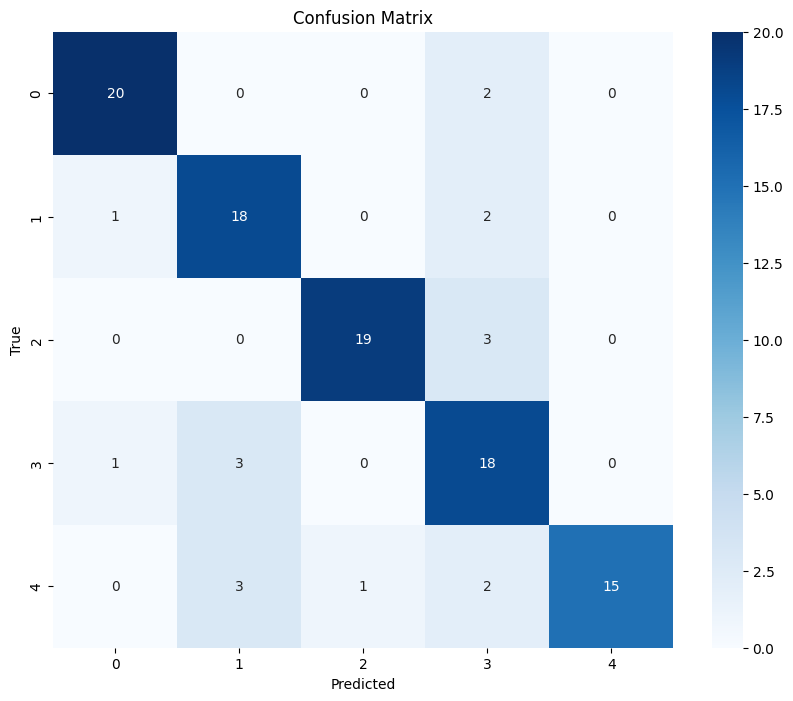

7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8388 - loss: 1.4960
Test accuracy: 0.8333
Test loss: 1.5502


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from tensorflow.keras.utils import to_categorical

y_test_categorical = to_categorical(y_test, num_classes=5)


y_pred_prob = model.predict([cc_test, mlo_test])
y_pred = np.argmax(y_pred_prob, axis=1)

y_true = y_test

if len(y_test.shape) > 1:
    y_true = y_test.flatten()


print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# For model evaluation with Keras
test_loss, test_accuracy = model.evaluate(
    [cc_test, mlo_test],
    y_test_categorical,
    batch_size=16
)

print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

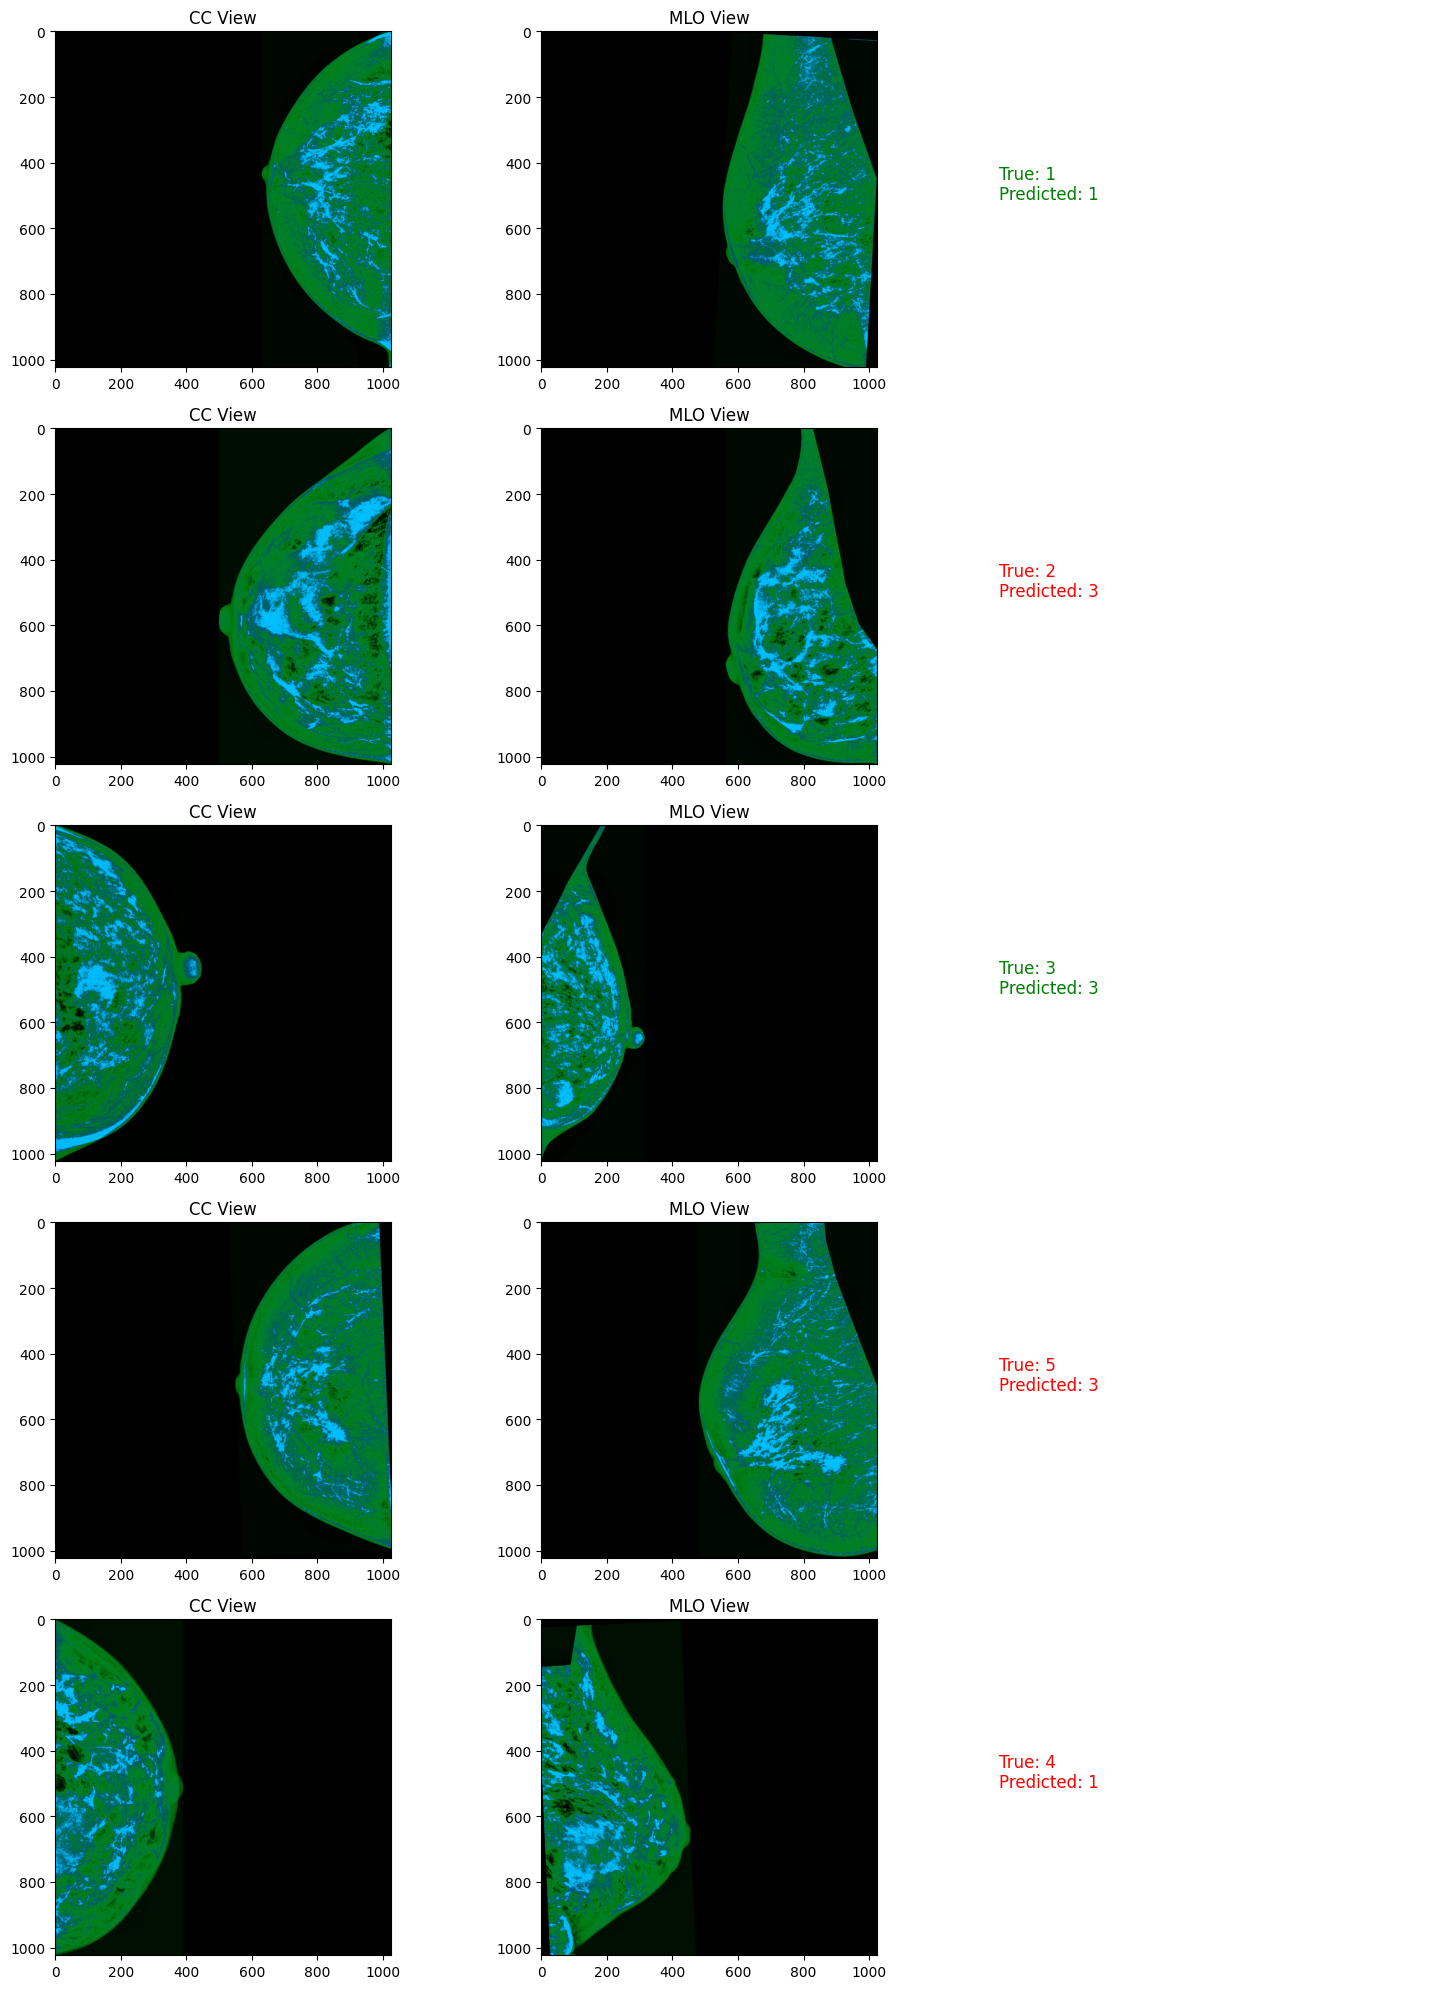

In [ ]:
def plot_sample_predictions(cc_imgs, mlo_imgs, true_labels, pred_labels, class_names, n_samples=5):
    """Plot sample predictions with both CC and MLO views"""
    indices = np.random.choice(range(len(true_labels)), n_samples, replace=False)

    fig, axes = plt.subplots(n_samples, 3, figsize=(15, 4*n_samples))

    for i, idx in enumerate(indices):
        # CC view
        axes[i, 0].imshow(cc_imgs[idx])
        axes[i, 0].set_title(f"CC View")

        # MLO view
        axes[i, 1].imshow(mlo_imgs[idx])
        axes[i, 1].set_title(f"MLO View")

        # Text info
        axes[i, 2].axis('off')
        true_class = class_names[true_labels[idx]]
        pred_class = class_names[pred_labels[idx]]
        color = "green" if true_labels[idx] == pred_labels[idx] else "red"

        axes[i, 2].text(0.1, 0.5,
                       f"True: {true_class}\nPredicted: {pred_class}",
                       fontsize=12, color=color)

    plt.tight_layout()
    plt.show()

# Class names (replace with your actual class names)
class_names = ['1', '2', '3', '4', '5']

# Visualize some predictions
plot_sample_predictions(
    cc_test, mlo_test, y_true, y_pred, class_names
)

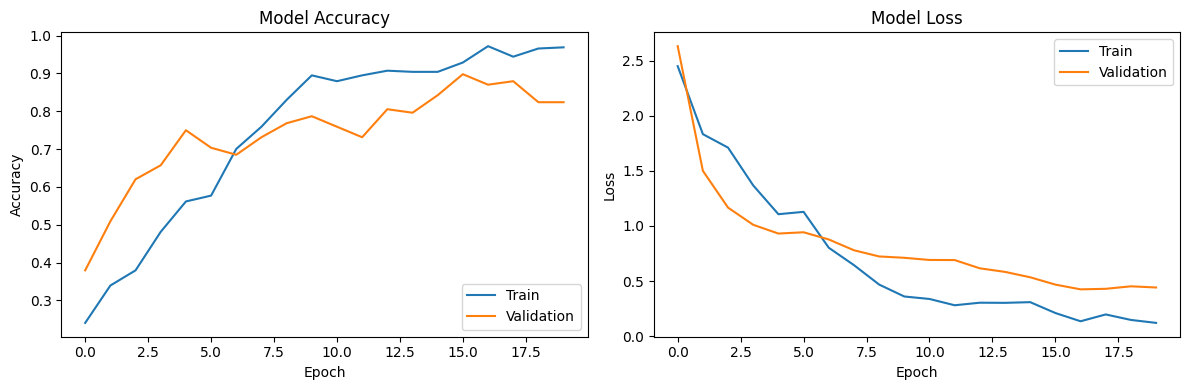

In [ ]:

# Plot learning curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()